# Includes

In [1]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter

import scipy.io

In [2]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 29.2 MB/s 
     |████████████████████████████████| 209 kB 63.3 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 112 kB 64.7 MB/s 
     |████████████████████████████████| 147 kB 63.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=06d288273c9da1b35997df1658323175c3d70facbff03a62f636ca328adf3ce8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
torch.nn.ModuleList()

ModuleList()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [8]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [9]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [10]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [11]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [12]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [13]:
def eval_model(valid_queue, model,criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda m: m(input_batch), model)))

        loss=criterion(out,desired)
        #draw_spectrum(input_batch,desired,out)

        
        accuracy = NMSE(input_batch, out-desired)
    return loss,accuracy

In [14]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        optimizer.zero_grad()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda m: m(input_batch), model)))
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [15]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [16]:
np.random.seed()
# torch.cpu.set_device()
torch
cudnn.benchmark = True
torch.manual_seed(10)
# was fixed
cudnn.enabled=False
#torch.cpu.manual_seed(10)

In [17]:
Batch_size=1000

In [18]:
serg_data=np.load('AdaptiveFilteringData/gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [19]:
name = 'BlackBoxData/BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [20]:
gamma=0.95
step_size=5

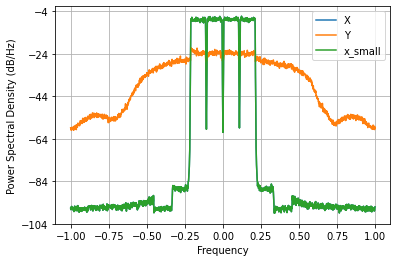

In [21]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd(x.reshape(-1,),NFFT=2048, label = "x_small")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [22]:
loss_fn = nn.MSELoss()

# Model

In [ ]:
class Cell_1(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_1,self).__init__()
        self.f=AFIR(M,0)
        self.pol=Polynomial(Poly_order,Passthrough)
    def forward(self,x):
        return self.pol(self.f(x))

In [ ]:
net=Cell_1()
# net
net=net.to("cuda:0")
#device = torch.device("cpu")
#net=net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
##### EXPERIMENTAL PART  #############
class Cell_try_1(nn.Module):
  def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
    super(Cell_try_1,self).__init__()
    self.f = AFIR(M,0)
    self.pol = Polynomial(Poly_order,Passthrough)
    self.prod = Prod_cmp()
    self.delay = Delay(D)
  def forward(self,x):
    return self.prod(self.f(self.delay(x)), self.pol(x))

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

{'p': [4, 9], 'k': [3, 9], 'z': [-2, 2]}


In [ ]:
small_model = Cell_try_1(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
small_model = small_model.to("cuda:0")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 100, scheduler, save_flag=False)

loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = accuracy_small.item()
print(score_small)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Loss =  0.00014307816243061997 Accuracy =  -23.489666593200358 dbs
Loss =  0.00013193996143449942 Accuracy =  -23.84163660336562 dbs
Loss =  0.00012801011099803896 Accuracy =  -23.97295738981066 dbs
Loss =  0.0001260242897220093 Accuracy =  -24.04085754722717 dbs
Loss =  0.00012485421563825888 Accuracy =  -24.081368024742122 dbs
Loss =  0.00012413242842289264 Accuracy =  -24.10654761491791 dbs
Loss =  0.00012349668001724101 Accuracy =  -24.12884730600134 dbs
Loss =  0.00012290383235346927 Accuracy =  -24.149745879899697 dbs
Loss =  0.00012235775097392906 Accuracy =  -24.169085274067253 dbs
Loss =  0.00012183651196329786 Accuracy =  -24.187625559751737 dbs
Loss =  0.00012152798152057908 Accuracy =  -24.1986372844812 dbs
Loss =  0.00012105577638898278 Accuracy =  -24.215544957423983 dbs
Loss =  0.00012059614952628841 Accuracy =  -24.232065715548273 dbs
Loss =  0.0001201513289369035 Accuracy =  -24.24811434446635 dbs
Loss =  0.00011972338351384621 Accuracy =  -24.26361031159598 dbs
Loss =

In [ ]:
loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)

tensor(0.0001, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(-24.4267, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


In [ ]:

huge_model = Cell_try_1(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 100, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = 18
print(score_huge)

In [ ]:
####################### OPTUNA ##########################
import optuna

class Cell_try_1(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_1,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod(self.f(self.delay(x)), self.pol(x))
        #return self.prod(x,self.pol(self.f(x)))

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

huge_model = Cell_try_1(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]

def objective(trial):

  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_1(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cuda:0")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.760764766535964 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750983 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581688 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965747 Accuracy =  -24.449810857607183 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657967 Accuracy =  -24.471092405404704 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128155 Accuracy =  -24.52347689833711 dbs
Loss =  0.00011246615383996143 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.556447949279775 dbs
Lo

[I 2022-10-27 08:45:40,895] A new study created in memory with name: no-name-0f41f26b-3507-456b-8191-9de61e218172


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001360541162037738 Accuracy =  -23.708283276067988 dbs
Loss =  0.00012586291774051091 Accuracy =  -24.046422178427992 dbs
Loss =  0.00012010381874767713 Accuracy =  -24.249831969539777 dbs
Loss =  0.00011793699806755512 Accuracy =  -24.328899439556043 dbs
Loss =  0.00011722249175670774 Accuracy =  -24.355290643518902 dbs
Loss =  0.00011651835647013688 Accuracy =  -24.381456630066786 dbs
Loss =  0.00011619812203382063 Accuracy =  -24.393409039907734 dbs
Loss =  0.00011589342289884138 Accuracy =  -24.404812232473493 dbs
Loss =  0.00011558864535678783 Accuracy =  -24.416248390980677 dbs
Loss =  0.00011528686819362232 Accuracy =  -24.427601715493175 dbs
Loss =  0.00011483405322851745 Accuracy =  -24.44469319012018 dbs
Loss =  0.00011456686608196927 Accuracy =  -24.454809797865362 dbs
Loss =  0.00011431447232759983 Accuracy =  -24.464387971427378 dbs
Loss =  0.00011407623024005906 Accuracy =  -24.47344852077036 dbs
Loss =  0.00011385142495975958 Accuracy =  -24.482015425414694 db

[I 2022-10-27 08:46:04,014] Trial 0 finished with value: -0.05287880284994044 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 0 with value: -0.05287880284994044.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001377098183493046 Accuracy =  -23.655751077188597 dbs
Loss =  0.0001257251766878073 Accuracy =  -24.05117758509646 dbs
Loss =  0.00012189950560011426 Accuracy =  -24.185380689276947 dbs
Loss =  0.00011967505348545595 Accuracy =  -24.265363828886098 dbs
Loss =  0.00011837797582656993 Accuracy =  -24.312691035448402 dbs
Loss =  0.00011758639783960696 Accuracy =  -24.341829268139254 dbs
Loss =  0.00011699407951000467 Accuracy =  -24.363761283256586 dbs
Loss =  0.00011658015367260299 Accuracy =  -24.3791538968026 dbs
Loss =  0.00011625055974678952 Accuracy =  -24.391449604423062 dbs
Loss =  0.00011597214719269601 Accuracy =  -24.401863150579786 dbs
Loss =  0.00011556792906523395 Accuracy =  -24.41702682189089 dbs
Loss =  0.00011538159571894756 Accuracy =  -24.42403472214281 dbs
Loss =  0.0001152204287612952 Accuracy =  -24.430105261369658 dbs
Loss =  0.0001150733955478014 Accuracy =  -24.43565084837313 dbs
Loss =  0.00011493153208434425 Accuracy =  -24.441008170740957 dbs
Loss 

[I 2022-10-27 08:46:25,384] Trial 1 finished with value: -0.272967248863067 and parameters: {'p': 6, 'z': -1, 'k': 7}. Best is trial 1 with value: -0.272967248863067.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013671958991427893 Accuracy =  -23.687092660753187 dbs
Loss =  0.00012708459764464668 Accuracy =  -24.004470948683885 dbs
Loss =  0.00012117022397679775 Accuracy =  -24.211441024776057 dbs
Loss =  0.00011798379893515122 Accuracy =  -24.32717637324988 dbs
Loss =  0.00011649559168046028 Accuracy =  -24.382305216398045 dbs
Loss =  0.00011596499886931387 Accuracy =  -24.402130850467742 dbs
Loss =  0.00011568622757578212 Accuracy =  -24.41258353788024 dbs
Loss =  0.00011558506338312049 Accuracy =  -24.41638297647543 dbs
Loss =  0.00011552119694035256 Accuracy =  -24.418783330696915 dbs
Loss =  0.00011545263282046903 Accuracy =  -24.421361719757478 dbs
Loss =  0.00011515499257013664 Accuracy =  -24.43257241496937 dbs
Loss =  0.00011506997585151803 Accuracy =  -24.435779911853572 dbs
Loss =  0.00011498209234471315 Accuracy =  -24.439098058411574 dbs
Loss =  0.00011488489562215656 Accuracy =  -24.442770791338955 dbs
Loss =  0.00011477635533768023 Accuracy =  -24.446875832997037 dbs

[I 2022-10-27 08:46:45,951] Trial 2 finished with value: -0.16204941472052642 and parameters: {'p': 6, 'z': 1, 'k': 9}. Best is trial 1 with value: -0.272967248863067.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001354145024311747 Accuracy =  -23.728748348414417 dbs
Loss =  0.00012502792018382407 Accuracy =  -24.075330063082824 dbs
Loss =  0.0001189748835301441 Accuracy =  -24.290847248179155 dbs
Loss =  0.0001163336769869571 Accuracy =  -24.388345579765208 dbs
Loss =  0.0001152337843320846 Accuracy =  -24.42960188582923 dbs
Loss =  0.00011459548511274141 Accuracy =  -24.45372505710043 dbs
Loss =  0.00011436047021303433 Accuracy =  -24.462640807713605 dbs
Loss =  0.00011404692848881132 Accuracy =  -24.474564197847414 dbs
Loss =  0.0001136588239327335 Accuracy =  -24.489368552021993 dbs
Loss =  0.00011326223673016638 Accuracy =  -24.504548792104174 dbs
Loss =  0.00011287351265688878 Accuracy =  -24.519479725116643 dbs
Loss =  0.00011255053609365806 Accuracy =  -24.53192445192832 dbs
Loss =  0.00011224400392792186 Accuracy =  -24.543768628446564 dbs
Loss =  0.00011195438253380905 Accuracy =  -24.554989141248278 dbs
Loss =  0.00011169749881024716 Accuracy =  -24.564965648668945 dbs
Los

[I 2022-10-27 08:47:10,456] Trial 3 finished with value: -0.0003003806260418604 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 1 with value: -0.272967248863067.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00019454645365102167 Accuracy =  -22.155166945951883 dbs
Loss =  0.00013451322779288805 Accuracy =  -23.757750189489318 dbs
Loss =  0.00012987459951523277 Accuracy =  -23.910157917732583 dbs
Loss =  0.00012700402601732507 Accuracy =  -24.00722524864523 dbs
Loss =  0.0001255246935483653 Accuracy =  -24.058108433623605 dbs
Loss =  0.00012481014464362593 Accuracy =  -24.082901266407717 dbs
Loss =  0.00012440079408636138 Accuracy =  -24.097168605472202 dbs
Loss =  0.00012406441554108097 Accuracy =  -24.108927791840124 dbs
Loss =  0.00012375238346245767 Accuracy =  -24.119864409703172 dbs
Loss =  0.0001234433465847251 Accuracy =  -24.13072326075209 dbs
Loss =  0.00012307618887397593 Accuracy =  -24.143659735370324 dbs
Loss =  0.0001227887009172775 Accuracy =  -24.153816085080607 dbs
Loss =  0.00012250357629979862 Accuracy =  -24.16391245706595 dbs
Loss =  0.00012222320982208066 Accuracy =  -24.173863281769904 dbs
Loss =  0.0001219498255512814 Accuracy =  -24.18358829744807 dbs
Los

[I 2022-10-27 08:47:29,254] Trial 4 finished with value: -0.5964974841590691 and parameters: {'p': 4, 'z': -2, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001607384366690352 Accuracy =  -22.984202730443762 dbs
Loss =  0.0001259618770723675 Accuracy =  -24.043008893091866 dbs
Loss =  0.00012292331433983383 Accuracy =  -24.149057516608163 dbs
Loss =  0.0001204292523148262 Accuracy =  -24.238080230949066 dbs
Loss =  0.00011874666431259246 Accuracy =  -24.29918594344646 dbs
Loss =  0.0001178864873941222 Accuracy =  -24.33075985706634 dbs
Loss =  0.00011735895395021916 Accuracy =  -24.35023783261675 dbs
Loss =  0.00011697168147648661 Accuracy =  -24.364592801710494 dbs
Loss =  0.00011672820333994013 Accuracy =  -24.373642121482956 dbs
Loss =  0.00011654654559951727 Accuracy =  -24.380406074338264 dbs
Loss =  0.00011660251366954289 Accuracy =  -24.378321002709157 dbs
Loss =  0.00011647529735888346 Accuracy =  -24.38306185272573 dbs
Loss =  0.00011636026290012905 Accuracy =  -24.38735319333325 dbs
Loss =  0.00011625441794326515 Accuracy =  -24.391305470438812 dbs
Loss =  0.00011615748240162256 Accuracy =  -24.394928225832523 dbs
Loss

[I 2022-10-27 08:47:48,869] Trial 5 finished with value: -0.5481397385192888 and parameters: {'p': 5, 'z': 1, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00017819520084220636 Accuracy =  -22.53644009710498 dbs
Loss =  0.00013705300541232745 Accuracy =  -23.676514495878884 dbs
Loss =  0.00013253816704974857 Accuracy =  -23.82199052962271 dbs
Loss =  0.0001293516686856717 Accuracy =  -23.927679774860273 dbs
Loss =  0.0001273429279747676 Accuracy =  -23.99565181835119 dbs
Loss =  0.00012613630478518998 Accuracy =  -24.036999091299553 dbs
Loss =  0.00012524098007745275 Accuracy =  -24.06793555594469 dbs
Loss =  0.00012447707888292583 Accuracy =  -24.09450625008935 dbs
Loss =  0.00012375087852431723 Accuracy =  -24.11991722406406 dbs
Loss =  0.00012305882001996822 Accuracy =  -24.1442726670698 dbs
Loss =  0.00012235011695959218 Accuracy =  -24.169356242902893 dbs
Loss =  0.00012175636638794023 Accuracy =  -24.190483343002075 dbs
Loss =  0.00012119054030121493 Accuracy =  -24.2107129145447 dbs
Loss =  0.00012064699982315059 Accuracy =  -24.2302348653279 dbs
Loss =  0.00012012363040714324 Accuracy =  -24.249115640541305 dbs
Loss =  0

[I 2022-10-27 08:48:11,528] Trial 6 finished with value: -0.3782915826530791 and parameters: {'p': 8, 'z': -2, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013541395154566922 Accuracy =  -23.728766016169164 dbs
Loss =  0.00012598109059722297 Accuracy =  -24.042346494937554 dbs
Loss =  0.00012043427368720057 Accuracy =  -24.237899152946074 dbs
Loss =  0.00011827103311269097 Accuracy =  -24.316616226928154 dbs
Loss =  0.00011762020663593391 Accuracy =  -24.34058075100527 dbs
Loss =  0.0001169848758834395 Accuracy =  -24.364102945114688 dbs
Loss =  0.00011674158944422342 Accuracy =  -24.373144111769456 dbs
Loss =  0.00011651183165917485 Accuracy =  -24.381699833698015 dbs
Loss =  0.00011627694930332418 Accuracy =  -24.390463842447723 dbs
Loss =  0.00011603630165479533 Accuracy =  -24.399461347565477 dbs
Loss =  0.00011563720102205102 Accuracy =  -24.41442442033647 dbs
Loss =  0.00011540704076021126 Accuracy =  -24.42307708044727 dbs
Loss =  0.00011518531409550525 Accuracy =  -24.43142902227209 dbs
Loss =  0.00011497020294913683 Accuracy =  -24.439547151462804 dbs
Loss =  0.00011476216332042654 Accuracy =  -24.44741286833422 dbs
L

[I 2022-10-27 08:48:32,961] Trial 7 finished with value: -0.10703473598891387 and parameters: {'p': 7, 'z': 2, 'k': 9}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013491425431824707 Accuracy =  -23.744821758112323 dbs
Loss =  0.00012500277699807353 Accuracy =  -24.076203519581473 dbs
Loss =  0.00012084177010074117 Accuracy =  -24.223229349074323 dbs
Loss =  0.00011883924639123184 Accuracy =  -24.295801240389594 dbs
Loss =  0.00011823454140522189 Accuracy =  -24.317956419213015 dbs
Loss =  0.00011764397736586296 Accuracy =  -24.339703142123327 dbs
Loss =  0.00011740798682744163 Accuracy =  -24.34842371788248 dbs
Loss =  0.00011722343491095087 Accuracy =  -24.355255700989584 dbs
Loss =  0.00011707549256175018 Accuracy =  -24.360740195103965 dbs
Loss =  0.00011695621203175803 Accuracy =  -24.365167191911915 dbs
Loss =  0.00011684718805014673 Accuracy =  -24.36921747664038 dbs
Loss =  0.00011674999954001497 Accuracy =  -24.372831256114825 dbs
Loss =  0.00011666681214728524 Accuracy =  -24.3759268195316 dbs
Loss =  0.00011659552906409931 Accuracy =  -24.378581157174246 dbs
Loss =  0.00011653331120263128 Accuracy =  -24.38089926372185 dbs


[I 2022-10-27 08:48:51,611] Trial 8 finished with value: -0.38142099627603704 and parameters: {'p': 4, 'z': 2, 'k': 7}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001360541162037738 Accuracy =  -23.708283276067988 dbs
Loss =  0.00012586291774051091 Accuracy =  -24.046422178427992 dbs
Loss =  0.00012010381874767713 Accuracy =  -24.249831969539777 dbs
Loss =  0.00011793699806755512 Accuracy =  -24.328899439556043 dbs
Loss =  0.00011722249175670774 Accuracy =  -24.355290643518902 dbs
Loss =  0.00011651835647013688 Accuracy =  -24.381456630066786 dbs
Loss =  0.00011619812203382063 Accuracy =  -24.393409039907734 dbs
Loss =  0.00011589342289884138 Accuracy =  -24.404812232473493 dbs
Loss =  0.00011558864535678783 Accuracy =  -24.416248390980677 dbs
Loss =  0.00011528686819362232 Accuracy =  -24.427601715493175 dbs
Loss =  0.00011483405322851745 Accuracy =  -24.44469319012018 dbs
Loss =  0.00011456686608196927 Accuracy =  -24.454809797865362 dbs
Loss =  0.00011431447232759983 Accuracy =  -24.464387971427378 dbs
Loss =  0.00011407623024005906 Accuracy =  -24.47344852077036 dbs
Loss =  0.00011385142495975958 Accuracy =  -24.482015425414694 db

[I 2022-10-27 08:49:14,524] Trial 9 finished with value: -0.05287880284994044 and parameters: {'p': 8, 'z': 2, 'k': 9}. Best is trial 4 with value: -0.5964974841590691.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013788387403929276 Accuracy =  -23.650265361234712 dbs
Loss =  0.00012596110969474478 Accuracy =  -24.04303535100834 dbs
Loss =  0.0001222032299686834 Accuracy =  -24.174573281891533 dbs
Loss =  0.00012077136050997724 Accuracy =  -24.22576054409093 dbs
Loss =  0.00012040478725934674 Accuracy =  -24.23896258451084 dbs
Loss =  0.00012022042277482051 Accuracy =  -24.245617622355404 dbs
Loss =  0.00012011335463840325 Accuracy =  -24.249487166154893 dbs
Loss =  0.00011999470608953232 Accuracy =  -24.253779268144164 dbs
Loss =  0.00011986906065870698 Accuracy =  -24.258329110999917 dbs
Loss =  0.00011974823463027493 Accuracy =  -24.262708935236095 dbs
Loss =  0.00011972627814512924 Accuracy =  -24.26350531062127 dbs
Loss =  0.00011963016026925813 Accuracy =  -24.26699328576189 dbs
Loss =  0.0001195306054402237 Accuracy =  -24.270608938627486 dbs
Loss =  0.00011943355005470992 Accuracy =  -24.274136716305943 dbs
Loss =  0.00011933965942190519 Accuracy =  -24.277552190422202 dbs
Lo

[I 2022-10-27 08:49:34,266] Trial 10 finished with value: -0.48796340917330144 and parameters: {'p': 4, 'z': -2, 'k': 5}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.00013136475206662905 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.035397660328606 dbs
Loss =  0.00012513477372753744 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.098121209469305 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.00012314037185055476 Accuracy =  -24.141395524294545 dbs
Loss =  0.00012254605059462846 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932643 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444549 Accuracy =  -24.236317248179464 dbs
Loss =  0.00011998516711812667 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Lo

[I 2022-10-27 08:49:54,798] Trial 11 finished with value: -0.5453828145517053 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014245111429739285 Accuracy =  -23.508741623618164 dbs
Loss =  0.00013132383767593128 Accuracy =  -23.861964475100663 dbs
Loss =  0.00012436755883868283 Accuracy =  -24.098329033202468 dbs
Loss =  0.0001203469698150836 Accuracy =  -24.241048533771526 dbs
Loss =  0.00011813365698426536 Accuracy =  -24.321663648044172 dbs
Loss =  0.0001171200572836329 Accuracy =  -24.359087370099598 dbs
Loss =  0.00011655624436310946 Accuracy =  -24.380044678448286 dbs
Loss =  0.00011619347777799503 Accuracy =  -24.39358262403724 dbs
Loss =  0.0001159112223226706 Accuracy =  -24.404145275039753 dbs
Loss =  0.0001157029762562006 Accuracy =  -24.41195482579021 dbs
Loss =  0.00011577889018349802 Accuracy =  -24.409106308849 dbs
Loss =  0.00011562657612435827 Accuracy =  -24.41482347413546 dbs
Loss =  0.0001155018013730779 Accuracy =  -24.419512555745683 dbs
Loss =  0.00011539940189952951 Accuracy =  -24.42336455206246 dbs
Loss =  0.00011531335136462354 Accuracy =  -24.426604188682344 dbs
Loss = 

[I 2022-10-27 08:50:15,435] Trial 12 finished with value: -0.43831559563164024 and parameters: {'p': 5, 'z': 0, 'k': 5}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001607384366690352 Accuracy =  -22.984202730443762 dbs
Loss =  0.0001259618770723675 Accuracy =  -24.043008893091866 dbs
Loss =  0.00012292331433983383 Accuracy =  -24.149057516608163 dbs
Loss =  0.0001204292523148262 Accuracy =  -24.238080230949066 dbs
Loss =  0.00011874666431259246 Accuracy =  -24.29918594344646 dbs
Loss =  0.0001178864873941222 Accuracy =  -24.33075985706634 dbs
Loss =  0.00011735895395021916 Accuracy =  -24.35023783261675 dbs
Loss =  0.00011697168147648661 Accuracy =  -24.364592801710494 dbs
Loss =  0.00011672820333994013 Accuracy =  -24.373642121482956 dbs
Loss =  0.00011654654559951727 Accuracy =  -24.380406074338264 dbs
Loss =  0.00011660251366954289 Accuracy =  -24.378321002709157 dbs
Loss =  0.00011647529735888346 Accuracy =  -24.38306185272573 dbs
Loss =  0.00011636026290012905 Accuracy =  -24.38735319333325 dbs
Loss =  0.00011625441794326515 Accuracy =  -24.391305470438812 dbs
Loss =  0.00011615748240162256 Accuracy =  -24.394928225832523 dbs
Loss

[I 2022-10-27 08:50:35,747] Trial 13 finished with value: -0.5481397385192888 and parameters: {'p': 5, 'z': 1, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013254749473428281 Accuracy =  -23.82168489544419 dbs
Loss =  0.00012514616509283344 Accuracy =  -24.07122467260937 dbs
Loss =  0.00012114630565074164 Accuracy =  -24.212298382470333 dbs
Loss =  0.0001187545309819648 Accuracy =  -24.298898243749086 dbs
Loss =  0.00011748906142033191 Accuracy =  -24.345425787514635 dbs
Loss =  0.00011692643494614878 Accuracy =  -24.366273047707907 dbs
Loss =  0.00011682227239279583 Accuracy =  -24.370143633830196 dbs
Loss =  0.00011682180080999092 Accuracy =  -24.37016116526655 dbs
Loss =  0.00011683471206389412 Accuracy =  -24.36968120549472 dbs
Loss =  0.00011684308203293367 Accuracy =  -24.36937009066387 dbs
Loss =  0.0001166588172045408 Accuracy =  -24.376224443031262 dbs
Loss =  0.00011662799886817972 Accuracy =  -24.377371891800657 dbs
Loss =  0.00011658909002889106 Accuracy =  -24.378821004679732 dbs
Loss =  0.00011654363679239376 Accuracy =  -24.38051446834009 dbs
Loss =  0.00011649278001955217 Accuracy =  -24.38241003612003 dbs
Loss

[I 2022-10-27 08:50:55,117] Trial 14 finished with value: -0.4922914745919708 and parameters: {'p': 4, 'z': 1, 'k': 5}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000144764213468604 Accuracy =  -23.43878798059018 dbs
Loss =  0.00013186639054462365 Accuracy =  -23.84405894324413 dbs
Loss =  0.00012835423689904892 Accuracy =  -23.961298040850618 dbs
Loss =  0.00012637409150610755 Accuracy =  -24.02881966638819 dbs
Loss =  0.0001253198878009963 Accuracy =  -24.065200157529315 dbs
Loss =  0.00012456774413915816 Accuracy =  -24.091344134792692 dbs
Loss =  0.00012401033903077044 Accuracy =  -24.11082118324474 dbs
Loss =  0.00012348689039750019 Accuracy =  -24.129191586216297 dbs
Loss =  0.00012297292701796988 Accuracy =  -24.147305028443206 dbs
Loss =  0.0001224786322913888 Accuracy =  -24.164796851513092 dbs
Loss =  0.00012216346276668373 Accuracy =  -24.175986786845773 dbs
Loss =  0.00012173479155117423 Accuracy =  -24.191252967054076 dbs
Loss =  0.00012132372897543862 Accuracy =  -24.205942629294643 dbs
Loss =  0.00012093212249048828 Accuracy =  -24.21998337857684 dbs
Loss =  0.0001205621063523927 Accuracy =  -24.23329186164174 dbs
Loss =

[I 2022-10-27 08:51:15,472] Trial 15 finished with value: -0.5432933776697302 and parameters: {'p': 5, 'z': -1, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014494053540718853 Accuracy =  -23.433501518789463 dbs
Loss =  0.0001318849515994026 Accuracy =  -23.843447688445075 dbs
Loss =  0.0001244021712755146 Accuracy =  -24.097120526812933 dbs
Loss =  0.00012023852233504126 Accuracy =  -24.244963827659593 dbs
Loss =  0.00011795987632178379 Accuracy =  -24.328057046063215 dbs
Loss =  0.00011693305847353973 Accuracy =  -24.366027040042763 dbs
Loss =  0.0001162944404033247 Accuracy =  -24.38981059887924 dbs
Loss =  0.00011586936256112224 Accuracy =  -24.405713953767613 dbs
Loss =  0.00011560063323123575 Accuracy =  -24.415798000914243 dbs
Loss =  0.00011546029610378993 Accuracy =  -24.421073462042653 dbs
Loss =  0.00011551610057450754 Accuracy =  -24.418974929507012 dbs
Loss =  0.00011542758350444935 Accuracy =  -24.422304094114075 dbs
Loss =  0.00011537156875518956 Accuracy =  -24.424412151855893 dbs
Loss =  0.00011533585819442258 Accuracy =  -24.425756616558722 dbs
Loss =  0.0001153117481850111 Accuracy =  -24.426664568238646 dbs


[I 2022-10-27 08:51:35,270] Trial 16 finished with value: -0.4935108059642098 and parameters: {'p': 4, 'z': 0, 'k': 5}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00017883240958098788 Accuracy =  -22.520937848828908 dbs
Loss =  0.000134783056423552 Accuracy =  -23.74904712662202 dbs
Loss =  0.00013126996499759067 Accuracy =  -23.863746436976285 dbs
Loss =  0.00012884477696828772 Accuracy =  -23.944731950620792 dbs
Loss =  0.00012730225868165054 Accuracy =  -23.997039038739352 dbs
Loss =  0.00012636284208696999 Accuracy =  -24.02920627871191 dbs
Loss =  0.00012567216001759852 Accuracy =  -24.053009334626 dbs
Loss =  0.00012510277274730395 Accuracy =  -24.072730777416194 dbs
Loss =  0.00012456844992248819 Accuracy =  -24.091319528347466 dbs
Loss =  0.00012405283188434156 Accuracy =  -24.109333303206878 dbs
Loss =  0.00012351280897069956 Accuracy =  -24.128280144349006 dbs
Loss =  0.0001230561236324294 Accuracy =  -24.14436782799029 dbs
Loss =  0.00012261720711915957 Accuracy =  -24.15988593261794 dbs
Loss =  0.00012219570838457595 Accuracy =  -24.174840597494132 dbs
Loss =  0.00012179123437688164 Accuracy =  -24.189239809890005 dbs
Loss 

[I 2022-10-27 08:51:56,276] Trial 17 finished with value: -0.4863789122825767 and parameters: {'p': 6, 'z': -2, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001607384366690352 Accuracy =  -22.984202730443762 dbs
Loss =  0.0001259618770723675 Accuracy =  -24.043008893091866 dbs
Loss =  0.00012292331433983383 Accuracy =  -24.149057516608163 dbs
Loss =  0.0001204292523148262 Accuracy =  -24.238080230949066 dbs
Loss =  0.00011874666431259246 Accuracy =  -24.29918594344646 dbs
Loss =  0.0001178864873941222 Accuracy =  -24.33075985706634 dbs
Loss =  0.00011735895395021916 Accuracy =  -24.35023783261675 dbs
Loss =  0.00011697168147648661 Accuracy =  -24.364592801710494 dbs
Loss =  0.00011672820333994013 Accuracy =  -24.373642121482956 dbs
Loss =  0.00011654654559951727 Accuracy =  -24.380406074338264 dbs
Loss =  0.00011660251366954289 Accuracy =  -24.378321002709157 dbs
Loss =  0.00011647529735888346 Accuracy =  -24.38306185272573 dbs
Loss =  0.00011636026290012905 Accuracy =  -24.38735319333325 dbs
Loss =  0.00011625441794326515 Accuracy =  -24.391305470438812 dbs
Loss =  0.00011615748240162256 Accuracy =  -24.394928225832523 dbs
Loss

[I 2022-10-27 08:52:16,688] Trial 18 finished with value: -0.5481397385192888 and parameters: {'p': 5, 'z': 1, 'k': 3}. Best is trial 4 with value: -0.5964974841590691.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00013908247567675442 Accuracy =  -23.61267600589621 dbs
Loss =  0.00012637332902031335 Accuracy =  -24.028845869889874 dbs
Loss =  0.00012182662714258005 Accuracy =  -24.187977925161658 dbs
Loss =  0.00011936672669898406 Accuracy =  -24.27656728429406 dbs
Loss =  0.00011799646511227667 Accuracy =  -24.32671016046214 dbs
Loss =  0.00011712820779511409 Accuracy =  -24.35878515038743 dbs
Loss =  0.00011646461347985707 Accuracy =  -24.38346023441078 dbs
Loss =  0.00011597557321922515 Accuracy =  -24.401734854046936 dbs
Loss =  0.00011556678155501209 Accuracy =  -24.41706994456649 dbs
Loss =  0.00011520284412365284 Accuracy =  -24.430768120725276 dbs
Loss =  0.00011476442297033842 Accuracy =  -24.447327357239086 dbs
Loss =  0.0001145072802093383 Accuracy =  -24.457069137619378 dbs
Loss =  0.00011426604580659045 Accuracy =  -24.46622814322666 dbs
Loss =  0.00011402957384121165 Accuracy =  -24.475225118865186 dbs
Loss =  0.00011379509099491117 Accuracy =  -24.484164856999374 dbs
Los

[I 2022-10-27 08:52:39,117] Trial 19 finished with value: -0.2196070415243203 and parameters: {'p': 7, 'z': -1, 'k': 7}. Best is trial 4 with value: -0.5964974841590691.


In [ ]:
print(study.best_params)

{'p': 4, 'z': -2, 'k': 3}


In [ ]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))

D = {'p': [3, 4, 5, 6, 7, 8, 9], 'k' : [1, 3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# huge model
huge_model = Cell_try_2(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cpu")
#huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]


# small model
small_model = Cell_try_2(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
#small_model = small_model.to("cuda:0")
small_model = small_model.to("cpu")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = -13
complex_small = ex_D['k'][0] + ex_D['p'][0]
trtr_coef = 0.1
def objective(trial):
  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cpu")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  #return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge
  return trtr_coef * (complex_cur - complex_small) / (complex_huge - complex_small) - (score_cur - score_small) / (score_huge - score_small)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001344198902528117 Accuracy =  -23.76076476653596 dbs
Loss =  0.0001248311675676273 Accuracy =  -24.082169805750983 dbs
Loss =  0.00011896260321490757 Accuracy =  -24.291295540141967 dbs
Loss =  0.00011643484638581686 Accuracy =  -24.384570385955296 dbs
Loss =  0.00011532817206064288 Accuracy =  -24.426046045776207 dbs
Loss =  0.00011469881402965749 Accuracy =  -24.44981085760719 dbs
Loss =  0.00011442179071729369 Accuracy =  -24.460312728853225 dbs
Loss =  0.00011413813516657968 Accuracy =  -24.471092405404704 dbs
Loss =  0.00011380495400411725 Accuracy =  -24.48378845545026 dbs
Loss =  0.00011343847101635715 Accuracy =  -24.497796489105774 dbs
Loss =  0.00011308581825817317 Accuracy =  -24.51131868322703 dbs
Loss =  0.00011276967357128157 Accuracy =  -24.5234768983371 dbs
Loss =  0.00011246615383996146 Accuracy =  -24.535181699102267 dbs
Loss =  0.0001121801131489791 Accuracy =  -24.546241394194773 dbs
Loss =  0.0001119167830402743 Accuracy =  -24.55644794927978 dbs
Loss =

  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00016025522453619854 Accuracy =  -22.997278161317492 dbs
Loss =  0.00015488776414261605 Accuracy =  -23.145229025144918 dbs
Loss =  0.00015072376149671149 Accuracy =  -23.26358289201947 dbs
Loss =  0.0001474531178908943 Accuracy =  -23.358860530123838 dbs
Loss =  0.0001448793911360934 Accuracy =  -23.43533400976048 dbs
Loss =  0.0001429313108686559 Accuracy =  -23.49412636356311 dbs
Loss =  0.00014158669140815067 Accuracy =  -23.535175798387186 dbs
Loss =  0.00014103870370654287 Accuracy =  -23.552017054502503 dbs
Loss =  0.00014064321855862639 Accuracy =  -23.56421216655603 dbs
Loss =  0.00014018657057356495 Accuracy =  -23.578336015417612 dbs
Loss =  0.00013985610681481301 Accuracy =  -23.58858578554912 dbs
Loss =  0.0001396289048366766 Accuracy =  -23.59564681444189 dbs
Loss =  0.000139479804360556 Accuracy =  -23.60028683591411 dbs
Loss =  0.00013938306619109658 Accuracy =  -23.603299991074405 dbs
Loss =  0.00013931934119206765 Accuracy =  -23.605286010225065 dbs
Loss =  

[I 2022-10-28 08:26:18,745] A new study created in memory with name: no-name-fa75212b-497f-4af6-b6db-96e76452fe40


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038809173605218965 Accuracy =  -19.15605618079915 dbs
Loss =  0.00037865727433323686 Accuracy =  -19.262937087257356 dbs
Loss =  0.0003745893459949704 Accuracy =  -19.30984592051796 dbs
Loss =  0.00037138431122453377 Accuracy =  -19.347164597028183 dbs
Loss =  0.00036835740379901564 Accuracy =  -19.382706097587135 dbs
Loss =  0.00036617013185608787 Accuracy =  -19.40857096709492 dbs
Loss =  0.00036467256136653737 Accuracy =  -19.426369257101534 dbs
Loss =  0.00036354719044672445 Accuracy =  -19.4397922044583 dbs
Loss =  0.0003626484541928742 Accuracy =  -19.45054182538731 dbs
Loss =  0.000361865326974489 Accuracy =  -19.459930410418213 dbs
Loss =  0.0003609260663526982 Accuracy =  -19.471217648713836 dbs
Loss =  0.00036029404830034245 Accuracy =  -19.478829250700137 dbs
Loss =  0.0003597314687453039 Accuracy =  -19.485615822573475 dbs
Loss =  0.00035923354366005397 Accuracy =  -19.49163130727071 dbs
Loss =  0.00035879825294184267 Accuracy =  -19.496896934252582 dbs
Loss =  

[I 2022-10-28 08:26:35,525] Trial 0 finished with value: -0.5198001104695679 and parameters: {'p': 3, 'z': 1, 'k': 7}. Best is trial 0 with value: -0.5198001104695679.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00023511582959334927 Accuracy =  -21.332581433772365 dbs
Loss =  0.00022891280638423402 Accuracy =  -21.448699234503366 dbs
Loss =  0.0002265176015012113 Accuracy =  -21.494380587197433 dbs
Loss =  0.0002246773875744991 Accuracy =  -21.52980647643254 dbs
Loss =  0.00022324039179618153 Accuracy =  -21.55767237088361 dbs
Loss =  0.00022198071149605894 Accuracy =  -21.58224774069715 dbs
Loss =  0.00022128876945696563 Accuracy =  -21.5958063936778 dbs
Loss =  0.0002213134269044479 Accuracy =  -21.59532250121281 dbs
Loss =  0.00022148520100043258 Accuracy =  -21.591952999093294 dbs
Loss =  0.00022081106341562929 Accuracy =  -21.60519183845932 dbs
Loss =  0.00021994283019987704 Accuracy =  -21.622302039312906 dbs
Loss =  0.00021845819712883535 Accuracy =  -21.65171667910631 dbs
Loss =  0.00021715766013492756 Accuracy =  -21.677648596353084 dbs
Loss =  0.0002163263394481923 Accuracy =  -21.694306116810623 dbs
Loss =  0.00021579831560824758 Accuracy =  -21.70491962619731 dbs
Loss =  

[I 2022-10-28 08:26:55,389] Trial 1 finished with value: -0.6807202509514797 and parameters: {'p': 9, 'z': -1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00037654497530159483 Accuracy =  -19.287231564829565 dbs
Loss =  0.0003693112565169555 Accuracy =  -19.37147468096029 dbs
Loss =  0.000365321467234688 Accuracy =  -19.41864819909286 dbs
Loss =  0.0003633639542351986 Accuracy =  -19.441981701147636 dbs
Loss =  0.0003627721819620777 Accuracy =  -19.44906035973094 dbs
Loss =  0.00036185052304170954 Accuracy =  -19.460108084192175 dbs
Loss =  0.00036185451188602033 Accuracy =  -19.460060210183023 dbs
Loss =  0.00036185229485480465 Accuracy =  -19.4600868188708 dbs
Loss =  0.00036181320836022046 Accuracy =  -19.46055595962315 dbs
Loss =  0.0003617440720454484 Accuracy =  -19.461385901381988 dbs
Loss =  0.00036096335924683845 Accuracy =  -19.47076893461499 dbs
Loss =  0.0003608955460810251 Accuracy =  -19.471584908029808 dbs
Loss =  0.0003608162908882931 Accuracy =  -19.472538753906814 dbs
Loss =  0.00036072754393695676 Accuracy =  -19.47360708294201 dbs
Loss =  0.00036063326980767855 Accuracy =  -19.474742235658507 dbs
Loss =  0.0

[I 2022-10-28 08:27:12,326] Trial 2 finished with value: -0.5240649795892093 and parameters: {'p': 4, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00038242875504045846 Accuracy =  -19.219894734521368 dbs
Loss =  0.00037594760590853386 Accuracy =  -19.29412689621332 dbs
Loss =  0.0003709276905086202 Accuracy =  -19.352507576308955 dbs
Loss =  0.0003679098354859373 Accuracy =  -19.387986149780577 dbs
Loss =  0.0003662615332322905 Accuracy =  -19.40748704035004 dbs
Loss =  0.0003645660303282951 Accuracy =  -19.427638137901756 dbs
Loss =  0.000363615286078636 Accuracy =  -19.438978808326844 dbs
Loss =  0.0003628964141063527 Accuracy =  -19.447573363172097 dbs
Loss =  0.0003624297444370459 Accuracy =  -19.453161803291895 dbs
Loss =  0.00036213458906855615 Accuracy =  -19.456700049628402 dbs
Loss =  0.0003618901486569671 Accuracy =  -19.459632521971105 dbs
Loss =  0.0003617815642703436 Accuracy =  -19.460935809067813 dbs
Loss =  0.000361710792828193 Accuracy =  -19.461785455829073 dbs
Loss =  0.00036166002451318535 Accuracy =  -19.462395057393607 dbs
Loss =  0.00036161946727020363 Accuracy =  -19.46288211079542 dbs
Loss =  0.

[I 2022-10-28 08:27:29,075] Trial 3 finished with value: -0.5297741587818942 and parameters: {'p': 3, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0006845421672560807 Accuracy =  -16.691398076479587 dbs
Loss =  0.0006818036225564325 Accuracy =  -16.708807087477453 dbs
Loss =  0.0006798567108093618 Accuracy =  -16.721226243473634 dbs
Loss =  0.0006783150899216148 Accuracy =  -16.73108534571545 dbs
Loss =  0.0006772973357641695 Accuracy =  -16.737606458818043 dbs
Loss =  0.000676218144490138 Accuracy =  -16.744531934313322 dbs
Loss =  0.0006756527222754567 Accuracy =  -16.748164822159893 dbs
Loss =  0.0006751752720376385 Accuracy =  -16.751234850515473 dbs
Loss =  0.0006747663070564587 Accuracy =  -16.753866242018663 dbs
Loss =  0.0006744346027180676 Accuracy =  -16.756001689239987 dbs
Loss =  0.0006741321045109599 Accuracy =  -16.7579500289644 dbs
Loss =  0.000674019212767426 Accuracy =  -16.75867736959383 dbs
Loss =  0.0006739412179768397 Accuracy =  -16.75917994676797 dbs
Loss =  0.0006738930685486072 Accuracy =  -16.75949023759832 dbs
Loss =  0.000673865572298849 Accuracy =  -16.759667442465464 dbs
Loss =  0.000673950

[I 2022-10-28 08:27:45,983] Trial 4 finished with value: -0.3173673621767096 and parameters: {'p': 4, 'z': 1, 'k': 1}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004085918185693182 Accuracy =  -18.932503468425416 dbs
Loss =  0.00040747550901037093 Accuracy =  -18.944385022006863 dbs
Loss =  0.0004068656395773325 Accuracy =  -18.950889985668027 dbs
Loss =  0.00040616547945291845 Accuracy =  -18.95837003769885 dbs
Loss =  0.00040567317215815693 Accuracy =  -18.96363725101271 dbs
Loss =  0.0004053717143870129 Accuracy =  -18.966865714806406 dbs
Loss =  0.00040521457292475954 Accuracy =  -18.968549574300653 dbs
Loss =  0.0004050900979772356 Accuracy =  -18.969883857199697 dbs
Loss =  0.00040496030433719894 Accuracy =  -18.971275589417232 dbs
Loss =  0.00040484256144531855 Accuracy =  -18.972538491556705 dbs
Loss =  0.0004047657086510489 Accuracy =  -18.973363007456634 dbs
Loss =  0.0004046995491819376 Accuracy =  -18.974072925322698 dbs
Loss =  0.0004046467742800532 Accuracy =  -18.97463930458555 dbs
Loss =  0.000404605117912949 Accuracy =  -18.975086412106958 dbs
Loss =  0.00040457188387085346 Accuracy =  -18.975443153859864 dbs
Loss = 

[I 2022-10-28 08:28:02,469] Trial 5 finished with value: -0.5159024235813389 and parameters: {'p': 3, 'z': -1, 'k': 1}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000877097641793042 Accuracy =  -15.614920697936306 dbs
Loss =  0.0008240644459536283 Accuracy =  -15.885788361166853 dbs
Loss =  0.0008137784328864551 Accuracy =  -15.940338373319229 dbs
Loss =  0.0008062398763320466 Accuracy =  -15.980757387426445 dbs
Loss =  0.0008003002580229585 Accuracy =  -16.012870562246867 dbs
Loss =  0.0007951430984662716 Accuracy =  -16.040947193477603 dbs
Loss =  0.0007906866711026271 Accuracy =  -16.06535595341894 dbs
Loss =  0.000786473246974964 Accuracy =  -16.08856059082941 dbs
Loss =  0.0007824134610314524 Accuracy =  -16.111036994758354 dbs
Loss =  0.0007783571770021755 Accuracy =  -16.13361078868031 dbs
Loss =  0.000774207591254102 Accuracy =  -16.15682587793944 dbs
Loss =  0.000770544075015889 Accuracy =  -16.177425277885447 dbs
Loss =  0.0007674947428749298 Accuracy =  -16.194646037752896 dbs
Loss =  0.0007650992138240394 Accuracy =  -16.20822257432669 dbs
Loss =  0.0007630428283469432 Accuracy =  -16.21991098260025 dbs
Loss =  0.0007608798

[I 2022-10-28 08:28:21,558] Trial 6 finished with value: -0.23097373176322028 and parameters: {'p': 8, 'z': 2, 'k': 3}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0003805848086033323 Accuracy =  -19.2408856410982 dbs
Loss =  0.00037032833814397886 Accuracy =  -19.35953066877209 dbs
Loss =  0.0003651972603456833 Accuracy =  -19.42012502275233 dbs
Loss =  0.00036292249507600044 Accuracy =  -19.447261251678107 dbs
Loss =  0.0003622640856070168 Accuracy =  -19.455147323632506 dbs
Loss =  0.0003611683985776195 Accuracy =  -19.468302696248944 dbs
Loss =  0.0003610018660756557 Accuracy =  -19.47030566290327 dbs
Loss =  0.0003608245605308911 Accuracy =  -19.472439217963394 dbs
Loss =  0.00036062856169189324 Accuracy =  -19.474798933756656 dbs
Loss =  0.0003604217503701826 Accuracy =  -19.477290216730243 dbs
Loss =  0.0003594589585427994 Accuracy =  -19.488907014402052 dbs
Loss =  0.00035930116426015894 Accuracy =  -19.490813886671493 dbs
Loss =  0.0003591437351279919 Accuracy =  -19.4927171809824 dbs
Loss =  0.00035898467626381927 Accuracy =  -19.494641025995122 dbs
Loss =  0.0003588258975726052 Accuracy =  -19.496562332620467 dbs
Loss =  0.00

[I 2022-10-28 08:28:40,484] Trial 7 finished with value: -0.5049251477073388 and parameters: {'p': 7, 'z': 1, 'k': 5}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0004362742887670241 Accuracy =  -18.64780393953314 dbs
Loss =  0.0003784935253039128 Accuracy =  -19.264815584935633 dbs
Loss =  0.00037339834024358737 Accuracy =  -19.323676299610902 dbs
Loss =  0.00036949675964021794 Accuracy =  -19.36929379004574 dbs
Loss =  0.00036706246363498395 Accuracy =  -19.398000379772316 dbs
Loss =  0.0003654876091400974 Accuracy =  -19.416673551642305 dbs
Loss =  0.0003645949456507564 Accuracy =  -19.427293693659465 dbs
Loss =  0.000363916855678707 Accuracy =  -19.435378416998283 dbs
Loss =  0.00036333751342004333 Accuracy =  -19.44229773463966 dbs
Loss =  0.0003628106534488474 Accuracy =  -19.448599820875415 dbs
Loss =  0.000362186558355021 Accuracy =  -19.45607684610993 dbs
Loss =  0.00036173914312233075 Accuracy =  -19.46144507633082 dbs
Loss =  0.0003613130751806486 Accuracy =  -19.466563350577722 dbs
Loss =  0.00036090939183288224 Accuracy =  -19.471418294217283 dbs
Loss =  0.0003605290937566331 Accuracy =  -19.475996962380698 dbs
Loss =  0.0

[I 2022-10-28 08:29:00,802] Trial 8 finished with value: -0.517960746713549 and parameters: {'p': 7, 'z': 1, 'k': 3}. Best is trial 1 with value: -0.6807202509514797.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00015169257312921787 Accuracy =  -23.235756948960255 dbs
Loss =  0.0001465038644768539 Accuracy =  -23.386909324836594 dbs
Loss =  0.00014400831777489103 Accuracy =  -23.46152435908496 dbs
Loss =  0.00014259077188790773 Accuracy =  -23.504485931475404 dbs
Loss =  0.00014185231693231352 Accuracy =  -23.527035794381117 dbs
Loss =  0.00014146674669277383 Accuracy =  -23.538856469534586 dbs
Loss =  0.0001412836075818081 Accuracy =  -23.544482373462422 dbs
Loss =  0.0001411244924835046 Accuracy =  -23.549376200266742 dbs
Loss =  0.00014097859604502824 Accuracy =  -23.553868318672055 dbs
Loss =  0.00014082424812891298 Accuracy =  -23.558625719553635 dbs
Loss =  0.00014081466618989831 Accuracy =  -23.558921231503867 dbs
Loss =  0.00014069180545207743 Accuracy =  -23.56271210306393 dbs
Loss =  0.00014057351475858681 Accuracy =  -23.56636509508114 dbs
Loss =  0.00014046523767893056 Accuracy =  -23.569711547492428 dbs
Loss =  0.00014036853937915173 Accuracy =  -23.572702323039657 dbs
L

[I 2022-10-28 08:29:18,422] Trial 9 finished with value: -0.8989266421887299 and parameters: {'p': 5, 'z': 0, 'k': 1}. Best is trial 9 with value: -0.8989266421887299.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0005876244386918909 Accuracy =  -17.35440163786964 dbs
Loss =  0.0005831470374756705 Accuracy =  -17.387619394893726 dbs
Loss =  0.0005808583855848216 Accuracy =  -17.40469749690832 dbs
Loss =  0.0005804356156073936 Accuracy =  -17.407859601874577 dbs
Loss =  0.0005803062272903868 Accuracy =  -17.4088278211677 dbs
Loss =  0.0005804053121302731 Accuracy =  -17.408086344963735 dbs
Loss =  0.0005802758126684142 Accuracy =  -17.409055446652847 dbs
Loss =  0.0005801651005809396 Accuracy =  -17.40988412561904 dbs
Loss =  0.0005800677663639435 Accuracy =  -17.410612801984716 dbs
Loss =  0.0005799781755849849 Accuracy =  -17.411283616468893 dbs
Loss =  0.0005801037783460299 Accuracy =  -17.410343190043637 dbs
Loss =  0.0005800437602624744 Accuracy =  -17.410792538452498 dbs
Loss =  0.0005799771338174813 Accuracy =  -17.41129141735354 dbs
Loss =  0.0005799067228453515 Accuracy =  -17.41181869595171 dbs
Loss =  0.000579833265805466 Accuracy =  -17.412368853528996 dbs
Loss =  0.00057980

[I 2022-10-28 08:29:36,578] Trial 10 finished with value: -0.3096002415307558 and parameters: {'p': 5, 'z': -2, 'k': 9}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002404980608713429 Accuracy =  -21.23428434117973 dbs
Loss =  0.00023031997848773958 Accuracy =  -21.422084018323318 dbs
Loss =  0.00022529043645141942 Accuracy =  -21.51797256765496 dbs
Loss =  0.00022288499039907085 Accuracy =  -21.564591900882917 dbs
Loss =  0.00022144539006557288 Accuracy =  -21.592733693392773 dbs
Loss =  0.00022021040378367832 Accuracy =  -21.617021798874315 dbs
Loss =  0.00021989177700313723 Accuracy =  -21.623310242003832 dbs
Loss =  0.00022026011967168444 Accuracy =  -21.61604142290063 dbs
Loss =  0.00022033418280300202 Accuracy =  -21.614581340036825 dbs
Loss =  0.00021922984849752909 Accuracy =  -21.636403294062326 dbs
Loss =  0.00021814033729209272 Accuracy =  -21.658040328254092 dbs
Loss =  0.00021646595508059176 Accuracy =  -21.691504112171987 dbs
Loss =  0.00021533141750813392 Accuracy =  -21.714326138074632 dbs
Loss =  0.00021462493352691325 Accuracy =  -21.72859839478134 dbs
Loss =  0.00021417629632774688 Accuracy =  -21.737686089382176 dbs


[I 2022-10-28 08:29:56,782] Trial 11 finished with value: -0.6548991121124257 and parameters: {'p': 9, 'z': -1, 'k': 9}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0002876050254404644 Accuracy =  -20.45743542755956 dbs
Loss =  0.00023001088396140733 Accuracy =  -21.42791626109899 dbs
Loss =  0.00022635035401785792 Accuracy =  -21.497588350588487 dbs
Loss =  0.00022462554439825645 Accuracy =  -21.530808704722823 dbs
Loss =  0.00022374723851640058 Accuracy =  -21.547823291706656 dbs
Loss =  0.00022316922662957522 Accuracy =  -21.559057047115793 dbs
Loss =  0.00022267476461154442 Accuracy =  -21.568690112412337 dbs
Loss =  0.00022219080419580897 Accuracy =  -21.578139322945415 dbs
Loss =  0.00022170902308382871 Accuracy =  -21.587566448063132 dbs
Loss =  0.00022123265661147962 Accuracy =  -21.596907786643364 dbs
Loss =  0.000220826314665746 Accuracy =  -21.60489188496357 dbs
Loss =  0.00022038747776836272 Accuracy =  -21.613530985059842 dbs
Loss =  0.00021995611863431412 Accuracy =  -21.62203965661041 dbs
Loss =  0.00021954235173775075 Accuracy =  -21.630217010807343 dbs
Loss =  0.00021916308000400058 Accuracy =  -21.637726179840968 dbs
Lo

[I 2022-10-28 08:30:15,120] Trial 12 finished with value: -0.7122671600748639 and parameters: {'p': 6, 'z': -1, 'k': 3}. Best is trial 9 with value: -0.8989266421887299.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014310133281241578 Accuracy =  -23.4889633444249 dbs
Loss =  0.00013224694570074483 Accuracy =  -23.83154362530608 dbs
Loss =  0.0001285445531621039 Accuracy =  -23.954863341959115 dbs
Loss =  0.00012632073228238273 Accuracy =  -24.030653785221283 dbs
Loss =  0.0001251217415655831 Accuracy =  -24.0720723244948 dbs
Loss =  0.00012429081747528155 Accuracy =  -24.101009687054642 dbs
Loss =  0.00012359884660283508 Accuracy =  -24.125255951071225 dbs
Loss =  0.0001229419836057494 Accuracy =  -24.14839797178816 dbs
Loss =  0.00012228519038064942 Accuracy =  -24.171661491146278 dbs
Loss =  0.0001216393900415453 Accuracy =  -24.194657794225808 dbs
Loss =  0.00012116696982943689 Accuracy =  -24.211557660462066 dbs
Loss =  0.00012059335452366955 Accuracy =  -24.23216637118991 dbs
Loss =  0.00012004373953603277 Accuracy =  -24.2520049727404 dbs
Loss =  0.00011952059621437099 Accuracy =  -24.270972622351174 dbs
Loss =  0.00011902791352974993 Accuracy =  -24.28891192331157 dbs
Loss =  0

[I 2022-10-28 08:30:33,488] Trial 13 finished with value: -0.9445266180781092 and parameters: {'p': 6, 'z': 0, 'k': 3}. Best is trial 13 with value: -0.9445266180781092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00015358943301741713 Accuracy =  -23.18178675959272 dbs
Loss =  0.00014816876758189286 Accuracy =  -23.33783344558136 dbs
Loss =  0.00014499580882264038 Accuracy =  -23.431845642243097 dbs
Loss =  0.00014304769515996864 Accuracy =  -23.49059148462289 dbs
Loss =  0.000142027028142663 Accuracy =  -23.52169013429858 dbs
Loss =  0.00014154275997830794 Accuracy =  -23.536523533680878 dbs
Loss =  0.00014129521005461825 Accuracy =  -23.544125737394452 dbs
Loss =  0.00014105491033213953 Accuracy =  -23.551518039443366 dbs
Loss =  0.0001408097999814586 Accuracy =  -23.559071315585847 dbs
Loss =  0.00014054474242656723 Accuracy =  -23.567254092131442 dbs
Loss =  0.00014043288027689599 Accuracy =  -23.570712098248464 dbs
Loss =  0.00014019732028246749 Accuracy =  -23.57800300489789 dbs
Loss =  0.00013997601764336611 Accuracy =  -23.584863795841947 dbs
Loss =  0.000139781318410845 Accuracy =  -23.590908807362233 dbs
Loss =  0.00013961567347500214 Accuracy =  -23.59605837533251 dbs
Loss =

[I 2022-10-28 08:30:51,905] Trial 14 finished with value: -0.8949292873666365 and parameters: {'p': 6, 'z': 0, 'k': 1}. Best is trial 13 with value: -0.9445266180781092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.000131364752066629 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.03539766032861 dbs
Loss =  0.00012513477372753747 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.09812120946931 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.0001231403718505548 Accuracy =  -24.14139552429454 dbs
Loss =  0.0001225460505946285 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932647 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444547 Accuracy =  -24.236317248179464 dbs
Loss =  0.00011998516711812667 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Loss =  0

[I 2022-10-28 08:31:09,867] Trial 15 finished with value: -0.949841327646643 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014193154520317664 Accuracy =  -23.5246108219756 dbs
Loss =  0.000131364752066629 Accuracy =  -23.86061162652269 dbs
Loss =  0.0001280321510305941 Accuracy =  -23.972209711324496 dbs
Loss =  0.00012618282525478697 Accuracy =  -24.03539766032861 dbs
Loss =  0.00012513477372753747 Accuracy =  -24.071620004920025 dbs
Loss =  0.00012437351036463312 Accuracy =  -24.09812120946931 dbs
Loss =  0.0001237387432956466 Accuracy =  -24.120343121749283 dbs
Loss =  0.0001231403718505548 Accuracy =  -24.14139552429454 dbs
Loss =  0.0001225460505946285 Accuracy =  -24.162406937364832 dbs
Loss =  0.00012196136128494085 Accuracy =  -24.183177499932647 dbs
Loss =  0.00012152385139865168 Accuracy =  -24.19878488173577 dbs
Loss =  0.00012099216130006992 Accuracy =  -24.217827784782937 dbs
Loss =  0.00012047814950444547 Accuracy =  -24.236317248179464 dbs
Loss =  0.00011998516711812667 Accuracy =  -24.25412452398511 dbs
Loss =  0.00011951878831536531 Accuracy =  -24.271038315338423 dbs
Loss =  0

[I 2022-10-28 08:31:27,751] Trial 16 finished with value: -0.949841327646643 and parameters: {'p': 5, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.000591268865190377 Accuracy =  -17.327550024499757 dbs
Loss =  0.0005831973585120278 Accuracy =  -17.387244648832404 dbs
Loss =  0.0005824974620646658 Accuracy =  -17.392459756528737 dbs
Loss =  0.0005819381006444301 Accuracy =  -17.39663220891105 dbs
Loss =  0.0005816100438972515 Accuracy =  -17.39908115336589 dbs
Loss =  0.0005818157080934513 Accuracy =  -17.397545708129062 dbs
Loss =  0.000581769885292142 Accuracy =  -17.397887764439787 dbs
Loss =  0.0005817268525429152 Accuracy =  -17.398209018207524 dbs
Loss =  0.0005816736541711247 Accuracy =  -17.39860619457452 dbs
Loss =  0.0005816073144175263 Accuracy =  -17.399101534732708 dbs
Loss =  0.0005811882800638318 Accuracy =  -17.40223165177613 dbs
Loss =  0.0005810744085556274 Accuracy =  -17.403082643007316 dbs
Loss =  0.0005809577340227205 Accuracy =  -17.40395475495902 dbs
Loss =  0.0005808427823745998 Accuracy =  -17.404814160096524 dbs
Loss =  0.0005807296307386525 Accuracy =  -17.4056602740488 dbs
Loss =  0.000580083

[I 2022-10-28 08:31:45,455] Trial 17 finished with value: -0.32379279381231335 and parameters: {'p': 5, 'z': -2, 'k': 7}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0008773547550344084 Accuracy =  -15.613647789501162 dbs
Loss =  0.0008198012473904532 Accuracy =  -15.908314383452112 dbs
Loss =  0.0008125161837105526 Accuracy =  -15.947079931169386 dbs
Loss =  0.000807005153304943 Accuracy =  -15.976637051268197 dbs
Loss =  0.0008019079096259976 Accuracy =  -16.004155159736307 dbs
Loss =  0.0007967714051189388 Accuracy =  -16.032062735937586 dbs
Loss =  0.00079227121230935 Accuracy =  -16.056661372982095 dbs
Loss =  0.0007878630578179534 Accuracy =  -16.080892758550394 dbs
Loss =  0.0007833451413748853 Accuracy =  -16.105868590392785 dbs
Loss =  0.0007788105843054225 Accuracy =  -16.131081680381097 dbs
Loss =  0.0007745731892239196 Accuracy =  -16.15477552729153 dbs
Loss =  0.0007713324573796643 Accuracy =  -16.17298406443078 dbs
Loss =  0.0007682590860284318 Accuracy =  -16.190323078760283 dbs
Loss =  0.0007653556931041351 Accuracy =  -16.20676696087991 dbs
Loss =  0.000763095382847142 Accuracy =  -16.21961187300091 dbs
Loss =  0.00076178

[I 2022-10-28 08:32:02,424] Trial 18 finished with value: -0.25844459775086104 and parameters: {'p': 4, 'z': 2, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00014443752008394287 Accuracy =  -23.448599899269958 dbs
Loss =  0.00013289919025017197 Accuracy =  -23.810176783278965 dbs
Loss =  0.00012864349465493944 Accuracy =  -23.95152183780647 dbs
Loss =  0.00012610345158881115 Accuracy =  -24.03813039289816 dbs
Loss =  0.00012481724750690944 Accuracy =  -24.082654119305467 dbs
Loss =  0.00012393369014151363 Accuracy =  -24.11350632075903 dbs
Loss =  0.00012317665730105637 Accuracy =  -24.140115988641284 dbs
Loss =  0.00012244081004364577 Accuracy =  -24.166138189992555 dbs
Loss =  0.00012170647539677181 Accuracy =  -24.19226327642482 dbs
Loss =  0.0001209934617456582 Accuracy =  -24.21778110627899 dbs
Loss =  0.00012051117030382847 Accuracy =  -24.235127091614746 dbs
Loss =  0.00011989478211872155 Accuracy =  -24.257397303429244 dbs
Loss =  0.00011930889290218047 Accuracy =  -24.278671973441014 dbs
Loss =  0.00011875547059534904 Accuracy =  -24.29886388149864 dbs
Loss =  0.00011823656918318749 Accuracy =  -24.317881936306517 dbs
Lo

[I 2022-10-28 08:32:21,374] Trial 19 finished with value: -0.9400745801477872 and parameters: {'p': 7, 'z': 0, 'k': 3}. Best is trial 15 with value: -0.949841327646643.


In [ ]:
print(study.best_params)

{'p': 5, 'z': 0, 'k': 3}


# Ensemble of small NN
(as nn.ModuleList with Optuna)

In [23]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.f1 = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f1(x), self.pol(self.f(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -33.88
score_min = -20.0
complex_huge = 2 * 9 * 5  
complex_min = 4 * 5 + 3 * 5
trtr_coef = 0.4

COMP = []
SCR = []
# zz = [-3, -2, -1, 2, 3]
zz = [-2, -1, 0, 1,2]
# {'p0': 4, 'k0': 7, 'p1': 7, 'k1': 7, 'p2': 7, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 7, 'k4': 9}
kk = [ 7, 7, 7, 5, 9 ]
pp = [ 4, 7, 7, 9, 7 ]

def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  for i in range(5):
    # det hyperparams 
    poly_ord = trial.suggest_int('p'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord = trial.suggest_int('k'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    #del_val = trial.suggest_int('z_' + str(i), -10, 10)
    net.append(Cell_try_2(M=conv_ord, D=zz[i], Poly_order=poly_ord))
    complex_cur = complex_cur + poly_ord + conv_ord


  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  
  COMP.append(complex_cur)
  SCR.append(score_cur)

  #return score_cur
  return  (complex_cur - complex_min) / (complex_huge - complex_min) + trtr_coef * (score_huge - score_cur) / (score_huge - score_min)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2022-11-02 08:14:50,534] A new study created in memory with name: no-name-1018bbfd-7462-4215-99cd-e40ceb2bfb8c
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.6675832790623445e-05 Accuracy =  -28.354479377623004 dbs
Loss =  2.7428729856458177e-05 Accuracy =  -30.663343159643187 dbs
Loss =  2.1649283192322984e-05 Accuracy =  -31.69096491699618 dbs
Loss =  2.076025713094865e-05 Accuracy =  -31.87307284874433 dbs
Loss =  2.1296138902808212e-05 Accuracy =  -31.762391423386028 dbs
Loss =  1.7599625997050507e-05 Accuracy =  -32.59036574252979 dbs
Loss =  1.573810817285726e-05 Accuracy =  -33.07587487114765 dbs
Loss =  1.714209075883315e-05 Accuracy =  -32.704762229930886 dbs
Loss =  1.528129381355274e-05 Accuracy =  -33.2037988715156 dbs
Loss =  1.4179697060979422e-05 Accuracy =  -33.52873060581372 dbs
Loss =  1.3437034248750402e-05 Accuracy =  -33.76236589028872 dbs
Loss =  1.3273255446246424e-05 Accuracy =  -33.81562560587059 dbs
Loss =  1.1906086372464293e-05 Accuracy =  -34.28770984330796 dbs
Loss =  1.1787247213256755e-05 Accuracy =  -34.33127621078414 dbs
Loss =  1.1570248424163821e-05 Accuracy =  -34.41197329373898 dbs
Loss =  1.1

[I 2022-11-02 08:15:55,827] Trial 0 finished with value: 0.5755766910232709 and parameters: {'p0': 7, 'k0': 3, 'p1': 6, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 9, 'k3': 7, 'p4': 7, 'k4': 7}. Best is trial 0 with value: 0.5755766910232709.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.442685502220279e-05 Accuracy =  -27.687267731805424 dbs
Loss =  3.0241422281609783e-05 Accuracy =  -30.239378005643612 dbs
Loss =  2.635382256435495e-05 Accuracy =  -30.836963955557533 dbs
Loss =  1.9675880652483094e-05 Accuracy =  -32.10605833532878 dbs
Loss =  1.795529473626923e-05 Accuracy =  -32.50347474671458 dbs
Loss =  1.6109995416321613e-05 Accuracy =  -32.974445962864635 dbs
Loss =  1.5621102307951328e-05 Accuracy =  -33.10828336390514 dbs
Loss =  1.5059185081269478e-05 Accuracy =  -33.26738542222316 dbs
Loss =  1.4710785356367224e-05 Accuracy =  -33.36904154358535 dbs
Loss =  1.4752831480259123e-05 Accuracy =  -33.35664631587887 dbs
Loss =  1.454187731597611e-05 Accuracy =  -33.419195367847216 dbs
Loss =  1.4385418401649902e-05 Accuracy =  -33.466175152204954 dbs
Loss =  1.4472507871767407e-05 Accuracy =  -33.439962186817624 dbs
Loss =  1.430558881536226e-05 Accuracy =  -33.490342751496655 dbs
Loss =  1.433090172197357e-05 Accuracy =  -33.48266495416945 dbs
Loss =  

[I 2022-11-02 08:16:54,180] Trial 1 finished with value: 0.4578887562505803 and parameters: {'p0': 7, 'k0': 5, 'p1': 7, 'k1': 7, 'p2': 5, 'k2': 9, 'p3': 4, 'k3': 3, 'p4': 4, 'k4': 9}. Best is trial 1 with value: 0.4578887562505803.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.2339281485083285e-05 Accuracy =  -28.777965295475333 dbs
Loss =  2.5197310199248852e-05 Accuracy =  -31.031858306098613 dbs
Loss =  2.174492614423735e-05 Accuracy =  -31.671820761983412 dbs
Loss =  2.023718822897761e-05 Accuracy =  -31.983898419998546 dbs
Loss =  1.9252578669611545e-05 Accuracy =  -32.2005110646388 dbs
Loss =  1.9590777688245026e-05 Accuracy =  -32.12488336765575 dbs
Loss =  1.7512076381659272e-05 Accuracy =  -32.61202370331255 dbs
Loss =  1.772866071556629e-05 Accuracy =  -32.55864084407817 dbs
Loss =  1.7067652849708173e-05 Accuracy =  -32.723662122644555 dbs
Loss =  1.6723574880031348e-05 Accuracy =  -32.81210894059452 dbs
Loss =  1.60099579917625e-05 Accuracy =  -33.00149820755144 dbs
Loss =  1.5923649187298912e-05 Accuracy =  -33.02497412029712 dbs
Loss =  1.5200927525576296e-05 Accuracy =  -33.226699247365524 dbs
Loss =  1.5199742489190153e-05 Accuracy =  -33.22703782856348 dbs
Loss =  1.4496870664098935e-05 Accuracy =  -33.43265748833772 dbs
Loss =  1.

[I 2022-11-02 08:17:51,695] Trial 2 finished with value: 0.3869130931993361 and parameters: {'p0': 4, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 5, 'p3': 4, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 2 with value: 0.3869130931993361.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4821905109887744e-05 Accuracy =  -27.655858895539048 dbs
Loss =  2.8444495646955788e-05 Accuracy =  -30.505417754983167 dbs
Loss =  2.4324647551741398e-05 Accuracy =  -31.184934567960127 dbs
Loss =  2.221226215841287e-05 Accuracy =  -31.579472225825626 dbs
Loss =  1.7559256456843374e-05 Accuracy =  -32.60033891290948 dbs
Loss =  1.5577216681717098e-05 Accuracy =  -33.120501520842154 dbs
Loss =  1.6295378717110622e-05 Accuracy =  -32.924755548829474 dbs
Loss =  1.3548799118672745e-05 Accuracy =  -33.72639209385396 dbs
Loss =  1.3889687584360913e-05 Accuracy =  -33.61847535717277 dbs
Loss =  1.2369590996605491e-05 Accuracy =  -34.12184673319771 dbs
Loss =  1.2175118099832529e-05 Accuracy =  -34.19066830532631 dbs
Loss =  1.2138501151436259e-05 Accuracy =  -34.20374949286259 dbs
Loss =  1.2508831388921227e-05 Accuracy =  -34.073232745921565 dbs
Loss =  1.202312458405504e-05 Accuracy =  -34.24522665832059 dbs
Loss =  1.2370831520188459e-05 Accuracy =  -34.12141120906966 dbs
Loss 

[I 2022-11-02 08:18:53,977] Trial 3 finished with value: 0.5226393471062523 and parameters: {'p0': 8, 'k0': 3, 'p1': 5, 'k1': 9, 'p2': 8, 'k2': 9, 'p3': 4, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 2 with value: 0.3869130931993361.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.5688677231897284e-05 Accuracy =  -28.447314284950508 dbs
Loss =  2.5204054330167123e-05 Accuracy =  -31.03069606023965 dbs
Loss =  1.9091607627409587e-05 Accuracy =  -32.236975130153645 dbs
Loss =  1.7045418100047287e-05 Accuracy =  -32.729323548123325 dbs
Loss =  1.6399906982013934e-05 Accuracy =  -32.89698628341621 dbs
Loss =  1.5053385383535807e-05 Accuracy =  -33.269058329394284 dbs
Loss =  1.5482404777536174e-05 Accuracy =  -33.14701595518962 dbs
Loss =  1.4058264299160679e-05 Accuracy =  -33.566083092277914 dbs
Loss =  1.5364959704200906e-05 Accuracy =  -33.180085875156365 dbs
Loss =  1.3880352003840209e-05 Accuracy =  -33.62139533231026 dbs
Loss =  1.4580150583673278e-05 Accuracy =  -33.40778003743654 dbs
Loss =  1.4415297782643076e-05 Accuracy =  -33.45716394924699 dbs
Loss =  1.4195755658476834e-05 Accuracy =  -33.52381497603065 dbs
Loss =  1.4111971942190235e-05 Accuracy =  -33.549523088261495 dbs
Loss =  1.3819590496176722e-05 Accuracy =  -33.64044838977772 dbs
Los

[I 2022-11-02 08:20:00,125] Trial 4 finished with value: 0.6180582465873753 and parameters: {'p0': 8, 'k0': 5, 'p1': 9, 'k1': 5, 'p2': 9, 'k2': 3, 'p3': 6, 'k3': 9, 'p4': 6, 'k4': 9}. Best is trial 2 with value: 0.3869130931993361.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.930988257398386e-05 Accuracy =  -28.116060448303184 dbs
Loss =  3.054926044642906e-05 Accuracy =  -30.19539312076264 dbs
Loss =  2.861382687619763e-05 Accuracy =  -30.479640679487552 dbs
Loss =  2.725666396790292e-05 Accuracy =  -30.690673131068984 dbs
Loss =  2.5028845224357106e-05 Accuracy =  -31.06099200456363 dbs
Loss =  2.2400304255549424e-05 Accuracy =  -31.54286095893278 dbs
Loss =  2.159014495584219e-05 Accuracy =  -31.70284454949244 dbs
Loss =  2.0634019972441824e-05 Accuracy =  -31.899561665627708 dbs
Loss =  1.965009907531779e-05 Accuracy =  -32.111752687194524 dbs
Loss =  1.5024927653533593e-05 Accuracy =  -33.27727623628284 dbs
Loss =  1.4425423178341e-05 Accuracy =  -33.454114508378076 dbs
Loss =  1.4167994998881029e-05 Accuracy =  -33.53231618256838 dbs
Loss =  1.4090460989525784e-05 Accuracy =  -33.55614811233434 dbs
Loss =  1.3908133118027106e-05 Accuracy =  -33.61271174372371 dbs
Loss =  1.4058177163469055e-05 Accuracy =  -33.5661100107271 dbs
Loss =  1.4017

[I 2022-11-02 08:20:59,653] Trial 5 finished with value: 0.3671519566311267 and parameters: {'p0': 6, 'k0': 9, 'p1': 8, 'k1': 7, 'p2': 4, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 5 with value: 0.3671519566311267.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.0239398616301836e-05 Accuracy =  -28.034955810396802 dbs
Loss =  2.9798695875188878e-05 Accuracy =  -30.30342755324124 dbs
Loss =  2.608015551482795e-05 Accuracy =  -30.88229836391923 dbs
Loss =  2.1815537086238365e-05 Accuracy =  -31.65774103598505 dbs
Loss =  1.7838553751476006e-05 Accuracy =  -32.531803717987835 dbs
Loss =  1.7775576396462713e-05 Accuracy =  -32.54716320938178 dbs
Loss =  1.663182409898182e-05 Accuracy =  -32.836001299636166 dbs
Loss =  1.6193755705644325e-05 Accuracy =  -32.95192429791009 dbs
Loss =  1.577145990494946e-05 Accuracy =  -33.06668116935967 dbs
Loss =  1.5439841131932903e-05 Accuracy =  -33.158971857839 dbs
Loss =  1.4576195513868857e-05 Accuracy =  -33.408958281786084 dbs
Loss =  1.4384774961575763e-05 Accuracy =  -33.46636941052652 dbs
Loss =  1.4192350496804791e-05 Accuracy =  -33.52485685104912 dbs
Loss =  1.3851129187557053e-05 Accuracy =  -33.63054833244576 dbs
Loss =  1.3577658415472182e-05 Accuracy =  -33.71715134572866 dbs
Loss =  1.3

[I 2022-11-02 08:21:58,618] Trial 6 finished with value: 0.4868409823393339 and parameters: {'p0': 4, 'k0': 5, 'p1': 7, 'k1': 7, 'p2': 5, 'k2': 9, 'p3': 4, 'k3': 3, 'p4': 9, 'k4': 9}. Best is trial 5 with value: 0.3671519566311267.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.9018201655287924e-05 Accuracy =  -28.141826390154606 dbs
Loss =  2.8405093999232436e-05 Accuracy =  -30.511437823388462 dbs
Loss =  1.947347044519215e-05 Accuracy =  -32.15096657361349 dbs
Loss =  2.1316780818611506e-05 Accuracy =  -31.75818393378472 dbs
Loss =  1.5407166375332023e-05 Accuracy =  -33.16817240787178 dbs
Loss =  1.5668911031484294e-05 Accuracy =  -33.09501198511124 dbs
Loss =  1.356211288693654e-05 Accuracy =  -33.72212658146255 dbs
Loss =  1.2259123738025989e-05 Accuracy =  -34.1608058450105 dbs
Loss =  1.2008792421423935e-05 Accuracy =  -34.25040675267673 dbs
Loss =  1.1733008871954572e-05 Accuracy =  -34.35130614073382 dbs
Loss =  1.1330468811540246e-05 Accuracy =  -34.502921334558415 dbs
Loss =  1.1285955421857228e-05 Accuracy =  -34.52001682611194 dbs
Loss =  1.1312001190893661e-05 Accuracy =  -34.51000570964498 dbs
Loss =  1.1409462086602714e-05 Accuracy =  -34.47274843595626 dbs
Loss =  1.1617034866274956e-05 Accuracy =  -34.39444720328862 dbs
Loss =  1.

[I 2022-11-02 08:23:01,724] Trial 7 finished with value: 0.6550699186376413 and parameters: {'p0': 7, 'k0': 9, 'p1': 7, 'k1': 9, 'p2': 8, 'k2': 5, 'p3': 8, 'k3': 9, 'p4': 4, 'k4': 5}. Best is trial 5 with value: 0.3671519566311267.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.6969017151498486e-05 Accuracy =  -27.489012862106172 dbs
Loss =  3.317558707524496e-05 Accuracy =  -29.8372139625819 dbs
Loss =  2.4765837134839253e-05 Accuracy =  -31.10687000549666 dbs
Loss =  2.127995271225048e-05 Accuracy =  -31.765693545922066 dbs
Loss =  1.8548756646788474e-05 Accuracy =  -32.362252096746175 dbs
Loss =  1.7004916645284557e-05 Accuracy =  -32.73965505689666 dbs
Loss =  1.8889770148733678e-05 Accuracy =  -32.28313339692308 dbs
Loss =  1.633256496670696e-05 Accuracy =  -32.91485618762464 dbs
Loss =  2.003953929361282e-05 Accuracy =  -32.02652280201906 dbs
Loss =  1.512455852681002e-05 Accuracy =  -33.24857306321051 dbs
Loss =  1.7202882829960244e-05 Accuracy =  -32.68938781798769 dbs
Loss =  1.514337904916247e-05 Accuracy =  -33.24317219964847 dbs
Loss =  1.777881260271238e-05 Accuracy =  -32.54637260852491 dbs
Loss =  1.4459543502957707e-05 Accuracy =  -33.44385430918345 dbs
Loss =  1.7357162630845057e-05 Accuracy =  -32.65061280459347 dbs
Loss =  1.39814

[I 2022-11-02 08:24:09,170] Trial 8 finished with value: 0.5257532643971542 and parameters: {'p0': 7, 'k0': 5, 'p1': 8, 'k1': 5, 'p2': 9, 'k2': 3, 'p3': 7, 'k3': 5, 'p4': 9, 'k4': 5}. Best is trial 5 with value: 0.3671519566311267.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.6111293733988574e-05 Accuracy =  -27.554897309784003 dbs
Loss =  3.2770957829933586e-05 Accuracy =  -29.890508780065375 dbs
Loss =  2.4664589224482692e-05 Accuracy =  -31.12466126222044 dbs
Loss =  2.1783180726974996e-05 Accuracy =  -31.664187184664293 dbs
Loss =  2.7174343552083054e-05 Accuracy =  -30.70380951462146 dbs
Loss =  1.9134787583050785e-05 Accuracy =  -32.22716367692269 dbs
Loss =  2.2482853695990377e-05 Accuracy =  -31.526885787608858 dbs
Loss =  2.1842618105642182e-05 Accuracy =  -31.65235320466321 dbs
Loss =  2.0468558305950633e-05 Accuracy =  -31.934527587427727 dbs
Loss =  1.8954511891207792e-05 Accuracy =  -32.26827408004924 dbs
Loss =  1.535217725290138e-05 Accuracy =  -33.183700371125035 dbs
Loss =  1.8421174060349578e-05 Accuracy =  -32.39222706947522 dbs
Loss =  1.7768071720681386e-05 Accuracy =  -32.548997145683416 dbs
Loss =  1.9424580605253527e-05 Accuracy =  -32.161883623858245 dbs
Loss =  1.9216135983294317e-05 Accuracy =  -32.20873949776981 dbs
Los

[I 2022-11-02 08:25:10,698] Trial 9 finished with value: 0.5555957231051077 and parameters: {'p0': 9, 'k0': 9, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 9, 'p3': 5, 'k3': 9, 'p4': 4, 'k4': 5}. Best is trial 5 with value: 0.3671519566311267.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.23031800879956e-05 Accuracy =  -28.781669969985863 dbs
Loss =  2.8431905992719692e-05 Accuracy =  -30.507340386266257 dbs
Loss =  2.62520678016037e-05 Accuracy =  -30.853764958934345 dbs
Loss =  2.448715066469431e-05 Accuracy =  -31.156017597652724 dbs
Loss =  2.4256780504260638e-05 Accuracy =  -31.19706854778609 dbs
Loss =  2.2790259965104233e-05 Accuracy =  -31.467907339973866 dbs
Loss =  2.2744782244441593e-05 Accuracy =  -31.476582298310106 dbs
Loss =  2.313070097710543e-05 Accuracy =  -31.403512188514622 dbs
Loss =  2.1808546363884746e-05 Accuracy =  -31.65913294244065 dbs
Loss =  2.1734868544068835e-05 Accuracy =  -31.673829952856366 dbs
Loss =  1.859540645497765e-05 Accuracy =  -32.351343376108204 dbs
Loss =  2.1145703632622096e-05 Accuracy =  -31.793178720746038 dbs
Loss =  2.0610617530775187e-05 Accuracy =  -31.904490089289478 dbs
Loss =  1.865046445255756e-05 Accuracy =  -32.3385036162273 dbs
Loss =  1.4910930443565742e-05 Accuracy =  -33.31035268820461 dbs
Loss =  

[I 2022-11-02 08:26:11,257] Trial 10 finished with value: 0.35015085033666915 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 6, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.23031800879956e-05 Accuracy =  -28.781669969985863 dbs
Loss =  2.8431905992719692e-05 Accuracy =  -30.507340386266257 dbs
Loss =  2.62520678016037e-05 Accuracy =  -30.853764958934345 dbs
Loss =  2.448715066469431e-05 Accuracy =  -31.156017597652724 dbs
Loss =  2.4256780504260638e-05 Accuracy =  -31.19706854778609 dbs
Loss =  2.2790259965104233e-05 Accuracy =  -31.467907339973866 dbs
Loss =  2.2744782244441593e-05 Accuracy =  -31.476582298310106 dbs
Loss =  2.313070097710543e-05 Accuracy =  -31.403512188514622 dbs
Loss =  2.1808546363884746e-05 Accuracy =  -31.65913294244065 dbs
Loss =  2.1734868544068835e-05 Accuracy =  -31.673829952856366 dbs
Loss =  1.859540645497765e-05 Accuracy =  -32.351343376108204 dbs
Loss =  2.1145703632622096e-05 Accuracy =  -31.793178720746038 dbs
Loss =  2.0610617530775187e-05 Accuracy =  -31.904490089289478 dbs
Loss =  1.865046445255756e-05 Accuracy =  -32.3385036162273 dbs
Loss =  1.4910930443565742e-05 Accuracy =  -33.31035268820461 dbs
Loss =  

[I 2022-11-02 08:27:12,805] Trial 11 finished with value: 0.35015085033666915 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 6, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.068652336462968e-05 Accuracy =  -27.996475095525092 dbs
Loss =  2.734790281647794e-05 Accuracy =  -30.676159852169093 dbs
Loss =  2.3544593840897e-05 Accuracy =  -31.32648810149089 dbs
Loss =  2.233511731735909e-05 Accuracy =  -31.555517751510237 dbs
Loss =  2.173496904850881e-05 Accuracy =  -31.673809870644835 dbs
Loss =  1.9977299155409522e-05 Accuracy =  -32.04003240018768 dbs
Loss =  2.1286059252009406e-05 Accuracy =  -31.764447464169685 dbs
Loss =  1.9850337934316965e-05 Accuracy =  -32.06772108499876 dbs
Loss =  1.6312720470585016e-05 Accuracy =  -32.92013618815644 dbs
Loss =  1.715532392513838e-05 Accuracy =  -32.70141090363261 dbs
Loss =  1.6300623259979545e-05 Accuracy =  -32.923358030171 dbs
Loss =  1.4921577193079297e-05 Accuracy =  -33.307252831620936 dbs
Loss =  1.6128048015136997e-05 Accuracy =  -32.969582054243325 dbs
Loss =  1.440226759785485e-05 Accuracy =  -33.461091371749646 dbs
Loss =  1.4739867001442532e-05 Accuracy =  -33.36046448258677 dbs
Loss =  1.509

[I 2022-11-02 08:28:16,440] Trial 12 finished with value: 0.4256529953571148 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 5, 'k2': 7, 'p3': 6, 'k3': 5, 'p4': 8, 'k4': 3}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.047957552740146e-05 Accuracy =  -28.97304063335309 dbs
Loss =  2.887804627334756e-05 Accuracy =  -30.439722051760505 dbs
Loss =  2.596244504961339e-05 Accuracy =  -30.901944227932727 dbs
Loss =  2.426141021389776e-05 Accuracy =  -31.196239721597575 dbs
Loss =  2.3968936089698806e-05 Accuracy =  -31.248912557268152 dbs
Loss =  2.2126080173463203e-05 Accuracy =  -31.596355314218588 dbs
Loss =  2.414035711584521e-05 Accuracy =  -31.217963226757355 dbs
Loss =  2.2330044119601637e-05 Accuracy =  -31.55650431989162 dbs
Loss =  2.3121978776433855e-05 Accuracy =  -31.405150149249785 dbs
Loss =  2.0473300596771157e-05 Accuracy =  -31.933521501822753 dbs
Loss =  1.940580228442654e-05 Accuracy =  -32.16608410870718 dbs
Loss =  2.1392723056927047e-05 Accuracy =  -31.742739441664767 dbs
Loss =  1.8773799950941796e-05 Accuracy =  -32.30987827320706 dbs
Loss =  1.9469995280466444e-05 Accuracy =  -32.151741668916365 dbs
Loss =  1.844143664020392e-05 Accuracy =  -32.38745262331478 dbs
Loss = 

[I 2022-11-02 08:29:17,763] Trial 13 finished with value: 0.40839689035048643 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 7, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.791828910939303e-05 Accuracy =  -28.240387096757892 dbs
Loss =  3.1610768759906174e-05 Accuracy =  -30.047049553209444 dbs
Loss =  2.2618376480504106e-05 Accuracy =  -31.500785845589625 dbs
Loss =  1.8729441917226144e-05 Accuracy =  -32.320151762801345 dbs
Loss =  1.4938570030866274e-05 Accuracy =  -33.30230985768039 dbs
Loss =  1.427673593565829e-05 Accuracy =  -33.49911086312365 dbs
Loss =  1.4025983211007782e-05 Accuracy =  -33.576066984225726 dbs
Loss =  1.3916152455217376e-05 Accuracy =  -33.61020835223319 dbs
Loss =  1.3487070789086574e-05 Accuracy =  -33.746223761628585 dbs
Loss =  1.3995822366407584e-05 Accuracy =  -33.585415913152865 dbs
Loss =  1.3106580457220234e-05 Accuracy =  -33.870506152909414 dbs
Loss =  1.4600165818493704e-05 Accuracy =  -33.40182224912477 dbs
Loss =  1.417321822614283e-05 Accuracy =  -33.53071539096839 dbs
Loss =  1.4231760722632885e-05 Accuracy =  -33.51281379757013 dbs
Loss =  1.4432094320569206e-05 Accuracy =  -33.45210654611353 dbs
Loss 

[I 2022-11-02 08:30:23,002] Trial 14 finished with value: 0.5144210397574077 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 5, 'p2': 6, 'k2': 7, 'p3': 6, 'k3': 5, 'p4': 8, 'k4': 5}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.618042674324955e-05 Accuracy =  -28.4008207131828 dbs
Loss =  2.919429797147817e-05 Accuracy =  -30.392419768045023 dbs
Loss =  2.7708831941147584e-05 Accuracy =  -30.619217945452796 dbs
Loss =  2.5424084595184264e-05 Accuracy =  -30.99294688217008 dbs
Loss =  2.4986983428536462e-05 Accuracy =  -31.068261843597536 dbs
Loss =  2.299466356402279e-05 Accuracy =  -31.42912953364491 dbs
Loss =  2.2534287451461412e-05 Accuracy =  -31.516961831828922 dbs
Loss =  2.179585174234793e-05 Accuracy =  -31.66166168012698 dbs
Loss =  2.216267574214256e-05 Accuracy =  -31.589178207150166 dbs
Loss =  2.1314836436768456e-05 Accuracy =  -31.758580087794396 dbs
Loss =  1.921618837516527e-05 Accuracy =  -32.20872765695569 dbs
Loss =  2.2400532018623345e-05 Accuracy =  -31.542816800718597 dbs
Loss =  1.9482215692391276e-05 Accuracy =  -32.14901665921493 dbs
Loss =  2.0595973763974353e-05 Accuracy =  -31.907576832057455 dbs
Loss =  1.9937120573068e-05 Accuracy =  -32.048775777951406 dbs
Loss =  1.7

[I 2022-11-02 08:31:24,222] Trial 15 finished with value: 0.3613269844399602 and parameters: {'p0': 6, 'k0': 7, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 5, 'k3': 3, 'p4': 8, 'k4': 3}. Best is trial 10 with value: 0.35015085033666915.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.720489407065506e-05 Accuracy =  -28.30552985739748 dbs
Loss =  2.914199367774673e-05 Accuracy =  -30.400207535005226 dbs
Loss =  2.5198429818875365e-05 Accuracy =  -31.03166533557153 dbs
Loss =  2.534699365852601e-05 Accuracy =  -31.00613556961855 dbs
Loss =  2.3916294990399274e-05 Accuracy =  -31.25846111645474 dbs
Loss =  2.2170289046595076e-05 Accuracy =  -31.587686578444064 dbs
Loss =  2.4004617720968438e-05 Accuracy =  -31.24245219017322 dbs
Loss =  2.1799829538089545e-05 Accuracy =  -31.660869154493806 dbs
Loss =  2.0300004886804834e-05 Accuracy =  -31.97043870677941 dbs
Loss =  2.0420248923314118e-05 Accuracy =  -31.94478981295452 dbs
Loss =  1.7557269615321905e-05 Accuracy =  -32.60083034780161 dbs
Loss =  1.81025729729639e-05 Accuracy =  -32.467997063055606 dbs
Loss =  1.4558066759071778e-05 Accuracy =  -33.41436306541475 dbs
Loss =  1.3700446643379819e-05 Accuracy =  -33.67805287471678 dbs
Loss =  1.4246921169400413e-05 Accuracy =  -33.50818991854284 dbs
Loss =  1.5

[I 2022-11-02 08:32:24,458] Trial 16 finished with value: 0.34410000227174237 and parameters: {'p0': 5, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 5, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 16 with value: 0.34410000227174237.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.491242450602013e-05 Accuracy =  -27.648693939358104 dbs
Loss =  3.222941891584157e-05 Accuracy =  -29.962875377198696 dbs
Loss =  2.4084268461526506e-05 Accuracy =  -31.22806553600708 dbs
Loss =  2.4793631842807046e-05 Accuracy =  -31.101998650007534 dbs
Loss =  2.1720874190127695e-05 Accuracy =  -31.67662713017846 dbs
Loss =  2.0283812611384902e-05 Accuracy =  -31.973904234012174 dbs
Loss =  1.9247371401761193e-05 Accuracy =  -32.20168586497117 dbs
Loss =  1.7942657194194964e-05 Accuracy =  -32.50653253398057 dbs
Loss =  1.6902799920257506e-05 Accuracy =  -32.76581362418443 dbs
Loss =  1.63488419876573e-05 Accuracy =  -32.91053016764948 dbs
Loss =  1.606288889330426e-05 Accuracy =  -32.98716357775456 dbs
Loss =  1.4652199208883111e-05 Accuracy =  -33.38637198509777 dbs
Loss =  1.437620029137107e-05 Accuracy =  -33.468958983398515 dbs
Loss =  1.3941690472236787e-05 Accuracy =  -33.60224576661155 dbs
Loss =  1.3681867848867405e-05 Accuracy =  -33.683946218157566 dbs
Loss =  1.

[I 2022-11-02 08:33:22,623] Trial 17 finished with value: 0.4773280094742384 and parameters: {'p0': 4, 'k0': 9, 'p1': 5, 'k1': 5, 'p2': 5, 'k2': 5, 'p3': 9, 'k3': 7, 'p4': 5, 'k4': 7}. Best is trial 16 with value: 0.34410000227174237.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.22553282742142e-05 Accuracy =  -27.864094327648658 dbs
Loss =  2.4749236341546678e-05 Accuracy =  -31.109782101828603 dbs
Loss =  2.4061268962668607e-05 Accuracy =  -31.23221485356993 dbs
Loss =  2.0890985511617793e-05 Accuracy =  -31.84581085261543 dbs
Loss =  1.9685492087481327e-05 Accuracy =  -32.10393737613692 dbs
Loss =  1.8799473653801033e-05 Accuracy =  -32.30394323047729 dbs
Loss =  1.75977221503823e-05 Accuracy =  -32.590835567756244 dbs
Loss =  1.6879032175030207e-05 Accuracy =  -32.77192472098555 dbs
Loss =  1.63321245636358e-05 Accuracy =  -32.91497329550253 dbs
Loss =  1.5818945565662268e-05 Accuracy =  -33.05362481529117 dbs
Loss =  1.5125932585641429e-05 Accuracy =  -33.248178526694396 dbs
Loss =  1.4893644144047151e-05 Accuracy =  -33.31539040166915 dbs
Loss =  1.4597984947136844e-05 Accuracy =  -33.40247101651102 dbs
Loss =  1.4415191326200485e-05 Accuracy =  -33.457196021852766 dbs
Loss =  1.4266255484897473e-05 Accuracy =  -33.502300158927135 dbs
Loss =  1.

[I 2022-11-02 08:34:23,173] Trial 18 finished with value: 0.42333145903453284 and parameters: {'p0': 6, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 6, 'k2': 3, 'p3': 8, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 16 with value: 0.34410000227174237.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.839104257749444e-05 Accuracy =  -28.19775034121986 dbs
Loss =  3.0569760477079785e-05 Accuracy =  -30.192479772220793 dbs
Loss =  2.6224056204299063e-05 Accuracy =  -30.858401461162593 dbs
Loss =  2.5019637572633993e-05 Accuracy =  -31.06258998802138 dbs
Loss =  2.298640506032354e-05 Accuracy =  -31.43068957682409 dbs
Loss =  2.094718585389587e-05 Accuracy =  -31.834143271353565 dbs
Loss =  2.296213941997958e-05 Accuracy =  -31.435276636022643 dbs
Loss =  2.1160334273167906e-05 Accuracy =  -31.79017489102168 dbs
Loss =  2.0627064550072038e-05 Accuracy =  -31.901025854762857 dbs
Loss =  1.9995989935844897e-05 Accuracy =  -32.035971036421195 dbs
Loss =  1.8309037827301282e-05 Accuracy =  -32.41874491189299 dbs
Loss =  1.9232561826698332e-05 Accuracy =  -32.20502875904975 dbs
Loss =  1.877747398076e-05 Accuracy =  -32.30902844271428 dbs
Loss =  1.738532005429357e-05 Accuracy =  -32.64357322920298 dbs
Loss =  1.4904400135882614e-05 Accuracy =  -33.31225511664135 dbs
Loss =  1.706

[I 2022-11-02 08:35:23,822] Trial 19 finished with value: 0.3087144991221305 and parameters: {'p0': 5, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 19 with value: 0.3087144991221305.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.409347168469298e-05 Accuracy =  -27.713951580577092 dbs
Loss =  3.0532902407877676e-05 Accuracy =  -30.197719235528552 dbs
Loss =  2.4314996720693554e-05 Accuracy =  -31.186657978066243 dbs
Loss =  2.2073331223236284e-05 Accuracy =  -31.606721329584808 dbs
Loss =  2.011819243149427e-05 Accuracy =  -32.00951055258265 dbs
Loss =  1.8443384093230883e-05 Accuracy =  -32.38699402376768 dbs
Loss =  1.788219327758595e-05 Accuracy =  -32.52119228548003 dbs
Loss =  1.6776962167283425e-05 Accuracy =  -32.79826687958367 dbs
Loss =  1.5928617156738543e-05 Accuracy =  -33.0236193898625 dbs
Loss =  1.607519234163179e-05 Accuracy =  -32.98383835124896 dbs
Loss =  1.7343154261415487e-05 Accuracy =  -32.654119261259616 dbs
Loss =  1.641614374563672e-05 Accuracy =  -32.89268866852081 dbs
Loss =  1.5194582520601451e-05 Accuracy =  -33.228512410351804 dbs
Loss =  1.5140272220649184e-05 Accuracy =  -33.2440632933097 dbs
Loss =  1.474425144736217e-05 Accuracy =  -33.35917284438742 dbs
Loss =  1.54

[I 2022-11-02 08:36:21,788] Trial 20 finished with value: 0.40695335163512236 and parameters: {'p0': 4, 'k0': 9, 'p1': 4, 'k1': 5, 'p2': 7, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 19 with value: 0.3087144991221305.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.895290112517433e-05 Accuracy =  -28.147615783820395 dbs
Loss =  3.050168660716352e-05 Accuracy =  -30.20216158580867 dbs
Loss =  2.6217749472272753e-05 Accuracy =  -30.85944603958461 dbs
Loss =  2.5492227193985226e-05 Accuracy =  -30.98132232757426 dbs
Loss =  2.2936536541417153e-05 Accuracy =  -31.440121738762915 dbs
Loss =  2.132226892297776e-05 Accuracy =  -31.757065966348776 dbs
Loss =  2.1853309180471616e-05 Accuracy =  -31.650228029533597 dbs
Loss =  2.060569991981622e-05 Accuracy =  -31.905526422201227 dbs
Loss =  2.104038631732512e-05 Accuracy =  -31.8148630361016 dbs
Loss =  1.9786554899211182e-05 Accuracy =  -32.08169828760738 dbs
Loss =  1.8294310856044723e-05 Accuracy =  -32.42223958816009 dbs
Loss =  2.0115011765113e-05 Accuracy =  -32.0101972221575 dbs
Loss =  1.9278050914297264e-05 Accuracy =  -32.19476890208411 dbs
Loss =  1.8847863913339952e-05 Accuracy =  -32.29277875743494 dbs
Loss =  1.854221297944685e-05 Accuracy =  -32.363784479790354 dbs
Loss =  1.67178

[I 2022-11-02 08:37:18,466] Trial 21 finished with value: 0.3025157915407613 and parameters: {'p0': 5, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 7, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 21 with value: 0.3025157915407613.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.811615829232863e-05 Accuracy =  -28.22249068183268 dbs
Loss =  3.0685388038376525e-05 Accuracy =  -30.17608393523808 dbs
Loss =  2.6206468801472573e-05 Accuracy =  -30.861315073904102 dbs
Loss =  2.4836329405887716e-05 Accuracy =  -31.094526018498247 dbs
Loss =  2.2060322452557625e-05 Accuracy =  -31.609281569680586 dbs
Loss =  2.1128199750126272e-05 Accuracy =  -31.796775190154328 dbs
Loss =  1.9485695567123204e-05 Accuracy =  -32.14824100029509 dbs
Loss =  1.690014162765027e-05 Accuracy =  -32.766496690071676 dbs
Loss =  1.7100857301938514e-05 Accuracy =  -32.71522130104966 dbs
Loss =  1.6070861370736284e-05 Accuracy =  -32.985008583084834 dbs
Loss =  1.859391221025059e-05 Accuracy =  -32.351692369993124 dbs
Loss =  1.58086149162391e-05 Accuracy =  -33.05646192579237 dbs
Loss =  1.610821870940898e-05 Accuracy =  -32.974924955279235 dbs
Loss =  1.6096433061297373e-05 Accuracy =  -32.97810365269566 dbs
Loss =  1.5696458205178596e-05 Accuracy =  -33.087383451544014 dbs
Loss = 

[I 2022-11-02 08:38:16,756] Trial 22 finished with value: 0.3302236525295689 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 21 with value: 0.3025157915407613.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.1797227043401446e-05 Accuracy =  -27.9023350265942 dbs
Loss =  3.136462492378514e-05 Accuracy =  -30.08099914777212 dbs
Loss =  2.752924503418724e-05 Accuracy =  -30.647457117336803 dbs
Loss =  2.4854337816254936e-05 Accuracy =  -31.091378162359476 dbs
Loss =  2.162279075943059e-05 Accuracy =  -31.69628267406403 dbs
Loss =  1.9579093728534218e-05 Accuracy =  -32.12747427704408 dbs
Loss =  1.8888255740403866e-05 Accuracy =  -32.28348158832051 dbs
Loss =  1.8488345789062985e-05 Accuracy =  -32.37641957945861 dbs
Loss =  1.6997653005725265e-05 Accuracy =  -32.74151053938489 dbs
Loss =  1.639426217825422e-05 Accuracy =  -32.89848137062912 dbs
Loss =  1.6048482025520155e-05 Accuracy =  -32.99106052978179 dbs
Loss =  1.571435772921878e-05 Accuracy =  -33.08243377728083 dbs
Loss =  1.5525000964173902e-05 Accuracy =  -33.13508377318247 dbs
Loss =  1.5380643950822484e-05 Accuracy =  -33.175654944199316 dbs
Loss =  1.5246606650232013e-05 Accuracy =  -33.21366817132149 dbs
Loss =  1.492

[I 2022-11-02 08:39:16,805] Trial 23 finished with value: 0.2926192394093185 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 23 with value: 0.2926192394093185.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.211408515224482e-05 Accuracy =  -27.87584894883726 dbs
Loss =  3.1390212651016034e-05 Accuracy =  -30.077457553279615 dbs
Loss =  2.7559048740633113e-05 Accuracy =  -30.642757902448977 dbs
Loss =  2.537576774831696e-05 Accuracy =  -31.001208223625593 dbs
Loss =  2.2123162881033088e-05 Accuracy =  -31.59692796311329 dbs
Loss =  1.996072624464826e-05 Accuracy =  -32.0436367466889 dbs
Loss =  1.838911198152755e-05 Accuracy =  -32.39979255669593 dbs
Loss =  1.7601136555153622e-05 Accuracy =  -32.58999300796292 dbs
Loss =  1.750355446153845e-05 Accuracy =  -32.61413762950359 dbs
Loss =  1.6931232004015125e-05 Accuracy =  -32.7585145236698 dbs
Loss =  1.6367522454332273e-05 Accuracy =  -32.90557067742718 dbs
Loss =  1.5815125827939543e-05 Accuracy =  -33.05467361549316 dbs
Loss =  1.558564495628906e-05 Accuracy =  -33.11815234426759 dbs
Loss =  1.534336739093533e-05 Accuracy =  -33.18619328961704 dbs
Loss =  1.5188991363132938e-05 Accuracy =  -33.230110779834426 dbs
Loss =  1.49125

[I 2022-11-02 08:40:14,189] Trial 24 finished with value: 0.27049684936740115 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.41706897662594e-05 Accuracy =  -27.707756475573817 dbs
Loss =  2.8257425109480103e-05 Accuracy =  -30.534074278727243 dbs
Loss =  2.4000816447786525e-05 Accuracy =  -31.24313997562883 dbs
Loss =  2.25771323199312e-05 Accuracy =  -31.5087123483751 dbs
Loss =  2.024688478067695e-05 Accuracy =  -31.98181801718135 dbs
Loss =  1.906360901323834e-05 Accuracy =  -32.24334890909589 dbs
Loss =  1.831717505063938e-05 Accuracy =  -32.41681517306705 dbs
Loss =  1.778239121918559e-05 Accuracy =  -32.54549852484642 dbs
Loss =  1.7089524420327834e-05 Accuracy =  -32.7181003611127 dbs
Loss =  1.6318993962526962e-05 Accuracy =  -32.91846631391688 dbs
Loss =  1.567420319748554e-05 Accuracy =  -33.093545405564164 dbs
Loss =  1.5478194603343968e-05 Accuracy =  -33.14819710508166 dbs
Loss =  1.5483893927345074e-05 Accuracy =  -33.14659825622509 dbs
Loss =  1.5665375480783127e-05 Accuracy =  -33.09599204263763 dbs
Loss =  1.584402125496027e-05 Accuracy =  -33.04674596794215 dbs
Loss =  1.422089310

[I 2022-11-02 08:41:11,064] Trial 25 finished with value: 0.329764562860459 and parameters: {'p0': 6, 'k0': 9, 'p1': 4, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 7, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.24809514686375e-05 Accuracy =  -27.845383130317458 dbs
Loss =  3.1116526616992355e-05 Accuracy =  -30.115489002470603 dbs
Loss =  2.6185993837729392e-05 Accuracy =  -30.86470951798082 dbs
Loss =  2.3891180051133656e-05 Accuracy =  -31.263024118592085 dbs
Loss =  2.036212246312275e-05 Accuracy =  -31.957169680602895 dbs
Loss =  1.8835222148434425e-05 Accuracy =  -32.295692663656396 dbs
Loss =  1.909890370337611e-05 Accuracy =  -32.235315741232185 dbs
Loss =  1.785123012462866e-05 Accuracy =  -32.528718645149425 dbs
Loss =  1.658844958131215e-05 Accuracy =  -32.84734216007868 dbs
Loss =  1.5894488170782366e-05 Accuracy =  -33.03293465674409 dbs
Loss =  1.577627442781519e-05 Accuracy =  -33.06535560936366 dbs
Loss =  1.5273133051575414e-05 Accuracy =  -33.20611878017879 dbs
Loss =  1.5076560641398416e-05 Accuracy =  -33.26237734258933 dbs
Loss =  1.4897119246537652e-05 Accuracy =  -33.314377189739844 dbs
Loss =  1.475036138882741e-05 Accuracy =  -33.35737352332781 dbs
Loss =  1.

[I 2022-11-02 08:42:09,304] Trial 26 finished with value: 0.2850079514992318 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9188666628274225e-05 Accuracy =  -27.32301456618382 dbs
Loss =  2.8063294984553015e-05 Accuracy =  -30.56401351806233 dbs
Loss =  2.364217590605362e-05 Accuracy =  -31.30852568826745 dbs
Loss =  2.0910218026447128e-05 Accuracy =  -31.841814520000142 dbs
Loss =  1.860730927395623e-05 Accuracy =  -32.348564369964926 dbs
Loss =  1.7245080399369896e-05 Accuracy =  -32.67874789678903 dbs
Loss =  1.6483309581406098e-05 Accuracy =  -32.874955977291606 dbs
Loss =  1.62017402111369e-05 Accuracy =  -32.94978348996859 dbs
Loss =  1.565969705636645e-05 Accuracy =  -33.09756656950531 dbs
Loss =  1.525910702598173e-05 Accuracy =  -33.21010894004351 dbs
Loss =  1.491138475366977e-05 Accuracy =  -33.31022036824892 dbs
Loss =  1.4647765077924837e-05 Accuracy =  -33.38768647040093 dbs
Loss =  1.4445078612869469e-05 Accuracy =  -33.44820103438602 dbs
Loss =  1.436274226076013e-05 Accuracy =  -33.47302646002766 dbs
Loss =  1.4185492135188242e-05 Accuracy =  -33.52695605830852 dbs
Loss =  1.41903

[I 2022-11-02 08:43:10,250] Trial 27 finished with value: 0.33611183985692034 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 7, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.01229480614477e-05 Accuracy =  -28.045034063398585 dbs
Loss =  3.027035154097791e-05 Accuracy =  -30.23522548527521 dbs
Loss =  2.4386099688061215e-05 Accuracy =  -31.17397668314993 dbs
Loss =  2.31158019896594e-05 Accuracy =  -31.406310475019556 dbs
Loss =  1.9547759854103816e-05 Accuracy =  -32.134430180943745 dbs
Loss =  1.7214460719216492e-05 Accuracy =  -32.68646591113073 dbs
Loss =  1.87234734760363e-05 Accuracy =  -32.321535933336015 dbs
Loss =  1.8053217540826432e-05 Accuracy =  -32.47985397717021 dbs
Loss =  1.5783194095417884e-05 Accuracy =  -33.06345115808787 dbs
Loss =  1.581200675905302e-05 Accuracy =  -33.05553021822612 dbs
Loss =  1.4858400612905803e-05 Accuracy =  -33.325679494994844 dbs
Loss =  1.4508647695926419e-05 Accuracy =  -33.429130779969014 dbs
Loss =  1.3710726386362253e-05 Accuracy =  -33.67479549068794 dbs
Loss =  1.378908860271705e-05 Accuracy =  -33.65004450943215 dbs
Loss =  1.3453027896873144e-05 Accuracy =  -33.75719970368293 dbs
Loss =  1.272

[I 2022-11-02 08:44:08,547] Trial 28 finished with value: 0.30074536526486817 and parameters: {'p0': 6, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 8, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.919813008768911e-05 Accuracy =  -27.32232024412657 dbs
Loss =  3.456882416106195e-05 Accuracy =  -29.658554056252775 dbs
Loss =  2.7223860167607725e-05 Accuracy =  -30.69590307751366 dbs
Loss =  2.427512787163155e-05 Accuracy =  -31.193784868634413 dbs
Loss =  2.390097143885729e-05 Accuracy =  -31.261244602254997 dbs
Loss =  2.0856497104303665e-05 Accuracy =  -31.85298643660517 dbs
Loss =  1.973841442543008e-05 Accuracy =  -32.09227750009758 dbs
Loss =  1.937083114453457e-05 Accuracy =  -32.173917577399834 dbs
Loss =  1.9043770398093464e-05 Accuracy =  -32.247870763916396 dbs
Loss =  1.8885761287487815e-05 Accuracy =  -32.28405517155239 dbs
Loss =  1.786142740998195e-05 Accuracy =  -32.52623850214948 dbs
Loss =  1.8300224814614164e-05 Accuracy =  -32.42083588154203 dbs
Loss =  1.7792641136886445e-05 Accuracy =  -32.54299593664014 dbs
Loss =  1.7343678577120438e-05 Accuracy =  -32.653987967971176 dbs
Loss =  1.6939079555506813e-05 Accuracy =  -32.756502054215964 dbs
Loss =  1.

[I 2022-11-02 08:45:08,553] Trial 29 finished with value: 0.3586361395873323 and parameters: {'p0': 7, 'k0': 3, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 9, 'k3': 7, 'p4': 4, 'k4': 7}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.807774257242881e-05 Accuracy =  -28.22595945394979 dbs
Loss =  2.7853764617784712e-05 Accuracy =  -30.59656111932638 dbs
Loss =  2.305022595667243e-05 Accuracy =  -31.418648260916235 dbs
Loss =  2.0836508235681762e-05 Accuracy =  -31.85715071113339 dbs
Loss =  1.9800727506069886e-05 Accuracy =  -32.07858866004928 dbs
Loss =  1.6821799410959616e-05 Accuracy =  -32.78667563147988 dbs
Loss =  1.684102447448386e-05 Accuracy =  -32.78171506136313 dbs
Loss =  1.4735136253435904e-05 Accuracy =  -33.36185857082787 dbs
Loss =  1.4691516245794826e-05 Accuracy =  -33.37473393440841 dbs
Loss =  1.4134881671776549e-05 Accuracy =  -33.542478359344884 dbs
Loss =  1.3602060619247777e-05 Accuracy =  -33.70935307137567 dbs
Loss =  1.3513843436819302e-05 Accuracy =  -33.7376112999249 dbs
Loss =  1.3314501420416344e-05 Accuracy =  -33.80215104805651 dbs
Loss =  1.3074061439800083e-05 Accuracy =  -33.88129491595123 dbs
Loss =  1.2967645221517472e-05 Accuracy =  -33.91678892886996 dbs
Loss =  1.31

[I 2022-11-02 08:46:09,749] Trial 30 finished with value: 0.35790895349222446 and parameters: {'p0': 6, 'k0': 9, 'p1': 6, 'k1': 7, 'p2': 7, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.01229480614477e-05 Accuracy =  -28.045034063398585 dbs
Loss =  3.027035154097791e-05 Accuracy =  -30.23522548527521 dbs
Loss =  2.4386099688061215e-05 Accuracy =  -31.17397668314993 dbs
Loss =  2.31158019896594e-05 Accuracy =  -31.406310475019556 dbs
Loss =  1.9547759854103816e-05 Accuracy =  -32.134430180943745 dbs
Loss =  1.7214460719216492e-05 Accuracy =  -32.68646591113073 dbs
Loss =  1.87234734760363e-05 Accuracy =  -32.321535933336015 dbs
Loss =  1.8053217540826432e-05 Accuracy =  -32.47985397717021 dbs
Loss =  1.5783194095417884e-05 Accuracy =  -33.06345115808787 dbs
Loss =  1.581200675905302e-05 Accuracy =  -33.05553021822612 dbs
Loss =  1.4858400612905803e-05 Accuracy =  -33.325679494994844 dbs
Loss =  1.4508647695926419e-05 Accuracy =  -33.429130779969014 dbs
Loss =  1.3710726386362253e-05 Accuracy =  -33.67479549068794 dbs
Loss =  1.378908860271705e-05 Accuracy =  -33.65004450943215 dbs
Loss =  1.3453027896873144e-05 Accuracy =  -33.75719970368293 dbs
Loss =  1.272

[I 2022-11-02 08:47:08,192] Trial 31 finished with value: 0.30074536526486817 and parameters: {'p0': 6, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 8, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 24 with value: 0.27049684936740115.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.21142685817801e-05 Accuracy =  -27.875833662702128 dbs
Loss =  3.1719347935705e-05 Accuracy =  -30.03215762325137 dbs
Loss =  2.5619338636956963e-05 Accuracy =  -30.959720988941072 dbs
Loss =  2.368208054859301e-05 Accuracy =  -31.301201592143016 dbs
Loss =  1.999794461674417e-05 Accuracy =  -32.03554651848436 dbs
Loss =  1.735871263619627e-05 Accuracy =  -32.6502249942524 dbs
Loss =  1.647794765003074e-05 Accuracy =  -32.876368943558546 dbs
Loss =  1.6475042022288014e-05 Accuracy =  -32.87713482132014 dbs
Loss =  1.547118063324144e-05 Accuracy =  -33.1501655639217 dbs
Loss =  1.5302518386061667e-05 Accuracy =  -33.19777103159755 dbs
Loss =  1.5957018141940993e-05 Accuracy =  -33.0158827433755 dbs
Loss =  1.5473605055208134e-05 Accuracy =  -33.14948505309529 dbs
Loss =  1.5052253583682467e-05 Accuracy =  -33.26938486917089 dbs
Loss =  1.4737949653606659e-05 Accuracy =  -33.36102944545083 dbs
Loss =  1.4436889321710271e-05 Accuracy =  -33.45066386106355 dbs
Loss =  1.559622269

[I 2022-11-02 08:48:06,504] Trial 32 finished with value: 0.2698691994125544 and parameters: {'p0': 7, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 8, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 32 with value: 0.2698691994125544.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.253025072769593e-05 Accuracy =  -27.84130539436241 dbs
Loss =  3.121233177658827e-05 Accuracy =  -30.102137984662516 dbs
Loss =  2.6388159492846385e-05 Accuracy =  -30.83130912800099 dbs
Loss =  2.390090299452664e-05 Accuracy =  -31.261257039003752 dbs
Loss =  2.0400706312236198e-05 Accuracy =  -31.948948093304676 dbs
Loss =  1.9009996523525798e-05 Accuracy =  -32.25557975695183 dbs
Loss =  1.946733907820613e-05 Accuracy =  -32.152334197401046 dbs
Loss =  1.7694366140702095e-05 Accuracy =  -32.56705003470807 dbs
Loss =  1.675964988093708e-05 Accuracy =  -32.802750714197856 dbs
Loss =  1.596507032807603e-05 Accuracy =  -33.01369177138872 dbs
Loss =  1.5771398709765767e-05 Accuracy =  -33.06669802054676 dbs
Loss =  1.531376560949233e-05 Accuracy =  -33.19458017584698 dbs
Loss =  1.5101185702798584e-05 Accuracy =  -33.255289649204734 dbs
Loss =  1.4907508861222102e-05 Accuracy =  -33.311349369702626 dbs
Loss =  1.4752261734443057e-05 Accuracy =  -33.35681404113379 dbs
Loss =  1.

[I 2022-11-02 08:49:05,922] Trial 33 finished with value: 0.30305304336924477 and parameters: {'p0': 7, 'k0': 9, 'p1': 5, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 32 with value: 0.2698691994125544.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.348461367897374e-05 Accuracy =  -27.763111499095615 dbs
Loss =  3.278573482722948e-05 Accuracy =  -29.888550911773585 dbs
Loss =  2.8891227882469735e-05 Accuracy =  -30.43774013307194 dbs
Loss =  2.6205929764728184e-05 Accuracy =  -30.861404404173285 dbs
Loss =  2.2677695356483097e-05 Accuracy =  -31.489410962871176 dbs
Loss =  2.0908066628274645e-05 Accuracy =  -31.842261377332154 dbs
Loss =  2.0537275507047504e-05 Accuracy =  -31.91997183942338 dbs
Loss =  2.0298999560045073e-05 Accuracy =  -31.97065378981916 dbs
Loss =  1.8787930770568653e-05 Accuracy =  -32.3066106190493 dbs
Loss =  1.811297809752505e-05 Accuracy =  -32.46550151174066 dbs
Loss =  1.7989025792141812e-05 Accuracy =  -32.49532368667554 dbs
Loss =  1.7618129786934346e-05 Accuracy =  -32.58580208172778 dbs
Loss =  1.700792041169545e-05 Accuracy =  -32.73888798228987 dbs
Loss =  1.6670533007537424e-05 Accuracy =  -32.825905273758295 dbs
Loss =  1.6298488363057736e-05 Accuracy =  -32.92392686404882 dbs
Loss =  1

[I 2022-11-02 08:50:06,393] Trial 34 finished with value: 0.23167909160340128 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.556078370686044e-05 Accuracy =  -27.59771650134086 dbs
Loss =  2.815172937595579e-05 Accuracy =  -30.550349341868746 dbs
Loss =  2.3290739767234214e-05 Accuracy =  -31.37356730197453 dbs
Loss =  2.119797082585537e-05 Accuracy =  -31.78245723026388 dbs
Loss =  1.874517442435872e-05 Accuracy =  -32.31650527240192 dbs
Loss =  1.696834156027161e-05 Accuracy =  -32.74900615512633 dbs
Loss =  1.635033318807377e-05 Accuracy =  -32.910134059729785 dbs
Loss =  1.583066123095786e-05 Accuracy =  -33.050409578492314 dbs
Loss =  1.5538997143549692e-05 Accuracy =  -33.13117026284753 dbs
Loss =  1.5132678364495648e-05 Accuracy =  -33.24624211620557 dbs
Loss =  1.4978788990658903e-05 Accuracy =  -33.290633103181094 dbs
Loss =  1.4649193960105887e-05 Accuracy =  -33.38726283896109 dbs
Loss =  1.4547834823256988e-05 Accuracy =  -33.4174165172613 dbs
Loss =  1.4355052882441075e-05 Accuracy =  -33.475352164098176 dbs
Loss =  1.4256970771608523e-05 Accuracy =  -33.50512753886909 dbs
Loss =  1.521

[I 2022-11-02 08:51:04,901] Trial 35 finished with value: 0.31467443920781674 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 8, 'k2': 3, 'p3': 5, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.309282620270829e-05 Accuracy =  -27.79504169101363 dbs
Loss =  3.2181084599895654e-05 Accuracy =  -29.96939336091138 dbs
Loss =  2.7227258951609398e-05 Accuracy =  -30.695360913031863 dbs
Loss =  2.465043443906333e-05 Accuracy =  -31.127154354553074 dbs
Loss =  2.079793335953132e-05 Accuracy =  -31.86519830826887 dbs
Loss =  1.9601675320270026e-05 Accuracy =  -32.122468218200716 dbs
Loss =  1.9481522949155705e-05 Accuracy =  -32.149171087190844 dbs
Loss =  1.754191656015936e-05 Accuracy =  -32.60462972225398 dbs
Loss =  1.7351364891101787e-05 Accuracy =  -32.652063702445496 dbs
Loss =  1.6697429650794475e-05 Accuracy =  -32.81890390756898 dbs
Loss =  1.5832045282816125e-05 Accuracy =  -33.0500298976935 dbs
Loss =  1.528764554034232e-05 Accuracy =  -33.2019940853547 dbs
Loss =  1.4904867802500791e-05 Accuracy =  -33.312118846920086 dbs
Loss =  1.4644600565078527e-05 Accuracy =  -33.38862482443431 dbs
Loss =  1.4419592402945499e-05 Accuracy =  -33.45587028736654 dbs
Loss =  1.4

[I 2022-11-02 08:52:04,607] Trial 36 finished with value: 0.27935947724257415 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.466420588665759e-05 Accuracy =  -26.938760645802557 dbs
Loss =  3.579682157395769e-05 Accuracy =  -29.50695546108408 dbs
Loss =  2.160913269926536e-05 Accuracy =  -31.699026766802017 dbs
Loss =  1.7564097877835502e-05 Accuracy =  -32.599141645464734 dbs
Loss =  1.636841793043299e-05 Accuracy =  -32.90533307904158 dbs
Loss =  1.5566085530197626e-05 Accuracy =  -33.12360600722905 dbs
Loss =  1.4920760267964765e-05 Accuracy =  -33.30749060526713 dbs
Loss =  1.4589255976430884e-05 Accuracy =  -33.40506868850972 dbs
Loss =  1.4257278315994824e-05 Accuracy =  -33.50503385600231 dbs
Loss =  1.407429997223135e-05 Accuracy =  -33.56113210024232 dbs
Loss =  1.4071922151888645e-05 Accuracy =  -33.56186589268643 dbs
Loss =  1.4211149952704193e-05 Accuracy =  -33.51910791093759 dbs
Loss =  1.3647411383284038e-05 Accuracy =  -33.69489730155105 dbs
Loss =  1.3856814967446176e-05 Accuracy =  -33.62876595346304 dbs
Loss =  1.3340311887731486e-05 Accuracy =  -33.793740299195356 dbs
Loss =  1.3

[I 2022-11-02 08:53:07,235] Trial 37 finished with value: 0.39936582652660674 and parameters: {'p0': 9, 'k0': 5, 'p1': 4, 'k1': 3, 'p2': 9, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 6, 'k4': 9}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.860050007063753e-05 Accuracy =  -28.17899275217796 dbs
Loss =  2.8503103191092435e-05 Accuracy =  -30.49647868028224 dbs
Loss =  2.3984620994413714e-05 Accuracy =  -31.24607153014775 dbs
Loss =  2.2526158728175217e-05 Accuracy =  -31.51852873140747 dbs
Loss =  2.0541120061622294e-05 Accuracy =  -31.919158921187908 dbs
Loss =  1.8603110121806894e-05 Accuracy =  -32.34954456241881 dbs
Loss =  1.7572131544802216e-05 Accuracy =  -32.59715567408919 dbs
Loss =  1.837261797557528e-05 Accuracy =  -32.403689683549636 dbs
Loss =  1.6948906217306082e-05 Accuracy =  -32.75398336505977 dbs
Loss =  1.636345428171624e-05 Accuracy =  -32.9066502571427 dbs
Loss =  1.5888575362187064e-05 Accuracy =  -33.03455054891411 dbs
Loss =  1.592410273202779e-05 Accuracy =  -33.02485042429901 dbs
Loss =  1.5601356687144473e-05 Accuracy =  -33.113776470839966 dbs
Loss =  1.571724713085959e-05 Accuracy =  -33.08163531267954 dbs
Loss =  1.5669863180627878e-05 Accuracy =  -33.094748086391824 dbs
Loss =  1.45

[I 2022-11-02 08:54:08,163] Trial 38 finished with value: 0.3848301531285594 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 5, 'p2': 7, 'k2': 3, 'p3': 5, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.20956311794147e-05 Accuracy =  -27.877387089220946 dbs
Loss =  3.135200602335443e-05 Accuracy =  -30.082746792317415 dbs
Loss =  2.3909607880945868e-05 Accuracy =  -31.25967559420845 dbs
Loss =  2.00274217005548e-05 Accuracy =  -32.029149706495424 dbs
Loss =  1.6978606416552884e-05 Accuracy =  -32.746379721327685 dbs
Loss =  1.5059586493981887e-05 Accuracy =  -33.26726965964928 dbs
Loss =  1.4523252626883323e-05 Accuracy =  -33.42476121312171 dbs
Loss =  1.4259360222630828e-05 Accuracy =  -33.50439972756938 dbs
Loss =  1.4020390628028553e-05 Accuracy =  -33.57779899277243 dbs
Loss =  1.3978650098455432e-05 Accuracy =  -33.59074779003419 dbs
Loss =  1.375895866124384e-05 Accuracy =  -33.659544473196675 dbs
Loss =  1.3390781008878029e-05 Accuracy =  -33.777341054353975 dbs
Loss =  1.3499334209804363e-05 Accuracy =  -33.742276636167574 dbs
Loss =  1.3208541509184244e-05 Accuracy =  -33.836851477937266 dbs
Loss =  1.3255125662667008e-05 Accuracy =  -33.82156163804694 dbs
Loss =  

[I 2022-11-02 08:55:09,000] Trial 39 finished with value: 0.3981214962383901 and parameters: {'p0': 8, 'k0': 3, 'p1': 4, 'k1': 7, 'p2': 8, 'k2': 3, 'p3': 6, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.273121910558265e-05 Accuracy =  -27.82472201133709 dbs
Loss =  3.3179972216612055e-05 Accuracy =  -29.83663995108348 dbs
Loss =  2.651642845060909e-05 Accuracy =  -30.8102498543629 dbs
Loss =  2.0797128331230087e-05 Accuracy =  -31.865366414450147 dbs
Loss =  1.9354075897724088e-05 Accuracy =  -32.177675733192885 dbs
Loss =  1.788408553528969e-05 Accuracy =  -32.520732748112934 dbs
Loss =  1.6412762577615408e-05 Accuracy =  -32.89358325977206 dbs
Loss =  1.6232654595186598e-05 Accuracy =  -32.941504654769055 dbs
Loss =  1.6664131052598025e-05 Accuracy =  -32.82757340740604 dbs
Loss =  1.453905276351423e-05 Accuracy =  -33.42003900493072 dbs
Loss =  1.5067104974857142e-05 Accuracy =  -33.26510199060565 dbs
Loss =  1.48126035136543e-05 Accuracy =  -33.33908614830663 dbs
Loss =  1.568283109589556e-05 Accuracy =  -33.09115548008244 dbs
Loss =  1.4257934150447308e-05 Accuracy =  -33.50483408524196 dbs
Loss =  1.516254550322119e-05 Accuracy =  -33.23767895932133 dbs
Loss =  1.39076

[I 2022-11-02 08:56:05,865] Trial 40 finished with value: 0.34984257223024756 and parameters: {'p0': 7, 'k0': 5, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 6, 'k4': 5}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3870651293147056e-05 Accuracy =  -27.731877869649715 dbs
Loss =  3.2152807154590825e-05 Accuracy =  -29.973211174170974 dbs
Loss =  2.7260010043188926e-05 Accuracy =  -30.690140016361987 dbs
Loss =  2.3528894176724003e-05 Accuracy =  -31.329384966821255 dbs
Loss =  2.078656995171546e-05 Accuracy =  -31.867571820053268 dbs
Loss =  2.00311289147202e-05 Accuracy =  -32.028345871790904 dbs
Loss =  2.1013374601391485e-05 Accuracy =  -31.820442104671788 dbs
Loss =  1.7979557491085182e-05 Accuracy =  -32.497610143700825 dbs
Loss =  1.704953118758013e-05 Accuracy =  -32.72827571478432 dbs
Loss =  1.6874212467288366e-05 Accuracy =  -32.773165000261265 dbs
Loss =  1.5970378026870723e-05 Accuracy =  -33.012248169098406 dbs
Loss =  1.5662633532890072e-05 Accuracy =  -33.09675226512234 dbs
Loss =  1.5186137615491043e-05 Accuracy =  -33.23092682039059 dbs
Loss =  1.4666303603433072e-05 Accuracy =  -33.38219342165925 dbs
Loss =  1.4529159376215846e-05 Accuracy =  -33.42299525394685 dbs
Loss

[I 2022-11-02 08:57:06,447] Trial 41 finished with value: 0.2638562576498944 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4000044507796874e-05 Accuracy =  -27.721458953621987 dbs
Loss =  3.280570465825345e-05 Accuracy =  -29.88590642409219 dbs
Loss =  2.911491391721551e-05 Accuracy =  -30.404245027519856 dbs
Loss =  2.4778618991918193e-05 Accuracy =  -31.104629153318648 dbs
Loss =  2.2309947407238855e-05 Accuracy =  -31.560414666455166 dbs
Loss =  2.0870011542521132e-05 Accuracy =  -31.850173238789473 dbs
Loss =  1.9817627610409244e-05 Accuracy =  -32.0748834973883 dbs
Loss =  2.008875698002912e-05 Accuracy =  -32.01586948138208 dbs
Loss =  2.0591499459727567e-05 Accuracy =  -31.90852040324563 dbs
Loss =  2.049005193720619e-05 Accuracy =  -31.929969539070235 dbs
Loss =  1.7635701170457233e-05 Accuracy =  -32.58147281859348 dbs
Loss =  1.9159355614068694e-05 Accuracy =  -32.22159114761382 dbs
Loss =  1.8536971384745173e-05 Accuracy =  -32.36501233617906 dbs
Loss =  1.796782802777376e-05 Accuracy =  -32.50044430885587 dbs
Loss =  1.71626208950509e-05 Accuracy =  -32.69956403673427 dbs
Loss =  1.60

[I 2022-11-02 08:58:04,611] Trial 42 finished with value: 0.2553649739765932 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4000044507796874e-05 Accuracy =  -27.721458953621987 dbs
Loss =  3.280570465825345e-05 Accuracy =  -29.88590642409219 dbs
Loss =  2.911491391721551e-05 Accuracy =  -30.404245027519856 dbs
Loss =  2.4778618991918193e-05 Accuracy =  -31.104629153318648 dbs
Loss =  2.2309947407238855e-05 Accuracy =  -31.560414666455166 dbs
Loss =  2.0870011542521132e-05 Accuracy =  -31.850173238789473 dbs
Loss =  1.9817627610409244e-05 Accuracy =  -32.0748834973883 dbs
Loss =  2.008875698002912e-05 Accuracy =  -32.01586948138208 dbs
Loss =  2.0591499459727567e-05 Accuracy =  -31.90852040324563 dbs
Loss =  2.049005193720619e-05 Accuracy =  -31.929969539070235 dbs
Loss =  1.7635701170457233e-05 Accuracy =  -32.58147281859348 dbs
Loss =  1.9159355614068694e-05 Accuracy =  -32.22159114761382 dbs
Loss =  1.8536971384745173e-05 Accuracy =  -32.36501233617906 dbs
Loss =  1.796782802777376e-05 Accuracy =  -32.50044430885587 dbs
Loss =  1.71626208950509e-05 Accuracy =  -32.69956403673427 dbs
Loss =  1.60

[I 2022-11-02 08:59:02,602] Trial 43 finished with value: 0.2553649739765932 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4080008375656e-05 Accuracy =  -27.71503262943488 dbs
Loss =  3.277180297150291e-05 Accuracy =  -29.890396779803098 dbs
Loss =  2.9123410500833187e-05 Accuracy =  -30.40297781406781 dbs
Loss =  2.4059965025774797e-05 Accuracy =  -31.232450214366374 dbs
Loss =  2.213454253441434e-05 Accuracy =  -31.594694625107188 dbs
Loss =  2.0797493891655893e-05 Accuracy =  -31.865290077237667 dbs
Loss =  2.001503587614311e-05 Accuracy =  -32.03183640241416 dbs
Loss =  1.932664932983708e-05 Accuracy =  -32.1838344641975 dbs
Loss =  1.8968877714123443e-05 Accuracy =  -32.26498376344853 dbs
Loss =  1.852244987201785e-05 Accuracy =  -32.36841585029518 dbs
Loss =  1.797407364742344e-05 Accuracy =  -32.498934962911 dbs
Loss =  1.888962433404154e-05 Accuracy =  -32.283166921291084 dbs
Loss =  1.758482900964712e-05 Accuracy =  -32.59401863432858 dbs
Loss =  1.7559176701169348e-05 Accuracy =  -32.60035863898836 dbs
Loss =  1.6978442182998183e-05 Accuracy =  -32.74642173070688 dbs
Loss =  1.639299178

[I 2022-11-02 09:00:01,534] Trial 44 finished with value: 0.2771218596292294 and parameters: {'p0': 7, 'k0': 7, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.662731664116312e-05 Accuracy =  -27.515140306316844 dbs
Loss =  3.431156506815063e-05 Accuracy =  -29.690994849698818 dbs
Loss =  2.6923547896784413e-05 Accuracy =  -30.744077239139322 dbs
Loss =  2.3861420370694123e-05 Accuracy =  -31.26843721298156 dbs
Loss =  2.0712736027632476e-05 Accuracy =  -31.883025427714177 dbs
Loss =  1.8848925459398988e-05 Accuracy =  -32.29253416175264 dbs
Loss =  1.846114944060709e-05 Accuracy =  -32.382812752692416 dbs
Loss =  1.800549248485011e-05 Accuracy =  -32.49135008479413 dbs
Loss =  1.7782766924806437e-05 Accuracy =  -32.54540676825852 dbs
Loss =  1.707840508187864e-05 Accuracy =  -32.720927027856476 dbs
Loss =  1.6440680108701644e-05 Accuracy =  -32.88620233915853 dbs
Loss =  1.7251761298149637e-05 Accuracy =  -32.67706572684668 dbs
Loss =  1.7151453496036705e-05 Accuracy =  -32.70239083012816 dbs
Loss =  1.6914895325575127e-05 Accuracy =  -32.76270698550215 dbs
Loss =  1.632209166019932e-05 Accuracy =  -32.91764200738168 dbs
Loss =  1.

[I 2022-11-02 09:01:04,740] Trial 45 finished with value: 0.2936122695721217 and parameters: {'p0': 7, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 9, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.9495994539418504e-05 Accuracy =  -28.09969958039578 dbs
Loss =  2.7797359003389176e-05 Accuracy =  -30.605364771031805 dbs
Loss =  2.435807305190218e-05 Accuracy =  -31.17897084515425 dbs
Loss =  2.0100425279169144e-05 Accuracy =  -32.01334766939824 dbs
Loss =  1.8524867621428987e-05 Accuracy =  -32.36784899941344 dbs
Loss =  1.8367293620723742e-05 Accuracy =  -32.404948444307315 dbs
Loss =  1.749921789589577e-05 Accuracy =  -32.615213742286564 dbs
Loss =  1.658913868844865e-05 Accuracy =  -32.847161751892024 dbs
Loss =  1.5901752783743644e-05 Accuracy =  -33.03095015714135 dbs
Loss =  1.569532873847854e-05 Accuracy =  -33.08769596714335 dbs
Loss =  1.4986676565932922e-05 Accuracy =  -33.28834678429193 dbs
Loss =  1.5584716128874376e-05 Accuracy =  -33.11841117002829 dbs
Loss =  1.5470527982053605e-05 Accuracy =  -33.15034877475408 dbs
Loss =  1.5216692203688214e-05 Accuracy =  -33.2221975714376 dbs
Loss =  1.426773935876654e-05 Accuracy =  -33.50184846035687 dbs
Loss =  1.60

[I 2022-11-02 09:02:03,398] Trial 46 finished with value: 0.47333129788095335 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 3, 'p2': 6, 'k2': 9, 'p3': 6, 'k3': 9, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.379363548386779e-05 Accuracy =  -27.738091173558672 dbs
Loss =  3.317073133036005e-05 Accuracy =  -29.83784966423453 dbs
Loss =  2.684753782809433e-05 Accuracy =  -30.756355501682787 dbs
Loss =  2.3315246017255958e-05 Accuracy =  -31.36900010745721 dbs
Loss =  2.0306267118735715e-05 Accuracy =  -31.96909918327271 dbs
Loss =  1.8697122988198802e-05 Accuracy =  -32.32765228338711 dbs
Loss =  1.81671118375132e-05 Accuracy =  -32.45254123405053 dbs
Loss =  1.7258543125076028e-05 Accuracy =  -32.6753588105511 dbs
Loss =  1.6312758276351403e-05 Accuracy =  -32.920126123117484 dbs
Loss =  1.58723978228909e-05 Accuracy =  -33.038974731141614 dbs
Loss =  1.6398575091084113e-05 Accuracy =  -32.89733900271605 dbs
Loss =  1.5376276487426368e-05 Accuracy =  -33.17688833508407 dbs
Loss =  1.5548402231850082e-05 Accuracy =  -33.12854245984223 dbs
Loss =  1.5346205014824743e-05 Accuracy =  -33.185390173572216 dbs
Loss =  1.5333136055977303e-05 Accuracy =  -33.18909023808264 dbs
Loss =  1.529

[I 2022-11-02 09:03:04,091] Trial 47 finished with value: 0.2841837647473516 and parameters: {'p0': 7, 'k0': 7, 'p1': 7, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5303204457285496e-05 Accuracy =  -27.617897165934075 dbs
Loss =  2.972918144949284e-05 Accuracy =  -30.3135706144664 dbs
Loss =  2.3526346323794097e-05 Accuracy =  -31.329855272979493 dbs
Loss =  2.098428356761992e-05 Accuracy =  -31.826458667504724 dbs
Loss =  1.9678312207875072e-05 Accuracy =  -32.105521665147656 dbs
Loss =  1.63506596522219e-05 Accuracy =  -32.91004734580108 dbs
Loss =  1.7323738922993556e-05 Accuracy =  -32.65898383056363 dbs
Loss =  1.5445873307353423e-05 Accuracy =  -33.157275448622066 dbs
Loss =  1.4822993268327152e-05 Accuracy =  -33.3360410175871 dbs
Loss =  1.4420337721973518e-05 Accuracy =  -33.45564581529619 dbs
Loss =  1.4171013106287559e-05 Accuracy =  -33.53139113438565 dbs
Loss =  1.4272703584570376e-05 Accuracy =  -33.500337666779096 dbs
Loss =  1.3834162175044967e-05 Accuracy =  -33.63587150620934 dbs
Loss =  1.4361268791760248e-05 Accuracy =  -33.47347202416235 dbs
Loss =  1.3574814082865764e-05 Accuracy =  -33.71806122821562 dbs
Loss =  1.

[I 2022-11-02 09:04:05,835] Trial 48 finished with value: 0.40149284445677513 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 5, 'p2': 8, 'k2': 3, 'p3': 6, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.915441899328142e-05 Accuracy =  -27.325528200036228 dbs
Loss =  3.88295688444101e-05 Accuracy =  -29.153774448828212 dbs
Loss =  3.0912395972715e-05 Accuracy =  -30.144073452670312 dbs
Loss =  2.6870140136096895e-05 Accuracy =  -30.752700817193404 dbs
Loss =  2.3210122687234165e-05 Accuracy =  -31.388625770235198 dbs
Loss =  2.1642811161821042e-05 Accuracy =  -31.69226342989863 dbs
Loss =  2.059409081474536e-05 Accuracy =  -31.907973895994495 dbs
Loss =  2.009194341540769e-05 Accuracy =  -32.015180667453436 dbs
Loss =  1.9965710114859245e-05 Accuracy =  -32.04255251902435 dbs
Loss =  1.9858267946557274e-05 Accuracy =  -32.06598646826933 dbs
Loss =  1.7658406781318695e-05 Accuracy =  -32.57588496076791 dbs
Loss =  1.9319311185653542e-05 Accuracy =  -32.18548375199995 dbs
Loss =  1.8866896115851484e-05 Accuracy =  -32.28839554978655 dbs
Loss =  1.6248115284829776e-05 Accuracy =  -32.937370212925245 dbs
Loss =  1.5622718283999012e-05 Accuracy =  -33.107834117002724 dbs
Loss =  1

[I 2022-11-02 09:05:03,998] Trial 49 finished with value: 0.2529655055043508 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.869625158981222e-05 Accuracy =  -27.359296455508932 dbs
Loss =  3.853281689629798e-05 Accuracy =  -29.187092543772746 dbs
Loss =  3.1148484516517206e-05 Accuracy =  -30.111030915855686 dbs
Loss =  2.6649739190798335e-05 Accuracy =  -30.788470500030257 dbs
Loss =  2.3292619023310987e-05 Accuracy =  -31.37321689763879 dbs
Loss =  2.1796462550507932e-05 Accuracy =  -31.66153997490545 dbs
Loss =  2.0784281347464856e-05 Accuracy =  -31.868050005208126 dbs
Loss =  2.0265131845251673e-05 Accuracy =  -31.97790579525234 dbs
Loss =  1.997974159778146e-05 Accuracy =  -32.03950146034537 dbs
Loss =  1.9863448817913366e-05 Accuracy =  -32.06485357471011 dbs
Loss =  1.7772318391731795e-05 Accuracy =  -32.54795928098548 dbs
Loss =  1.9061307603332338e-05 Accuracy =  -32.24387323266835 dbs
Loss =  1.7184518827438402e-05 Accuracy =  -32.69402636893058 dbs
Loss =  1.577515530611988e-05 Accuracy =  -33.06566369579977 dbs
Loss =  1.5770785620357194e-05 Accuracy =  -33.066866849277396 dbs
Loss =  

[I 2022-11-02 09:06:01,961] Trial 50 finished with value: 0.2909320876945996 and parameters: {'p0': 9, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.915441899328142e-05 Accuracy =  -27.325528200036228 dbs
Loss =  3.88295688444101e-05 Accuracy =  -29.153774448828212 dbs
Loss =  3.0912395972715e-05 Accuracy =  -30.144073452670312 dbs
Loss =  2.6870140136096895e-05 Accuracy =  -30.752700817193404 dbs
Loss =  2.3210122687234165e-05 Accuracy =  -31.388625770235198 dbs
Loss =  2.1642811161821042e-05 Accuracy =  -31.69226342989863 dbs
Loss =  2.059409081474536e-05 Accuracy =  -31.907973895994495 dbs
Loss =  2.009194341540769e-05 Accuracy =  -32.015180667453436 dbs
Loss =  1.9965710114859245e-05 Accuracy =  -32.04255251902435 dbs
Loss =  1.9858267946557274e-05 Accuracy =  -32.06598646826933 dbs
Loss =  1.7658406781318695e-05 Accuracy =  -32.57588496076791 dbs
Loss =  1.9319311185653542e-05 Accuracy =  -32.18548375199995 dbs
Loss =  1.8866896115851484e-05 Accuracy =  -32.28839554978655 dbs
Loss =  1.6248115284829776e-05 Accuracy =  -32.937370212925245 dbs
Loss =  1.5622718283999012e-05 Accuracy =  -33.107834117002724 dbs
Loss =  1

[I 2022-11-02 09:06:58,313] Trial 51 finished with value: 0.2529655055043508 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.915441899328142e-05 Accuracy =  -27.325528200036228 dbs
Loss =  3.88295688444101e-05 Accuracy =  -29.153774448828212 dbs
Loss =  3.0912395972715e-05 Accuracy =  -30.144073452670312 dbs
Loss =  2.6870140136096895e-05 Accuracy =  -30.752700817193404 dbs
Loss =  2.3210122687234165e-05 Accuracy =  -31.388625770235198 dbs
Loss =  2.1642811161821042e-05 Accuracy =  -31.69226342989863 dbs
Loss =  2.059409081474536e-05 Accuracy =  -31.907973895994495 dbs
Loss =  2.009194341540769e-05 Accuracy =  -32.015180667453436 dbs
Loss =  1.9965710114859245e-05 Accuracy =  -32.04255251902435 dbs
Loss =  1.9858267946557274e-05 Accuracy =  -32.06598646826933 dbs
Loss =  1.7658406781318695e-05 Accuracy =  -32.57588496076791 dbs
Loss =  1.9319311185653542e-05 Accuracy =  -32.18548375199995 dbs
Loss =  1.8866896115851484e-05 Accuracy =  -32.28839554978655 dbs
Loss =  1.6248115284829776e-05 Accuracy =  -32.937370212925245 dbs
Loss =  1.5622718283999012e-05 Accuracy =  -33.107834117002724 dbs
Loss =  1

[I 2022-11-02 09:07:56,409] Trial 52 finished with value: 0.2529655055043508 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.915441899328142e-05 Accuracy =  -27.325528200036228 dbs
Loss =  3.88295688444101e-05 Accuracy =  -29.153774448828212 dbs
Loss =  3.0912395972715e-05 Accuracy =  -30.144073452670312 dbs
Loss =  2.6870140136096895e-05 Accuracy =  -30.752700817193404 dbs
Loss =  2.3210122687234165e-05 Accuracy =  -31.388625770235198 dbs
Loss =  2.1642811161821042e-05 Accuracy =  -31.69226342989863 dbs
Loss =  2.059409081474536e-05 Accuracy =  -31.907973895994495 dbs
Loss =  2.009194341540769e-05 Accuracy =  -32.015180667453436 dbs
Loss =  1.9965710114859245e-05 Accuracy =  -32.04255251902435 dbs
Loss =  1.9858267946557274e-05 Accuracy =  -32.06598646826933 dbs
Loss =  1.7658406781318695e-05 Accuracy =  -32.57588496076791 dbs
Loss =  1.9319311185653542e-05 Accuracy =  -32.18548375199995 dbs
Loss =  1.8866896115851484e-05 Accuracy =  -32.28839554978655 dbs
Loss =  1.6248115284829776e-05 Accuracy =  -32.937370212925245 dbs
Loss =  1.5622718283999012e-05 Accuracy =  -33.107834117002724 dbs
Loss =  1

[I 2022-11-02 09:08:52,700] Trial 53 finished with value: 0.2529655055043508 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.915441899328142e-05 Accuracy =  -27.325528200036228 dbs
Loss =  3.88295688444101e-05 Accuracy =  -29.153774448828212 dbs
Loss =  3.0912395972715e-05 Accuracy =  -30.144073452670312 dbs
Loss =  2.6870140136096895e-05 Accuracy =  -30.752700817193404 dbs
Loss =  2.3210122687234165e-05 Accuracy =  -31.388625770235198 dbs
Loss =  2.1642811161821042e-05 Accuracy =  -31.69226342989863 dbs
Loss =  2.059409081474536e-05 Accuracy =  -31.907973895994495 dbs
Loss =  2.009194341540769e-05 Accuracy =  -32.015180667453436 dbs
Loss =  1.9965710114859245e-05 Accuracy =  -32.04255251902435 dbs
Loss =  1.9858267946557274e-05 Accuracy =  -32.06598646826933 dbs
Loss =  1.7658406781318695e-05 Accuracy =  -32.57588496076791 dbs
Loss =  1.9319311185653542e-05 Accuracy =  -32.18548375199995 dbs
Loss =  1.8866896115851484e-05 Accuracy =  -32.28839554978655 dbs
Loss =  1.6248115284829776e-05 Accuracy =  -32.937370212925245 dbs
Loss =  1.5622718283999012e-05 Accuracy =  -33.107834117002724 dbs
Loss =  1

[I 2022-11-02 09:09:48,904] Trial 54 finished with value: 0.2529655055043508 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.398887657972403e-05 Accuracy =  -26.984355275906413 dbs
Loss =  4.30746617217323e-05 Accuracy =  -28.703181376502155 dbs
Loss =  2.8369089038995224e-05 Accuracy =  -30.51694622767071 dbs
Loss =  2.3363599352654997e-05 Accuracy =  -31.360002629439027 dbs
Loss =  2.1935902970327388e-05 Accuracy =  -31.63384496715385 dbs
Loss =  2.0535065725878423e-05 Accuracy =  -31.920439159152455 dbs
Loss =  1.9024210863687232e-05 Accuracy =  -32.252333621324205 dbs
Loss =  1.8807562700019238e-05 Accuracy =  -32.3020749480859 dbs
Loss =  1.8786515792901316e-05 Accuracy =  -32.306937712086956 dbs
Loss =  1.7434464555895664e-05 Accuracy =  -32.631313991948765 dbs
Loss =  1.771904592937375e-05 Accuracy =  -32.56099679264902 dbs
Loss =  1.5574127265845042e-05 Accuracy =  -33.12136293874579 dbs
Loss =  1.6210402844231466e-05 Accuracy =  -32.94746205516876 dbs
Loss =  1.4869295694643598e-05 Accuracy =  -33.322496151057585 dbs
Loss =  1.5593089053880984e-05 Accuracy =  -33.11607853936756 dbs
Loss = 

[I 2022-11-02 09:10:44,703] Trial 55 finished with value: 0.34083718506065985 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 9}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.103617376186281e-05 Accuracy =  -27.189527124085195 dbs
Loss =  3.7135654691498594e-05 Accuracy =  -29.347489283257676 dbs
Loss =  3.10437138706955e-05 Accuracy =  -30.12566341239692 dbs
Loss =  2.6005013286991352e-05 Accuracy =  -30.894829331293877 dbs
Loss =  2.2642555582662454e-05 Accuracy =  -31.49614570621776 dbs
Loss =  2.1041752549214206e-05 Accuracy =  -31.81458104141852 dbs
Loss =  2.0676702022029586e-05 Accuracy =  -31.890587440868018 dbs
Loss =  1.8814545974784547e-05 Accuracy =  -32.30046270579655 dbs
Loss =  1.7881424191375026e-05 Accuracy =  -32.521379073015076 dbs
Loss =  1.7274296686702784e-05 Accuracy =  -32.67139638788519 dbs
Loss =  1.6504477541798328e-05 Accuracy =  -32.869382320823554 dbs
Loss =  1.6016953878379476e-05 Accuracy =  -32.99960088131879 dbs
Loss =  1.549347520345972e-05 Accuracy =  -33.143911717248 dbs
Loss =  1.5029927882368413e-05 Accuracy =  -33.275831164082334 dbs
Loss =  1.469944132345021e-05 Accuracy =  -33.37239184155914 dbs
Loss =  1.

[I 2022-11-02 09:11:45,444] Trial 56 finished with value: 0.33699535819383303 and parameters: {'p0': 9, 'k0': 5, 'p1': 7, 'k1': 5, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.340857232690806e-05 Accuracy =  -27.023920381809813 dbs
Loss =  3.7680540524936596e-05 Accuracy =  -29.28422889046542 dbs
Loss =  3.0844589877007176e-05 Accuracy =  -30.153610130872206 dbs
Loss =  2.6251157916228156e-05 Accuracy =  -30.853915486141922 dbs
Loss =  2.2040886573463246e-05 Accuracy =  -31.61310953529628 dbs
Loss =  2.09184090020565e-05 Accuracy =  -31.84011362957808 dbs
Loss =  1.9892456567047954e-05 Accuracy =  -32.0585159463778 dbs
Loss =  1.93775505962146e-05 Accuracy =  -32.17241133601158 dbs
Loss =  1.8988078604971143e-05 Accuracy =  -32.26058992239132 dbs
Loss =  1.8715500518344577e-05 Accuracy =  -32.32338566970049 dbs
Loss =  1.8892703773890806e-05 Accuracy =  -32.28245897987835 dbs
Loss =  1.8251985104600078e-05 Accuracy =  -32.43229907464434 dbs
Loss =  1.8340660448857337e-05 Accuracy =  -32.41125042539013 dbs
Loss =  1.8146286137871835e-05 Accuracy =  -32.457522584148215 dbs
Loss =  1.796013833917942e-05 Accuracy =  -32.50230335611781 dbs
Loss =  1.914

[I 2022-11-02 09:12:41,247] Trial 57 finished with value: 0.3164267018479114 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.591306897784151e-05 Accuracy =  -25.704807800029702 dbs
Loss =  4.668936842344029e-05 Accuracy =  -28.353220139575818 dbs
Loss =  3.575391656774175e-05 Accuracy =  -29.512163907611093 dbs
Loss =  3.0376427556539156e-05 Accuracy =  -30.220033161499845 dbs
Loss =  2.7448122310058005e-05 Accuracy =  -30.660273728505267 dbs
Loss =  2.489712895236867e-05 Accuracy =  -31.083907444377395 dbs
Loss =  2.632607880637832e-05 Accuracy =  -30.841538361278484 dbs
Loss =  2.4537087396399717e-05 Accuracy =  -31.147170033516133 dbs
Loss =  2.33949447445536e-05 Accuracy =  -31.354179893493455 dbs
Loss =  2.22621078612131e-05 Accuracy =  -31.56973730536365 dbs
Loss =  1.9575060254024377e-05 Accuracy =  -32.12836905603969 dbs
Loss =  2.0366981205253574e-05 Accuracy =  -31.95613350513309 dbs
Loss =  1.983221711844932e-05 Accuracy =  -32.07168744798898 dbs
Loss =  1.8847901940864685e-05 Accuracy =  -32.292769995101146 dbs
Loss =  1.8065565877962646e-05 Accuracy =  -32.47688443369157 dbs
Loss =  1.

[I 2022-11-02 09:13:38,408] Trial 58 finished with value: 0.2517969115408778 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.482630780440437e-05 Accuracy =  -26.30485697017931 dbs
Loss =  3.861293992365886e-05 Accuracy =  -29.178071438114536 dbs
Loss =  3.207978717508794e-05 Accuracy =  -29.983085347294004 dbs
Loss =  2.7539518165810808e-05 Accuracy =  -30.645836756112587 dbs
Loss =  2.4512756432531747e-05 Accuracy =  -31.15147863203106 dbs
Loss =  2.273001654722127e-05 Accuracy =  -31.479402612514896 dbs
Loss =  2.1410892875468274e-05 Accuracy =  -31.73905234550164 dbs
Loss =  2.031249140244933e-05 Accuracy =  -31.96776818636872 dbs
Loss =  1.9605534455919838e-05 Accuracy =  -32.121613272728894 dbs
Loss =  1.844190198200502e-05 Accuracy =  -32.38734303704413 dbs
Loss =  1.799557846313624e-05 Accuracy =  -32.49374201643353 dbs
Loss =  1.712459166870986e-05 Accuracy =  -32.70919788485931 dbs
Loss =  1.6598171106378845e-05 Accuracy =  -32.8447977583135 dbs
Loss =  1.6286963507371675e-05 Accuracy =  -32.92699889843876 dbs
Loss =  1.5949040276648427e-05 Accuracy =  -33.018054583532425 dbs
Loss =  1.684

[I 2022-11-02 09:14:37,388] Trial 59 finished with value: 0.31197529069281293 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 5, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.164746585279516e-05 Accuracy =  -27.146247844171405 dbs
Loss =  4.080511637491407e-05 Accuracy =  -28.938253923505698 dbs
Loss =  2.9467624271375724e-05 Accuracy =  -30.351948894169656 dbs
Loss =  2.441112614215874e-05 Accuracy =  -31.169521982422914 dbs
Loss =  2.253834013638409e-05 Accuracy =  -31.516180843988742 dbs
Loss =  2.1403116882145714e-05 Accuracy =  -31.740629899693626 dbs
Loss =  2.1682248313320596e-05 Accuracy =  -31.684356993200716 dbs
Loss =  2.1238754764964137e-05 Accuracy =  -31.774109628081213 dbs
Loss =  2.079661301676334e-05 Accuracy =  -31.8654740259427 dbs
Loss =  1.9410104418396224e-05 Accuracy =  -32.16512141417815 dbs
Loss =  1.868758021483566e-05 Accuracy =  -32.32986943294219 dbs
Loss =  1.5857007977256528e-05 Accuracy =  -33.04318768464134 dbs
Loss =  1.5149990669710667e-05 Accuracy =  -33.24127647765203 dbs
Loss =  1.4765681918304035e-05 Accuracy =  -33.35286504504714 dbs
Loss =  1.41457773267396e-05 Accuracy =  -33.539131957083505 dbs
Loss =  1.

[I 2022-11-02 09:15:37,476] Trial 60 finished with value: 0.3452228986632407 and parameters: {'p0': 9, 'k0': 5, 'p1': 8, 'k1': 3, 'p2': 5, 'k2': 7, 'p3': 4, 'k3': 5, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.591306897784151e-05 Accuracy =  -25.704807800029702 dbs
Loss =  4.668936842344029e-05 Accuracy =  -28.353220139575818 dbs
Loss =  3.575391656774175e-05 Accuracy =  -29.512163907611093 dbs
Loss =  3.0376427556539156e-05 Accuracy =  -30.220033161499845 dbs
Loss =  2.7448122310058005e-05 Accuracy =  -30.660273728505267 dbs
Loss =  2.489712895236867e-05 Accuracy =  -31.083907444377395 dbs
Loss =  2.632607880637832e-05 Accuracy =  -30.841538361278484 dbs
Loss =  2.4537087396399717e-05 Accuracy =  -31.147170033516133 dbs
Loss =  2.33949447445536e-05 Accuracy =  -31.354179893493455 dbs
Loss =  2.22621078612131e-05 Accuracy =  -31.56973730536365 dbs
Loss =  1.9575060254024377e-05 Accuracy =  -32.12836905603969 dbs
Loss =  2.0366981205253574e-05 Accuracy =  -31.95613350513309 dbs
Loss =  1.983221711844932e-05 Accuracy =  -32.07168744798898 dbs
Loss =  1.8847901940864685e-05 Accuracy =  -32.292769995101146 dbs
Loss =  1.8065565877962646e-05 Accuracy =  -32.47688443369157 dbs
Loss =  1.

[I 2022-11-02 09:16:34,758] Trial 61 finished with value: 0.2517969115408778 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.591306897784151e-05 Accuracy =  -25.704807800029702 dbs
Loss =  4.668936842344029e-05 Accuracy =  -28.353220139575818 dbs
Loss =  3.575391656774175e-05 Accuracy =  -29.512163907611093 dbs
Loss =  3.0376427556539156e-05 Accuracy =  -30.220033161499845 dbs
Loss =  2.7448122310058005e-05 Accuracy =  -30.660273728505267 dbs
Loss =  2.489712895236867e-05 Accuracy =  -31.083907444377395 dbs
Loss =  2.632607880637832e-05 Accuracy =  -30.841538361278484 dbs
Loss =  2.4537087396399717e-05 Accuracy =  -31.147170033516133 dbs
Loss =  2.33949447445536e-05 Accuracy =  -31.354179893493455 dbs
Loss =  2.22621078612131e-05 Accuracy =  -31.56973730536365 dbs
Loss =  1.9575060254024377e-05 Accuracy =  -32.12836905603969 dbs
Loss =  2.0366981205253574e-05 Accuracy =  -31.95613350513309 dbs
Loss =  1.983221711844932e-05 Accuracy =  -32.07168744798898 dbs
Loss =  1.8847901940864685e-05 Accuracy =  -32.292769995101146 dbs
Loss =  1.8065565877962646e-05 Accuracy =  -32.47688443369157 dbs
Loss =  1.

[I 2022-11-02 09:17:32,143] Trial 62 finished with value: 0.2517969115408778 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.591306897784151e-05 Accuracy =  -25.704807800029702 dbs
Loss =  4.668936842344029e-05 Accuracy =  -28.353220139575818 dbs
Loss =  3.575391656774175e-05 Accuracy =  -29.512163907611093 dbs
Loss =  3.0376427556539156e-05 Accuracy =  -30.220033161499845 dbs
Loss =  2.7448122310058005e-05 Accuracy =  -30.660273728505267 dbs
Loss =  2.489712895236867e-05 Accuracy =  -31.083907444377395 dbs
Loss =  2.632607880637832e-05 Accuracy =  -30.841538361278484 dbs
Loss =  2.4537087396399717e-05 Accuracy =  -31.147170033516133 dbs
Loss =  2.33949447445536e-05 Accuracy =  -31.354179893493455 dbs
Loss =  2.22621078612131e-05 Accuracy =  -31.56973730536365 dbs
Loss =  1.9575060254024377e-05 Accuracy =  -32.12836905603969 dbs
Loss =  2.0366981205253574e-05 Accuracy =  -31.95613350513309 dbs
Loss =  1.983221711844932e-05 Accuracy =  -32.07168744798898 dbs
Loss =  1.8847901940864685e-05 Accuracy =  -32.292769995101146 dbs
Loss =  1.8065565877962646e-05 Accuracy =  -32.47688443369157 dbs
Loss =  1.

[I 2022-11-02 09:18:31,294] Trial 63 finished with value: 0.2517969115408778 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.576929930834722e-05 Accuracy =  -25.71208151011945 dbs
Loss =  4.670685459604094e-05 Accuracy =  -28.35159391784794 dbs
Loss =  3.547379054602107e-05 Accuracy =  -29.546324157220248 dbs
Loss =  3.0409683714573205e-05 Accuracy =  -30.215281099865212 dbs
Loss =  2.7541861369010477e-05 Accuracy =  -30.645467251852235 dbs
Loss =  2.5510151009463694e-05 Accuracy =  -30.97826983678791 dbs
Loss =  2.581063147303299e-05 Accuracy =  -30.927413831820925 dbs
Loss =  2.2778150411758702e-05 Accuracy =  -31.470215567220148 dbs
Loss =  2.2535225845137744e-05 Accuracy =  -31.516780982662496 dbs
Loss =  2.154838826271772e-05 Accuracy =  -31.71125220998402 dbs
Loss =  1.9531420156913218e-05 Accuracy =  -32.13806190542587 dbs
Loss =  2.022955317392386e-05 Accuracy =  -31.985537228661297 dbs
Loss =  1.9992368719332106e-05 Accuracy =  -32.03675760251516 dbs
Loss =  1.9481957614491412e-05 Accuracy =  -32.1490741899147 dbs
Loss =  1.8610868622580937e-05 Accuracy =  -32.347733697665014 dbs
Loss =  1

[I 2022-11-02 09:19:29,310] Trial 64 finished with value: 0.2699379633008159 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.201678098605528e-05 Accuracy =  -25.906372931447457 dbs
Loss =  4.443051579283082e-05 Accuracy =  -28.568586581538113 dbs
Loss =  3.537565922142359e-05 Accuracy =  -29.55835471502059 dbs
Loss =  3.1836922746865474e-05 Accuracy =  -30.016089295327582 dbs
Loss =  2.9292611074983678e-05 Accuracy =  -30.377819277350046 dbs
Loss =  2.7040665150966758e-05 Accuracy =  -30.725226428866424 dbs
Loss =  2.9051722269406007e-05 Accuracy =  -30.41368129426727 dbs
Loss =  2.4302464842645528e-05 Accuracy =  -31.18889689611325 dbs
Loss =  2.4104876119571817e-05 Accuracy =  -31.22435109251679 dbs
Loss =  2.176174584417412e-05 Accuracy =  -31.668462792780126 dbs
Loss =  1.9910624394345724e-05 Accuracy =  -32.054551334844746 dbs
Loss =  2.009298971847825e-05 Accuracy =  -32.014954511222925 dbs
Loss =  1.9379691489919085e-05 Accuracy =  -32.17193154009572 dbs
Loss =  1.8921388977125372e-05 Accuracy =  -32.275869993095725 dbs
Loss =  1.8535027635248952e-05 Accuracy =  -32.365467752505936 dbs
Loss 

[I 2022-11-02 09:20:29,779] Trial 65 finished with value: 0.31831529722422897 and parameters: {'p0': 8, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 9, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.515626928380376e-05 Accuracy =  -26.905838036138363 dbs
Loss =  3.540513310630423e-05 Accuracy =  -29.554737816739912 dbs
Loss =  2.6071509618755658e-05 Accuracy =  -30.883738342865286 dbs
Loss =  2.2261263200310802e-05 Accuracy =  -31.569902086942516 dbs
Loss =  2.241175032232189e-05 Accuracy =  -31.54064237565482 dbs
Loss =  2.012410217944366e-05 Accuracy =  -32.00823499363794 dbs
Loss =  2.014138396024099e-05 Accuracy =  -32.00450704535362 dbs
Loss =  1.8359991170735112e-05 Accuracy =  -32.40667545124194 dbs
Loss =  1.8492591918891243e-05 Accuracy =  -32.37542227064155 dbs
Loss =  1.7115577405046815e-05 Accuracy =  -32.71148458212957 dbs
Loss =  1.7026606234810747e-05 Accuracy =  -32.7341192068822 dbs
Loss =  1.6502848131238094e-05 Accuracy =  -32.86981110079964 dbs
Loss =  1.6381942717512758e-05 Accuracy =  -32.90174610130127 dbs
Loss =  1.5889823874179494e-05 Accuracy =  -33.0342092970687 dbs
Loss =  1.548877606990409e-05 Accuracy =  -33.14522912170036 dbs
Loss =  1.5836

[I 2022-11-02 09:21:26,994] Trial 66 finished with value: 0.2610922083678486 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 7, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.934488204187726e-05 Accuracy =  -26.63525599394593 dbs
Loss =  4.060892853680239e-05 Accuracy =  -28.959184823210826 dbs
Loss =  3.3754690208857925e-05 Accuracy =  -29.76205886629172 dbs
Loss =  2.9052874975919147e-05 Accuracy =  -30.41350897947577 dbs
Loss =  2.5372507307124766e-05 Accuracy =  -31.001766268847323 dbs
Loss =  2.273116146337745e-05 Accuracy =  -31.479183862895667 dbs
Loss =  2.3344477706862707e-05 Accuracy =  -31.363558513662582 dbs
Loss =  2.1220242066474175e-05 Accuracy =  -31.77789679401014 dbs
Loss =  1.8722762107354012e-05 Accuracy =  -32.3217009397718 dbs
Loss =  1.735890366079879e-05 Accuracy =  -32.65017720241664 dbs
Loss =  1.717758989495446e-05 Accuracy =  -32.69577783139661 dbs
Loss =  1.6361208297476437e-05 Accuracy =  -32.907246393809324 dbs
Loss =  1.599819078841574e-05 Accuracy =  -33.00469141422281 dbs
Loss =  1.5736127287490833e-05 Accuracy =  -33.07642153261375 dbs
Loss =  1.5495642934542177e-05 Accuracy =  -33.1433041274194 dbs
Loss =  1.549

[I 2022-11-02 09:22:27,405] Trial 67 finished with value: 0.28633063145245896 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 6, 'k4': 5}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.113166628328627e-05 Accuracy =  -25.953496175230132 dbs
Loss =  4.0347445140485174e-05 Accuracy =  -28.987239733745888 dbs
Loss =  3.110585128537678e-05 Accuracy =  -30.116979217989496 dbs
Loss =  2.8054563409218618e-05 Accuracy =  -30.565364986249172 dbs
Loss =  2.5327592877610233e-05 Accuracy =  -31.009460965278954 dbs
Loss =  2.3391530810510364e-05 Accuracy =  -31.35481368892327 dbs
Loss =  2.4322281707641703e-05 Accuracy =  -31.185356988472165 dbs
Loss =  2.2905458215178554e-05 Accuracy =  -31.446010290398455 dbs
Loss =  2.2063259693793778e-05 Accuracy =  -31.60870336292551 dbs
Loss =  2.1088500298514824e-05 Accuracy =  -31.804943170044623 dbs
Loss =  1.9207715181067123e-05 Accuracy =  -32.21064305917149 dbs
Loss =  1.9206263987804763e-05 Accuracy =  -32.210971192439615 dbs
Loss =  1.782604268165553e-05 Accuracy =  -32.534850711001646 dbs
Loss =  1.6357621944225832e-05 Accuracy =  -32.90819846539723 dbs
Loss =  1.58759989818481e-05 Accuracy =  -33.03798950755386 dbs
Loss 

[I 2022-11-02 09:23:25,150] Trial 68 finished with value: 0.2485614640873257 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.172012959235826e-05 Accuracy =  -25.92210966470338 dbs
Loss =  4.0616017399778204e-05 Accuracy =  -28.958426766915263 dbs
Loss =  3.138173315059062e-05 Accuracy =  -30.07863088006419 dbs
Loss =  2.8137170474541542e-05 Accuracy =  -30.552595912935004 dbs
Loss =  2.5420461205621878e-05 Accuracy =  -30.99356587406808 dbs
Loss =  2.331471806408005e-05 Accuracy =  -31.36909845072448 dbs
Loss =  2.441703496421809e-05 Accuracy =  -31.16847088044844 dbs
Loss =  2.2573588413206975e-05 Accuracy =  -31.509394108981745 dbs
Loss =  2.163350257036681e-05 Accuracy =  -31.694131735961033 dbs
Loss =  2.0617521602567815e-05 Accuracy =  -31.90303554859312 dbs
Loss =  1.896396177086904e-05 Accuracy =  -32.26610941977675 dbs
Loss =  1.8683283808123308e-05 Accuracy =  -32.33086802143309 dbs
Loss =  1.704689292138944e-05 Accuracy =  -32.72894779960297 dbs
Loss =  1.5894683760368818e-05 Accuracy =  -33.03288121497574 dbs
Loss =  1.5437466425492486e-05 Accuracy =  -33.15963987068522 dbs
Loss =  1.646

[I 2022-11-02 09:24:23,789] Trial 69 finished with value: 0.26328817474988686 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.8050596179003086e-05 Accuracy =  -28.22841232671029 dbs
Loss =  2.784205199658141e-05 Accuracy =  -30.598387729345376 dbs
Loss =  2.5344228365624174e-05 Accuracy =  -31.00660939976166 dbs
Loss =  2.4914489126883885e-05 Accuracy =  -31.080880267749606 dbs
Loss =  2.2855022054034292e-05 Accuracy =  -31.45558368439002 dbs
Loss =  2.137344651777852e-05 Accuracy =  -31.74665454335969 dbs
Loss =  1.9087327113988598e-05 Accuracy =  -32.23794896736457 dbs
Loss =  1.9173475556043252e-05 Accuracy =  -32.218391690138596 dbs
Loss =  1.6776304386823513e-05 Accuracy =  -32.79843715833947 dbs
Loss =  1.8156684960224184e-05 Accuracy =  -32.45503455016487 dbs
Loss =  1.4941711291146003e-05 Accuracy =  -33.30139672570815 dbs
Loss =  1.4696365596987564e-05 Accuracy =  -33.37330065895549 dbs
Loss =  1.4470418811230825e-05 Accuracy =  -33.44058912235521 dbs
Loss =  1.4423758456168702e-05 Accuracy =  -33.45461572166259 dbs
Loss =  1.4190938712364186e-05 Accuracy =  -33.525288887088486 dbs
Loss =  

[I 2022-11-02 09:25:22,014] Trial 70 finished with value: 0.38224563528234784 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 7, 'p2': 4, 'k2': 7, 'p3': 5, 'k3': 5, 'p4': 6, 'k4': 3}. Best is trial 34 with value: 0.23167909160340128.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.319558141471929e-05 Accuracy =  -25.844397519699797 dbs
Loss =  4.482562889648972e-05 Accuracy =  -28.53013621778635 dbs
Loss =  3.5956448941105746e-05 Accuracy =  -29.48763218882538 dbs
Loss =  3.148319459837358e-05 Accuracy =  -30.064612193735798 dbs
Loss =  2.885881356298555e-05 Accuracy =  -30.44261540630555 dbs
Loss =  2.6743522918681593e-05 Accuracy =  -30.773213969228696 dbs
Loss =  2.7519150880982427e-05 Accuracy =  -30.64904983771043 dbs
Loss =  2.5487832196796143e-05 Accuracy =  -30.982071139189916 dbs
Loss =  2.4176189914946745e-05 Accuracy =  -31.211521545498925 dbs
Loss =  2.2388591005273976e-05 Accuracy =  -31.545132504165643 dbs
Loss =  2.088939709122766e-05 Accuracy =  -31.84614107563769 dbs
Loss =  1.9954661724334256e-05 Accuracy =  -32.044956432084454 dbs
Loss =  1.8935252995463833e-05 Accuracy =  -32.27268900998848 dbs
Loss =  1.829980221364452e-05 Accuracy =  -32.42093617287189 dbs
Loss =  1.773245669549651e-05 Accuracy =  -32.55771105208978 dbs
Loss =  1.

[I 2022-11-02 09:26:20,479] Trial 71 finished with value: 0.2232579915293743 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.319558141471929e-05 Accuracy =  -25.844397519699797 dbs
Loss =  4.482562889648972e-05 Accuracy =  -28.53013621778635 dbs
Loss =  3.5956448941105746e-05 Accuracy =  -29.48763218882538 dbs
Loss =  3.148319459837358e-05 Accuracy =  -30.064612193735798 dbs
Loss =  2.885881356298555e-05 Accuracy =  -30.44261540630555 dbs
Loss =  2.6743522918681593e-05 Accuracy =  -30.773213969228696 dbs
Loss =  2.7519150880982427e-05 Accuracy =  -30.64904983771043 dbs
Loss =  2.5487832196796143e-05 Accuracy =  -30.982071139189916 dbs
Loss =  2.4176189914946745e-05 Accuracy =  -31.211521545498925 dbs
Loss =  2.2388591005273976e-05 Accuracy =  -31.545132504165643 dbs
Loss =  2.088939709122766e-05 Accuracy =  -31.84614107563769 dbs
Loss =  1.9954661724334256e-05 Accuracy =  -32.044956432084454 dbs
Loss =  1.8935252995463833e-05 Accuracy =  -32.27268900998848 dbs
Loss =  1.829980221364452e-05 Accuracy =  -32.42093617287189 dbs
Loss =  1.773245669549651e-05 Accuracy =  -32.55771105208978 dbs
Loss =  1.

[I 2022-11-02 09:27:16,734] Trial 72 finished with value: 0.2232579915293743 and parameters: {'p0': 8, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.286409941173896e-05 Accuracy =  -25.861735984430105 dbs
Loss =  4.460338417555855e-05 Accuracy =  -28.551722021166903 dbs
Loss =  3.588224047970361e-05 Accuracy =  -29.49660460661878 dbs
Loss =  3.1469178563718614e-05 Accuracy =  -30.066546064153584 dbs
Loss =  2.8938295603075437e-05 Accuracy =  -30.43067064516456 dbs
Loss =  2.702590943423323e-05 Accuracy =  -30.727596960590382 dbs
Loss =  2.7176034054020775e-05 Accuracy =  -30.70353935066096 dbs
Loss =  2.4902270312988827e-05 Accuracy =  -31.083010700807115 dbs
Loss =  2.4414216971867756e-05 Accuracy =  -31.168972132609966 dbs
Loss =  2.3099503389299937e-05 Accuracy =  -31.40937369939264 dbs
Loss =  2.0265440945822387e-05 Accuracy =  -31.977839553567122 dbs
Loss =  2.0296306831489558e-05 Accuracy =  -31.971229933841016 dbs
Loss =  1.9124791139149687e-05 Accuracy =  -32.22943312194466 dbs
Loss =  1.8354756807875057e-05 Accuracy =  -32.4079137846349 dbs
Loss =  1.7784680749679088e-05 Accuracy =  -32.544939395063835 dbs
Loss =

[I 2022-11-02 09:28:14,582] Trial 73 finished with value: 0.24133611898997037 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.113166628328627e-05 Accuracy =  -25.953496175230132 dbs
Loss =  4.0347445140485174e-05 Accuracy =  -28.987239733745888 dbs
Loss =  3.110585128537678e-05 Accuracy =  -30.116979217989496 dbs
Loss =  2.8054563409218618e-05 Accuracy =  -30.565364986249172 dbs
Loss =  2.5327592877610233e-05 Accuracy =  -31.009460965278954 dbs
Loss =  2.3391530810510364e-05 Accuracy =  -31.35481368892327 dbs
Loss =  2.4322281707641703e-05 Accuracy =  -31.185356988472165 dbs
Loss =  2.2905458215178554e-05 Accuracy =  -31.446010290398455 dbs
Loss =  2.2063259693793778e-05 Accuracy =  -31.60870336292551 dbs
Loss =  2.1088500298514824e-05 Accuracy =  -31.804943170044623 dbs
Loss =  1.9207715181067123e-05 Accuracy =  -32.21064305917149 dbs
Loss =  1.9206263987804763e-05 Accuracy =  -32.210971192439615 dbs
Loss =  1.782604268165553e-05 Accuracy =  -32.534850711001646 dbs
Loss =  1.6357621944225832e-05 Accuracy =  -32.90819846539723 dbs
Loss =  1.58759989818481e-05 Accuracy =  -33.03798950755386 dbs
Loss 

[I 2022-11-02 09:29:15,771] Trial 74 finished with value: 0.2485614640873257 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:30:13,896] Trial 75 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.167964357301716e-05 Accuracy =  -26.491441760081504 dbs
Loss =  3.792344075678215e-05 Accuracy =  -29.25632279570259 dbs
Loss =  3.071426623049452e-05 Accuracy =  -30.171998687345948 dbs
Loss =  2.805646442740336e-05 Accuracy =  -30.56507071193634 dbs
Loss =  2.6167419946173683e-05 Accuracy =  -30.867791089311332 dbs
Loss =  2.4208197944903516e-05 Accuracy =  -31.205775513181674 dbs
Loss =  2.566162856014651e-05 Accuracy =  -30.952557986584168 dbs
Loss =  2.260425795572518e-05 Accuracy =  -31.503497583939133 dbs
Loss =  2.25241203476096e-05 Accuracy =  -31.518921740041574 dbs
Loss =  2.1340411821167644e-05 Accuracy =  -31.753372170784523 dbs
Loss =  1.888082203459328e-05 Accuracy =  -32.28519114420353 dbs
Loss =  2.0184773474325674e-05 Accuracy =  -31.99516133278884 dbs
Loss =  1.9875345196218305e-05 Accuracy =  -32.06225332891254 dbs
Loss =  1.9163707542595127e-05 Accuracy =  -32.220604786714084 dbs
Loss =  1.718053501416356e-05 Accuracy =  -32.69503329191573 dbs
Loss =  1.7

[I 2022-11-02 09:31:12,089] Trial 76 finished with value: 0.23031633587637973 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.308534339418565e-05 Accuracy =  -26.407097212865157 dbs
Loss =  3.620976593880041e-05 Accuracy =  -29.45714295607258 dbs
Loss =  3.1574236506934994e-05 Accuracy =  -30.05207155410279 dbs
Loss =  2.880088708130035e-05 Accuracy =  -30.451341486924896 dbs
Loss =  2.7178199940518172e-05 Accuracy =  -30.703193238689316 dbs
Loss =  2.4936664143237438e-05 Accuracy =  -31.077016570626505 dbs
Loss =  2.3819344514859647e-05 Accuracy =  -31.27610207188111 dbs
Loss =  2.3252386006962753e-05 Accuracy =  -31.380724891818083 dbs
Loss =  2.30661873176751e-05 Accuracy =  -31.41564198579996 dbs
Loss =  2.310604972764294e-05 Accuracy =  -31.40814309465088 dbs
Loss =  2.0950953252691813e-05 Accuracy =  -31.833362253128172 dbs
Loss =  2.0272452488088433e-05 Accuracy =  -31.976337218892972 dbs
Loss =  1.853935855234102e-05 Accuracy =  -32.36445309327802 dbs
Loss =  1.8368714860096693e-05 Accuracy =  -32.40461240539456 dbs
Loss =  1.828798941040187e-05 Accuracy =  -32.42374051564014 dbs
Loss =  1.8

[I 2022-11-02 09:32:09,813] Trial 77 finished with value: 0.28535348604275723 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 5, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.465989267142997e-05 Accuracy =  -27.668712385490398 dbs
Loss =  3.528076128716372e-05 Accuracy =  -29.57002065384911 dbs
Loss =  2.611212058375815e-05 Accuracy =  -30.87697870521742 dbs
Loss =  2.4651126602360558e-05 Accuracy =  -31.127032410057108 dbs
Loss =  2.2757530145297568e-05 Accuracy =  -31.47414886455622 dbs
Loss =  2.125431127954284e-05 Accuracy =  -31.770929763990473 dbs
Loss =  2.079676419476331e-05 Accuracy =  -31.865442455642054 dbs
Loss =  1.9900905422813844e-05 Accuracy =  -32.0566717737273 dbs
Loss =  1.991524639758881e-05 Accuracy =  -32.05354329134292 dbs
Loss =  1.95247502538114e-05 Accuracy =  -32.13954525728021 dbs
Loss =  1.756971240999981e-05 Accuracy =  -32.59775360338321 dbs
Loss =  1.816377199325464e-05 Accuracy =  -32.453339715002855 dbs
Loss =  1.7810313677569315e-05 Accuracy =  -32.538684447568436 dbs
Loss =  1.665541548731918e-05 Accuracy =  -32.82984542031538 dbs
Loss =  1.512283560434752e-05 Accuracy =  -33.249067820356046 dbs
Loss =  1.648632

[I 2022-11-02 09:33:09,141] Trial 78 finished with value: 0.29741297010553025 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 7, 'p4': 4, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.979958161311404e-05 Accuracy =  -28.073143190511036 dbs
Loss =  2.8491331096635503e-05 Accuracy =  -30.498272734666564 dbs
Loss =  2.481181561482431e-05 Accuracy =  -31.09881468025996 dbs
Loss =  2.3068966051654403e-05 Accuracy =  -31.415118832088655 dbs
Loss =  2.2412102315450052e-05 Accuracy =  -31.540574167027383 dbs
Loss =  2.116788421064932e-05 Accuracy =  -31.78862561900452 dbs
Loss =  2.1356420178190666e-05 Accuracy =  -31.750115563153628 dbs
Loss =  2.1415248686239134e-05 Accuracy =  -31.738168910982658 dbs
Loss =  2.1542218163986996e-05 Accuracy =  -31.712495933418 dbs
Loss =  2.1799230360442543e-05 Accuracy =  -31.66098852383177 dbs
Loss =  1.9583952613534603e-05 Accuracy =  -32.126396635158784 dbs
Loss =  2.0710879689238943e-05 Accuracy =  -31.88341467307939 dbs
Loss =  2.190332362546668e-05 Accuracy =  -31.64029993153186 dbs
Loss =  2.2710205743825247e-05 Accuracy =  -31.483189443964342 dbs
Loss =  2.3327030794078593e-05 Accuracy =  -31.36680550461904 dbs
Loss =  

[I 2022-11-02 09:34:07,013] Trial 79 finished with value: 0.4371614107920909 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 9, 'p2': 4, 'k2': 7, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.914218479785892e-05 Accuracy =  -26.647969146075596 dbs
Loss =  4.567053825419831e-05 Accuracy =  -28.449038830850697 dbs
Loss =  2.8889439758971223e-05 Accuracy =  -30.438008933070385 dbs
Loss =  2.4416384063252282e-05 Accuracy =  -31.168586654728987 dbs
Loss =  2.264555106518145e-05 Accuracy =  -31.49557119709083 dbs
Loss =  2.100861941808041e-05 Accuracy =  -31.82142499466996 dbs
Loss =  2.0896544302973835e-05 Accuracy =  -31.844655411058135 dbs
Loss =  2.0008816988577653e-05 Accuracy =  -32.03318601190034 dbs
Loss =  1.9607844998135418e-05 Accuracy =  -32.1211014801981 dbs
Loss =  1.902453463691397e-05 Accuracy =  -32.25225970933373 dbs
Loss =  1.7001198761093964e-05 Accuracy =  -32.740604684088986 dbs
Loss =  1.849985832013818e-05 Accuracy =  -32.37371610736497 dbs
Loss =  1.752351337987663e-05 Accuracy =  -32.60918828628342 dbs
Loss =  1.7399558291866385e-05 Accuracy =  -32.6400178978928 dbs
Loss =  1.7097297011128178e-05 Accuracy =  -32.716125568949224 dbs
Loss =  1.48

[I 2022-11-02 09:35:04,569] Trial 80 finished with value: 0.28119304092314334 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 5}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.113166628328627e-05 Accuracy =  -25.953496175230132 dbs
Loss =  4.0347445140485174e-05 Accuracy =  -28.987239733745888 dbs
Loss =  3.110585128537678e-05 Accuracy =  -30.116979217989496 dbs
Loss =  2.8054563409218618e-05 Accuracy =  -30.565364986249172 dbs
Loss =  2.5327592877610233e-05 Accuracy =  -31.009460965278954 dbs
Loss =  2.3391530810510364e-05 Accuracy =  -31.35481368892327 dbs
Loss =  2.4322281707641703e-05 Accuracy =  -31.185356988472165 dbs
Loss =  2.2905458215178554e-05 Accuracy =  -31.446010290398455 dbs
Loss =  2.2063259693793778e-05 Accuracy =  -31.60870336292551 dbs
Loss =  2.1088500298514824e-05 Accuracy =  -31.804943170044623 dbs
Loss =  1.9207715181067123e-05 Accuracy =  -32.21064305917149 dbs
Loss =  1.9206263987804763e-05 Accuracy =  -32.210971192439615 dbs
Loss =  1.782604268165553e-05 Accuracy =  -32.534850711001646 dbs
Loss =  1.6357621944225832e-05 Accuracy =  -32.90819846539723 dbs
Loss =  1.58759989818481e-05 Accuracy =  -33.03798950755386 dbs
Loss 

[I 2022-11-02 09:36:03,021] Trial 81 finished with value: 0.2485614640873257 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.113166628328627e-05 Accuracy =  -25.953496175230132 dbs
Loss =  4.0347445140485174e-05 Accuracy =  -28.987239733745888 dbs
Loss =  3.110585128537678e-05 Accuracy =  -30.116979217989496 dbs
Loss =  2.8054563409218618e-05 Accuracy =  -30.565364986249172 dbs
Loss =  2.5327592877610233e-05 Accuracy =  -31.009460965278954 dbs
Loss =  2.3391530810510364e-05 Accuracy =  -31.35481368892327 dbs
Loss =  2.4322281707641703e-05 Accuracy =  -31.185356988472165 dbs
Loss =  2.2905458215178554e-05 Accuracy =  -31.446010290398455 dbs
Loss =  2.2063259693793778e-05 Accuracy =  -31.60870336292551 dbs
Loss =  2.1088500298514824e-05 Accuracy =  -31.804943170044623 dbs
Loss =  1.9207715181067123e-05 Accuracy =  -32.21064305917149 dbs
Loss =  1.9206263987804763e-05 Accuracy =  -32.210971192439615 dbs
Loss =  1.782604268165553e-05 Accuracy =  -32.534850711001646 dbs
Loss =  1.6357621944225832e-05 Accuracy =  -32.90819846539723 dbs
Loss =  1.58759989818481e-05 Accuracy =  -33.03798950755386 dbs
Loss 

[I 2022-11-02 09:37:02,791] Trial 82 finished with value: 0.2485614640873257 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:37:59,958] Trial 83 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:38:57,122] Trial 84 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.978489815320781e-05 Accuracy =  -26.607785641305966 dbs
Loss =  3.7428868350948114e-05 Accuracy =  -29.313333165709693 dbs
Loss =  3.098112984834875e-05 Accuracy =  -30.134427611757964 dbs
Loss =  2.8298129832665058e-05 Accuracy =  -30.52782278327745 dbs
Loss =  2.6482743099878036e-05 Accuracy =  -30.815770455340395 dbs
Loss =  2.439216372819306e-05 Accuracy =  -31.172896866446173 dbs
Loss =  2.6551009544448945e-05 Accuracy =  -30.80458974303059 dbs
Loss =  2.3708160967287595e-05 Accuracy =  -31.296421459058248 dbs
Loss =  2.273026654227899e-05 Accuracy =  -31.479354847095635 dbs
Loss =  2.196372665987593e-05 Accuracy =  -31.628339828929704 dbs
Loss =  1.8800994894281314e-05 Accuracy =  -32.30359181658692 dbs
Loss =  2.0066091838786712e-05 Accuracy =  -32.02077217538195 dbs
Loss =  1.8505494379812075e-05 Accuracy =  -32.37239321245578 dbs
Loss =  1.6090878192028165e-05 Accuracy =  -32.979602658981875 dbs
Loss =  1.5402661403815674e-05 Accuracy =  -33.169442446963615 dbs
Loss 

[I 2022-11-02 09:39:59,354] Trial 85 finished with value: 0.3004629066225969 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 8, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.5031521177000024e-05 Accuracy =  -27.63928495427404 dbs
Loss =  3.0091894604447976e-05 Accuracy =  -30.260904810862684 dbs
Loss =  2.4576327455027476e-05 Accuracy =  -31.140230282081887 dbs
Loss =  2.1482416445764106e-05 Accuracy =  -31.724568818263283 dbs
Loss =  1.9658533892588258e-05 Accuracy =  -32.109888875417795 dbs
Loss =  1.7918671213768472e-05 Accuracy =  -32.51234212384136 dbs
Loss =  1.6875685555943076e-05 Accuracy =  -32.772785885471606 dbs
Loss =  1.6755485255505593e-05 Accuracy =  -32.80383003185302 dbs
Loss =  1.624215397329549e-05 Accuracy =  -32.93896389915341 dbs
Loss =  1.5821493933669122e-05 Accuracy =  -33.05292524083321 dbs
Loss =  1.534475667114577e-05 Accuracy =  -33.18580007123171 dbs
Loss =  1.5209854622788922e-05 Accuracy =  -33.224149500929336 dbs
Loss =  1.495392127828222e-05 Accuracy =  -33.29784923072212 dbs
Loss =  1.4775693259340132e-05 Accuracy =  -33.34992146485919 dbs
Loss =  1.4537755104240435e-05 Accuracy =  -33.42042664463653 dbs
Loss = 

[I 2022-11-02 09:40:56,106] Trial 86 finished with value: 0.3558852394054511 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 9, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 7}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.98229455566676e-05 Accuracy =  -26.60541847090302 dbs
Loss =  3.716034015464344e-05 Accuracy =  -29.344603323969093 dbs
Loss =  3.084089312083643e-05 Accuracy =  -30.15413066851892 dbs
Loss =  2.8270891304317118e-05 Accuracy =  -30.53200512309283 dbs
Loss =  2.6402005948714675e-05 Accuracy =  -30.829030885655992 dbs
Loss =  2.449288582479125e-05 Accuracy =  -31.155000551291458 dbs
Loss =  2.6377716051641183e-05 Accuracy =  -30.833028242447558 dbs
Loss =  2.393425042776003e-05 Accuracy =  -31.255201823310305 dbs
Loss =  2.3396971140540307e-05 Accuracy =  -31.353803737664364 dbs
Loss =  2.2384688350437503e-05 Accuracy =  -31.545889608174527 dbs
Loss =  1.9327730295754273e-05 Accuracy =  -32.18359156414962 dbs
Loss =  2.11030627838798e-05 Accuracy =  -31.801945221248275 dbs
Loss =  2.0342991767067755e-05 Accuracy =  -31.96125189803454 dbs
Loss =  1.8569074690852906e-05 Accuracy =  -32.357497500379104 dbs
Loss =  1.621542649009712e-05 Accuracy =  -32.94611637381489 dbs
Loss =  1.

[I 2022-11-02 09:41:54,082] Trial 87 finished with value: 0.24849755258409972 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.168727438316104e-05 Accuracy =  -27.911563819490524 dbs
Loss =  3.410726699125482e-05 Accuracy =  -29.7169309227029 dbs
Loss =  2.5743420291588517e-05 Accuracy =  -30.938737660215256 dbs
Loss =  2.3263456810119886e-05 Accuracy =  -31.378657643964026 dbs
Loss =  2.142717914074993e-05 Accuracy =  -31.73575012616706 dbs
Loss =  2.043701522069208e-05 Accuracy =  -31.941225447598946 dbs
Loss =  2.0277460973566152e-05 Accuracy =  -31.975264389172246 dbs
Loss =  1.9293277361159833e-05 Accuracy =  -32.191340053511574 dbs
Loss =  1.7602320632733724e-05 Accuracy =  -32.5897008557708 dbs
Loss =  1.6042878723525425e-05 Accuracy =  -32.99257712683762 dbs
Loss =  1.6591066956093404e-05 Accuracy =  -32.846656971416785 dbs
Loss =  1.4856391266382012e-05 Accuracy =  -33.32626684429373 dbs
Loss =  1.440217621057015e-05 Accuracy =  -33.461118929298564 dbs
Loss =  1.3888224506067848e-05 Accuracy =  -33.61893284787818 dbs
Loss =  1.3648516499019683e-05 Accuracy =  -33.694545640550054 dbs
Loss =  

[I 2022-11-02 09:42:54,911] Trial 88 finished with value: 0.3947760680140129 and parameters: {'p0': 9, 'k0': 3, 'p1': 9, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 9, 'p4': 7, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.058566078247368e-05 Accuracy =  -28.005125857373127 dbs
Loss =  2.9994712640392143e-05 Accuracy =  -30.274953075348474 dbs
Loss =  2.736173861959514e-05 Accuracy =  -30.673963232737172 dbs
Loss =  2.6563101839633605e-05 Accuracy =  -30.802612258318476 dbs
Loss =  2.3501352535084808e-05 Accuracy =  -31.334471559042257 dbs
Loss =  2.2708420618875938e-05 Accuracy =  -31.48353083249917 dbs
Loss =  1.8952447711937908e-05 Accuracy =  -32.268747060038585 dbs
Loss =  1.8589708797416235e-05 Accuracy =  -32.35267426414836 dbs
Loss =  1.8877093201609315e-05 Accuracy =  -32.28604893075452 dbs
Loss =  1.6570274790010633e-05 Accuracy =  -32.852103026192864 dbs
Loss =  1.828177745964479e-05 Accuracy =  -32.4252159507837 dbs
Loss =  1.5834310908519146e-05 Accuracy =  -33.049408450289434 dbs
Loss =  1.5613163521914713e-05 Accuracy =  -33.11049104892757 dbs
Loss =  1.5283843469038198e-05 Accuracy =  -33.20307431968361 dbs
Loss =  1.4808401970122877e-05 Accuracy =  -33.34031818425788 dbs
Loss =

[I 2022-11-02 09:43:55,752] Trial 89 finished with value: 0.2941727216657564 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 5, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.672971556810973e-05 Accuracy =  -26.80220739441137 dbs
Loss =  3.5981392098117334e-05 Accuracy =  -29.48462051215313 dbs
Loss =  3.0277983939668774e-05 Accuracy =  -30.234130588569506 dbs
Loss =  2.7726921334662373e-05 Accuracy =  -30.616383628753177 dbs
Loss =  2.592420224870805e-05 Accuracy =  -30.908346121783254 dbs
Loss =  2.379128512211329e-05 Accuracy =  -31.2812211139686 dbs
Loss =  2.6062119372303446e-05 Accuracy =  -30.885302834860543 dbs
Loss =  2.395872573132211e-05 Accuracy =  -31.25076297191383 dbs
Loss =  2.2476496894851582e-05 Accuracy =  -31.52811388527453 dbs
Loss =  2.18287210472841e-05 Accuracy =  -31.655117221558683 dbs
Loss =  1.8432069301671216e-05 Accuracy =  -32.389659185136594 dbs
Loss =  2.060138766660115e-05 Accuracy =  -31.90643538611613 dbs
Loss =  2.0014819937683174e-05 Accuracy =  -32.03188325788225 dbs
Loss =  1.9145369815064938e-05 Accuracy =  -32.22476253471252 dbs
Loss =  1.7122599114290767e-05 Accuracy =  -32.709703243325386 dbs
Loss =  1.7

[I 2022-11-02 09:44:54,552] Trial 90 finished with value: 0.26624726556848066 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 6, 'k3': 3, 'p4': 6, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:45:51,557] Trial 91 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:46:48,608] Trial 92 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:47:47,416] Trial 93 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:48:44,584] Trial 94 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:49:41,613] Trial 95 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.031275795570685e-05 Accuracy =  -26.575058800523784 dbs
Loss =  3.713523276055047e-05 Accuracy =  -29.347538627567083 dbs
Loss =  3.078270023422772e-05 Accuracy =  -30.16233300002107 dbs
Loss =  2.820127162828236e-05 Accuracy =  -30.542713215321374 dbs
Loss =  2.633214186676188e-05 Accuracy =  -30.84053826911965 dbs
Loss =  2.4483494078909976e-05 Accuracy =  -31.15666616376412 dbs
Loss =  2.6108272985086062e-05 Accuracy =  -30.87761868157941 dbs
Loss =  2.3653581427454243e-05 Accuracy =  -31.306431058481273 dbs
Loss =  2.33644249279924e-05 Accuracy =  -31.359849170002647 dbs
Loss =  2.2239455072569185e-05 Accuracy =  -31.574158714999143 dbs
Loss =  1.9376347633023085e-05 Accuracy =  -32.17268095548216 dbs
Loss =  2.11879216034776e-05 Accuracy =  -31.784516557864514 dbs
Loss =  2.0599934941289885e-05 Accuracy =  -31.90674164355969 dbs
Loss =  1.9615792251373643e-05 Accuracy =  -32.1193415983937 dbs
Loss =  1.7355977036293097e-05 Accuracy =  -32.65090946296366 dbs
Loss =  1.778

[I 2022-11-02 09:50:40,169] Trial 96 finished with value: 0.23105732934164985 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 71 with value: 0.2232579915293743.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.124262335070591e-05 Accuracy =  -26.51800110127253 dbs
Loss =  3.734714744898148e-05 Accuracy =  -29.322825768526375 dbs
Loss =  3.070273129061849e-05 Accuracy =  -30.173630014502383 dbs
Loss =  2.808267361145694e-05 Accuracy =  -30.56101560698309 dbs
Loss =  2.6238568268615007e-05 Accuracy =  -30.855998794625222 dbs
Loss =  2.4472851080089157e-05 Accuracy =  -31.15855445657543 dbs
Loss =  2.5548036318396177e-05 Accuracy =  -30.97182488270895 dbs
Loss =  2.328909755064171e-05 Accuracy =  -31.37387353129845 dbs
Loss =  2.3122689198570413e-05 Accuracy =  -31.405016714444322 dbs
Loss =  2.1908661576527127e-05 Accuracy =  -31.639241662799687 dbs
Loss =  1.9438445316261777e-05 Accuracy =  -32.15878485962322 dbs
Loss =  2.1106882497127662e-05 Accuracy =  -31.801159207251107 dbs
Loss =  2.0529736041581474e-05 Accuracy =  -31.921566476170348 dbs
Loss =  2.004285911860263e-05 Accuracy =  -32.025803393134176 dbs
Loss =  1.959226867042761e-05 Accuracy =  -32.1245528546431 dbs
Loss =  1.

[I 2022-11-02 09:51:36,649] Trial 97 finished with value: 0.21663549928525308 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 97 with value: 0.21663549928525308.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.167964357301716e-05 Accuracy =  -26.491441760081504 dbs
Loss =  3.792344075678215e-05 Accuracy =  -29.25632279570259 dbs
Loss =  3.071426623049452e-05 Accuracy =  -30.171998687345948 dbs
Loss =  2.805646442740336e-05 Accuracy =  -30.56507071193634 dbs
Loss =  2.6167419946173683e-05 Accuracy =  -30.867791089311332 dbs
Loss =  2.4208197944903516e-05 Accuracy =  -31.205775513181674 dbs
Loss =  2.566162856014651e-05 Accuracy =  -30.952557986584168 dbs
Loss =  2.260425795572518e-05 Accuracy =  -31.503497583939133 dbs
Loss =  2.25241203476096e-05 Accuracy =  -31.518921740041574 dbs
Loss =  2.1340411821167644e-05 Accuracy =  -31.753372170784523 dbs
Loss =  1.888082203459328e-05 Accuracy =  -32.28519114420353 dbs
Loss =  2.0184773474325674e-05 Accuracy =  -31.99516133278884 dbs
Loss =  1.9875345196218305e-05 Accuracy =  -32.06225332891254 dbs
Loss =  1.9163707542595127e-05 Accuracy =  -32.220604786714084 dbs
Loss =  1.718053501416356e-05 Accuracy =  -32.69503329191573 dbs
Loss =  1.7

[I 2022-11-02 09:52:34,302] Trial 98 finished with value: 0.23031633587637973 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 97 with value: 0.21663549928525308.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.167964357301716e-05 Accuracy =  -26.491441760081504 dbs
Loss =  3.792344075678215e-05 Accuracy =  -29.25632279570259 dbs
Loss =  3.071426623049452e-05 Accuracy =  -30.171998687345948 dbs
Loss =  2.805646442740336e-05 Accuracy =  -30.56507071193634 dbs
Loss =  2.6167419946173683e-05 Accuracy =  -30.867791089311332 dbs
Loss =  2.4208197944903516e-05 Accuracy =  -31.205775513181674 dbs
Loss =  2.566162856014651e-05 Accuracy =  -30.952557986584168 dbs
Loss =  2.260425795572518e-05 Accuracy =  -31.503497583939133 dbs
Loss =  2.25241203476096e-05 Accuracy =  -31.518921740041574 dbs
Loss =  2.1340411821167644e-05 Accuracy =  -31.753372170784523 dbs
Loss =  1.888082203459328e-05 Accuracy =  -32.28519114420353 dbs
Loss =  2.0184773474325674e-05 Accuracy =  -31.99516133278884 dbs
Loss =  1.9875345196218305e-05 Accuracy =  -32.06225332891254 dbs
Loss =  1.9163707542595127e-05 Accuracy =  -32.220604786714084 dbs
Loss =  1.718053501416356e-05 Accuracy =  -32.69503329191573 dbs
Loss =  1.7

[I 2022-11-02 09:53:31,702] Trial 99 finished with value: 0.23031633587637973 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 97 with value: 0.21663549928525308.


{'p0': 9, 'k0': 3, 'p1': 7, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 4, 'k4': 3}


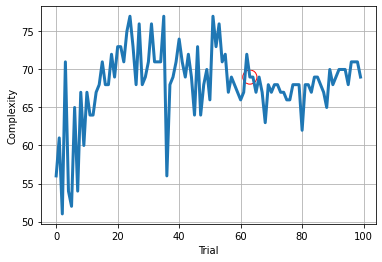

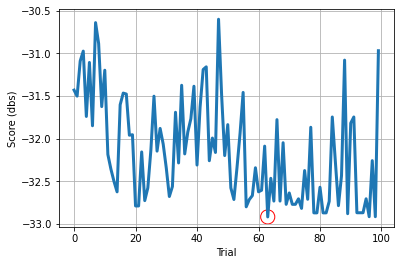

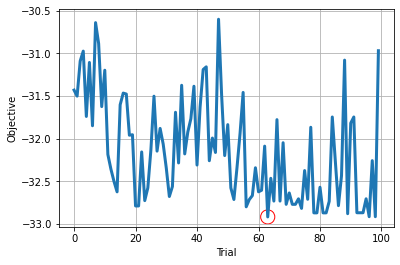

In [ ]:
plt.figure()
plt.plot(COMP, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Complexity')
plt.grid()
plt.scatter(63, COMP[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('COMP.png')

plt.figure()
plt.plot(SCR, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Score (dbs)')
plt.grid()
plt.scatter(63, SCR[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('SCR.png')

J = []
for i in study.trials:
  J.append(i.value)

plt.figure()
plt.plot(J, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Objective')
plt.grid()
plt.scatter(63, J[63], s=200, facecolors='none', edgecolors='r')
#plt.savefig('J.png')


In [ ]:
SCR[91]

-32.02398710001209

In [ ]:

D = {'p': [3, 4, 5, 6, 7, 8, 9], 'k' : [1, 3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# huge model
huge_model = Cell_try_2(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cpu")
#huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]


# small model
small_model = Cell_try_2(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
#small_model = small_model.to("cuda:0")
small_model = small_model.to("cpu")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = -13
complex_small = ex_D['k'][0] + ex_D['p'][0]
trtr_coef = 0.1
def objective(trial):
  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cpu")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  #return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge
  return  (complex_cur - complex_small) / (complex_huge - complex_small) - trtr_coef * (score_cur - score_small) / (score_huge - score_small)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

NameError: ignored